<center>
    <img src="Logo-Olist.png" alt="logo">
</center>

# Tests de segmentation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn import preprocessing
import numpy as np
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import adjusted_rand_score
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', 80)

In [3]:
df = pd.read_csv('df_clean.csv', index_col=[0])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97900 entries, 0 to 117327
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  97900 non-null  object 
 1   order_status        97900 non-null  object 
 2   jour_achat          97900 non-null  object 
 3   mois_achat          97900 non-null  int64  
 4   saison              97900 non-null  object 
 5   retard_livraison    97900 non-null  bool   
 6   seller_id           97900 non-null  object 
 7   proxi_city          97900 non-null  bool   
 8   produit_different   97900 non-null  int64  
 9   cust_env            97900 non-null  object 
 10  seller_env          97900 non-null  object 
 11  top_categ           97900 non-null  object 
 12  review_mean         97900 non-null  float64
 13  top_payment         97900 non-null  object 
 14  niveau_prix         97900 non-null  object 
 15  paiement_credit     97900 non-null  bool   
 16  Rec

In [5]:
df_base = pd.read_csv('p5_clean', index_col=[0])

Afin de pouvoir effectuer mes différents tests, je vais utiliser un échantillon de mon jeu de données.  
Cela allégera les temps de calcul.

In [6]:
df = df.sample(n=25000, random_state=0).copy()

In [7]:
df

customer_unique_id order_status jour_achat  mois_achat  \
53115   249bd5d40e52b5e10280890b693bc49b    delivered     Monday           7   
86867   0a843a6dd55792323714128564c1541e    delivered    Tuesday           7   
109536  e9a2267d90aba3e5ea9c9fc15bd8d343    delivered   Saturday           6   
21437   42669722f592114360451dba9cfb6f49    delivered    Tuesday           8   
28487   05ee75f22192fa64ce162fe7459960ef    delivered  Wednesday           5   
...                                  ...          ...        ...         ...   
10986   32bead9c6b5f3cbbf61929b5367efa59    delivered  Wednesday           7   
92364   c6d948d6f45911943f9800a1a9937005    delivered     Friday           2   
85670   8d50f5eadf50201ccdcedfb9e2ac8455    delivered     Monday           7   
15385   2d52410f260c83f32886e18a0cecca56    delivered  Wednesday          11   
23899   2ff5a158a294eb0441d9a1cc0135826e    delivered  Wednesday           2   

           saison  retard_livraison                         seller_id  \
53115         Eté             False  de23c3b98a88888289c6f5cc1209054a   
86867         Eté             False  25c5c91f63607446a97b143d2d535d31   
109536  Printemps             False  25debeafbce801fdd479539350185eee   
21437         Eté             False  1025f0e2d44d7041d6cf58b6550e0bfa   
28487   Printemps             False  77530e9772f57a62c906e1c21538ab82   
...           ...               ...                               ...   
10986         Eté             False  6560211a19b47992c3666cc44a7e94c0   
92364       Hiver              True  e8f6dc8e6a1dcde89d20e3995c8d90b3   
85670         Eté             False  db4350fd57ae30082dec7acbaacc17f9   
15385     Automne             False  b499c00f28f4b7069ff6550af8c1348a   
23899       Hiver             False  98dac6635aee4995d501a3972e047414   

        proxi_city  produit_different       cust_env     seller_env  \
53115        False                  1  intermediaire        urbaine   
86867        False                  1        urbaine        urbaine   
109536       False                  1        urbaine        urbaine   
21437        False                  1  intermediaire        urbaine   
28487        False                  1        urbaine  intermediaire   
...            ...                ...            ...            ...   
10986        False                  1        urbaine        urbaine   
92364        False                  1        urbaine        urbaine   
85670         True                  1        urbaine        urbaine   
15385        False                  1        urbaine        urbaine   
23899        False                  1  intermediaire        urbaine   

                    top_categ  review_mean  top_payment niveau_prix  \
53115                children          5.0  credit_card        cher   
86867               computers          5.0       boleto   tres cher   
109536                 beauty          4.0  credit_card      modere   
21437                    home          4.0  credit_card   tres cher   
28487                    home          5.0  credit_card      modere   
...                       ...          ...          ...         ...   
10986               computers          5.0  credit_card      modere   
92364               computers          3.0  credit_card      modere   
85670   culture_entertainment          5.0  credit_card        cher   
15385                 fashion          1.0       boleto    pas cher   
23899                    home          5.0      voucher      modere   

        paiement_credit  Recency  frequency  monetary  
53115              True       62          1    140.03  
86867             False      411          4    746.96  
109536            False      442          1     55.09  
21437              True       20          1    289.41  
28487             False      109          1     79.29  
...                 ...      ...        ...       ...  
10986              True       47          1     68.05  
92364             False      5

In [8]:
# Je crée des dictionnaires pour encoder mes variables catégorielles
dico_env = {'urbaine': 2,
            'intermediaire': 1,
            'rurale': 0}
dico_order = {'delivered': 5,
              'shipped': 4,
              'invoiced': 3,
              'processing': 2,
              'canceled': 1,
              'unavailable': 0}
dico_prix = {'tres cher': 4,
             'cher': 3,
             'modere': 2,
             'pas cher': 1}
dico_saison = {'Hiver': 1,
               'Printemps': 2,
               'Eté': 3,
               'Automne': 4}
dico_retard = {True: 1,
               False: 0
               }
dico_payment = {'credit_card': 4,
                'boleto': 3,
                'voucher': 2,
                'debit_card': 1}

In [9]:
df_encode = df.copy()

In [10]:
df_encode['order_status'] = df_encode['order_status'].replace(dico_order)
df_encode['saison'] = df_encode['saison'].replace(dico_saison)
df_encode['retard_livraison'] = df_encode['retard_livraison'].replace(
    dico_retard)
df_encode['proxi_city'] = df_encode['proxi_city'].replace(dico_retard)
df_encode['cust_env'] = df_encode['cust_env'].replace(dico_env)
df_encode['seller_env'] = df_encode['seller_env'].replace(dico_env)
df_encode['top_payment'] = df_encode['top_payment'].replace(dico_payment)
df_encode['niveau_prix'] = df_encode['niveau_prix'].replace(dico_prix)
df_encode['paiement_credit'] = df_encode['paiement_credit'].replace(
    dico_retard)

In [11]:
df_encode

customer_unique_id  order_status jour_achat  mois_achat  \
53115   249bd5d40e52b5e10280890b693bc49b             5     Monday           7   
86867   0a843a6dd55792323714128564c1541e             5    Tuesday           7   
109536  e9a2267d90aba3e5ea9c9fc15bd8d343             5   Saturday           6   
21437   42669722f592114360451dba9cfb6f49             5    Tuesday           8   
28487   05ee75f22192fa64ce162fe7459960ef             5  Wednesday           5   
...                                  ...           ...        ...         ...   
10986   32bead9c6b5f3cbbf61929b5367efa59             5  Wednesday           7   
92364   c6d948d6f45911943f9800a1a9937005             5     Friday           2   
85670   8d50f5eadf50201ccdcedfb9e2ac8455             5     Monday           7   
15385   2d52410f260c83f32886e18a0cecca56             5  Wednesday          11   
23899   2ff5a158a294eb0441d9a1cc0135826e             5  Wednesday           2   

        saison  retard_livraison                         seller_id  \
53115        3                 0  de23c3b98a88888289c6f5cc1209054a   
86867        3                 0  25c5c91f63607446a97b143d2d535d31   
109536       2                 0  25debeafbce801fdd479539350185eee   
21437        3                 0  1025f0e2d44d7041d6cf58b6550e0bfa   
28487        2                 0  77530e9772f57a62c906e1c21538ab82   
...        ...               ...                               ...   
10986        3                 0  6560211a19b47992c3666cc44a7e94c0   
92364        1                 1  e8f6dc8e6a1dcde89d20e3995c8d90b3   
85670        3                 0  db4350fd57ae30082dec7acbaacc17f9   
15385        4                 0  b499c00f28f4b7069ff6550af8c1348a   
23899        1                 0  98dac6635aee4995d501a3972e047414   

        proxi_city  produit_different  cust_env  seller_env  \
53115            0                  1         1           2   
86867            0                  1         2           2   
109536           0                  1         2           2   
21437            0                  1         1           2   
28487            0                  1         2           1   
...            ...                ...       ...         ...   
10986            0                  1         2           2   
92364            0                  1         2           2   
85670            1                  1         2           2   
15385            0                  1         2           2   
23899            0                  1         1           2   

                    top_categ  review_mean  top_payment  niveau_prix  \
53115                children          5.0            4            3   
86867               computers          5.0            3            4   
109536                 beauty          4.0            4            2   
21437                    home          4.0            4            4   
28487                    home          5.0            4            2   
...                       ...          ...          ...          ...   
10986               computers          5.0            4            2   
92364               computers          3.0            4            2   
85670   culture_entertainment          5.0            4            3   
15385                 fashion          1.0            3            1   
23899                    home          5.0            2            2   

        paiement_credit  Recency  frequency  monetary  
53115                 1       62          1    140.03  
86867                 0      411          4    746.96  
109536                0      442          1     55.09  
21437                 1       20          1    289.41  
28487                 0      109          1     79.29  
...                 ...      ...        ...       ...  
10986                 1       47          1     68.05  
92364                 0      555          1     82.97  
85670                 0       41          1    107.85  
15385                 0   

In [12]:
modele_baseline_encode = df_encode[['Recency', 'frequency', 'monetary']]

modele_5_indic_encode = df_encode[['Recency', 'frequency',
                                   'monetary', 'review_mean', 'proxi_city']]
modele_5_cat_col = [4]

modele_6_indic_encode = df_encode[['Recency', 'frequency', 'monetary',
                                   'review_mean', 'proxi_city', 'seller_env']]
modele_6_cat_col = [4, 5]

modele_7_indic_encode = df_encode[['Recency', 'frequency', 'monetary',
                                   'review_mean', 'proxi_city', 'seller_env', 'niveau_prix']]
modele_7_cat_col = [4, 5, 6]
modele_13_indic_encode = df_encode[['Recency', 'frequency', 'monetary',
                                    'review_mean', 'proxi_city', 'seller_env',
                                    'order_status', 'niveau_prix',
                                    'saison', 'retard_livraison',
                                    'produit_different', 'cust_env', 'top_payment', ]]
modele_13_cat_col = [4, 5, 6, 7, 8, 9, 10, 11, 12]

# ACP

In [13]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [14]:
# Fonction qui me permet d'afficher mes cercles de corrélations
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:  # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(8, 8))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1, :]), max(
                    pcs[d1, :]), min(pcs[d2, :]), max(pcs[d2, :])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                           pcs[d1, :], pcs[d2, :],
                           angles='xy', scale_units='xy', scale=1, color="orange")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(LineCollection(
                    lines, axes=ax, alpha=.1, color='black'))

            # affichage des noms des variables
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize='14', ha='center',
                                 va='center', rotation=label_rotation, color="blue", alpha=0.5)

            # affichage du cercle
            circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [15]:
def acp(modele, n_comp=3, standardiser=MinMaxScaler()):
    X = modele.values
    names = modele.index
    nom_variable = modele.columns

    # Centrage et réduction
    scaler = standardiser.fit(X)
    X_scaled = scaler.transform(X)

    pca = decomposition.PCA(n_components=len(modele.columns))
    pca.fit(X_scaled)
    display_scree_plot(pca)

    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)

    pcs = pca.components_
    display_circles(pcs, n_comp, pca, [
        (0, 1), (0, 2), (0, 3)], labels=np.array(nom_variable))

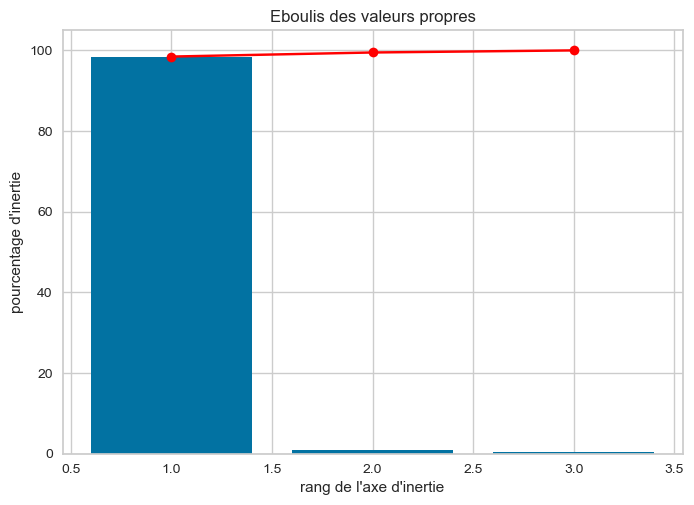

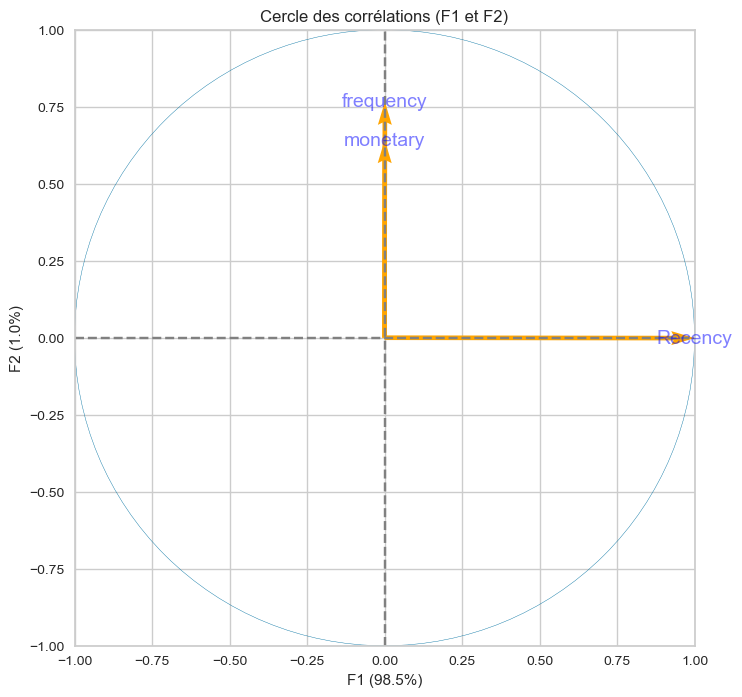

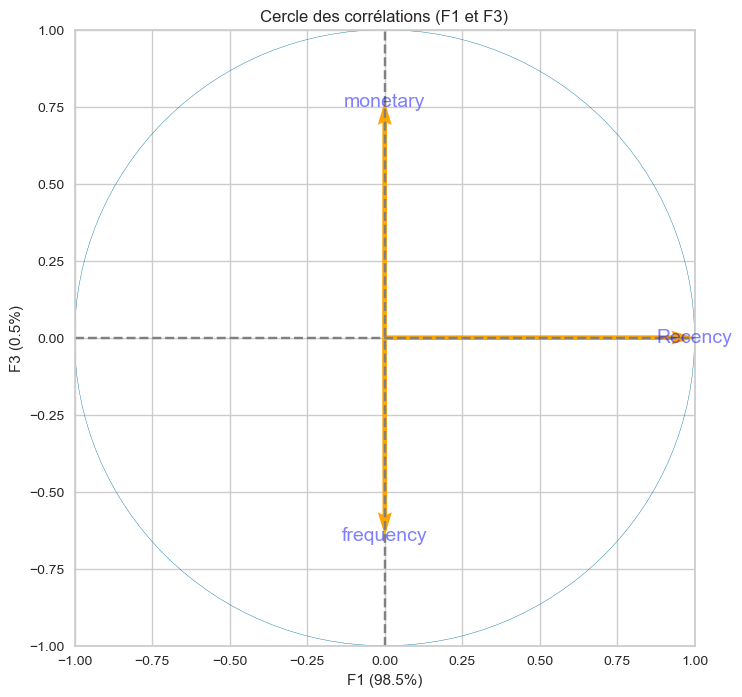

In [16]:
acp(modele=modele_baseline_encode)

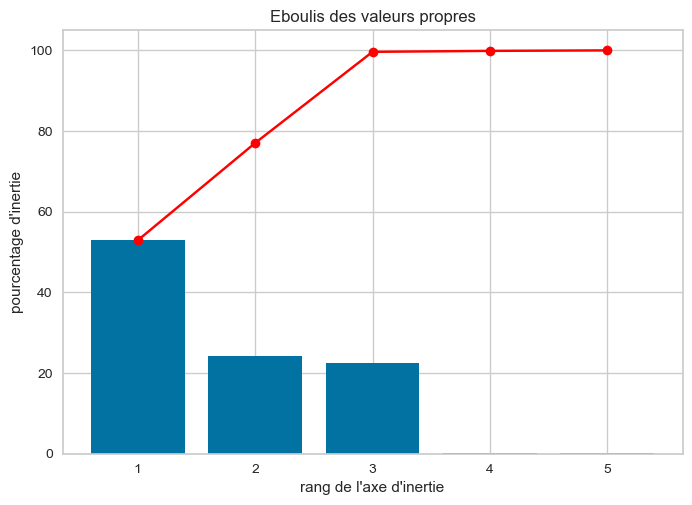

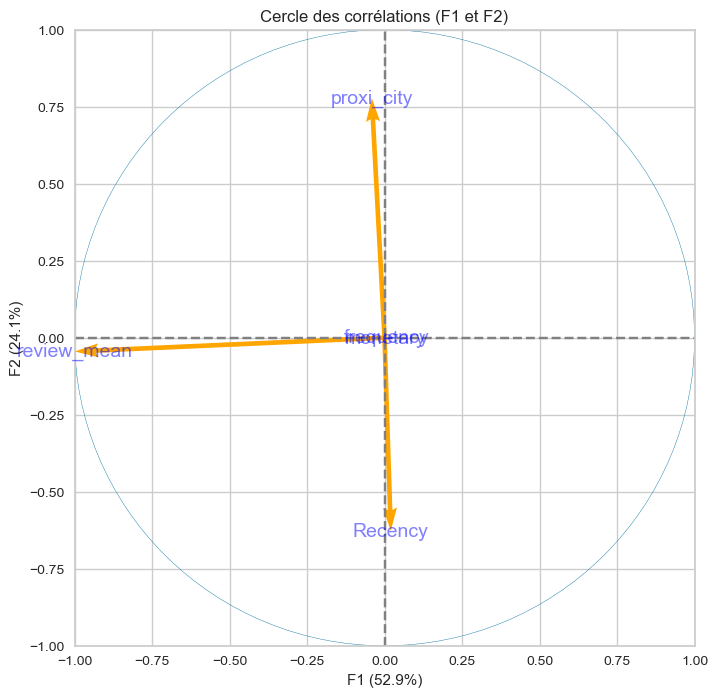

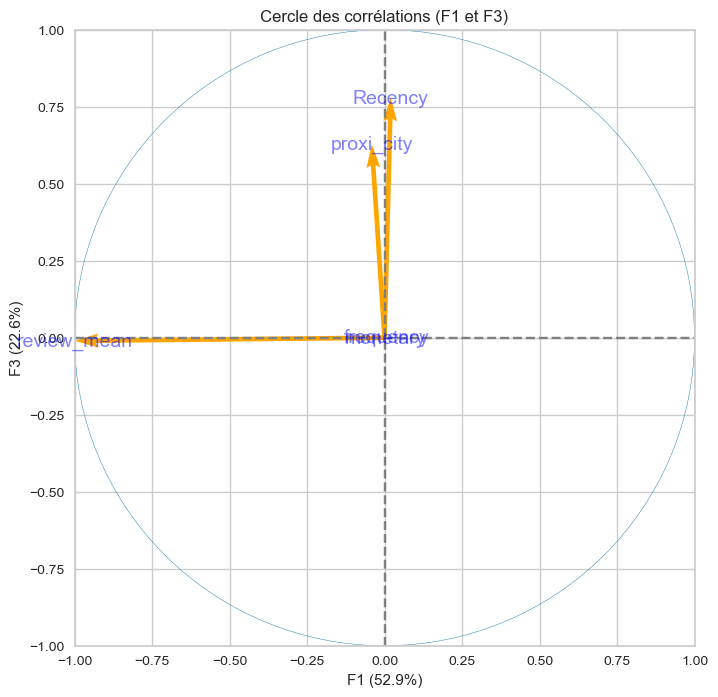

In [17]:
acp(modele=modele_5_indic_encode)

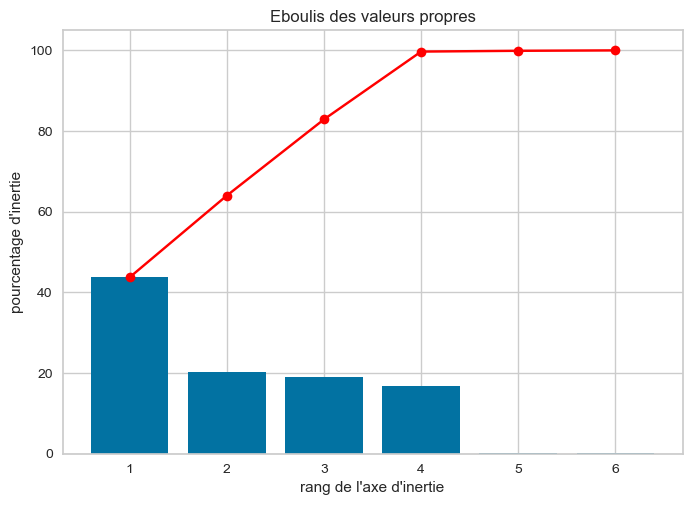

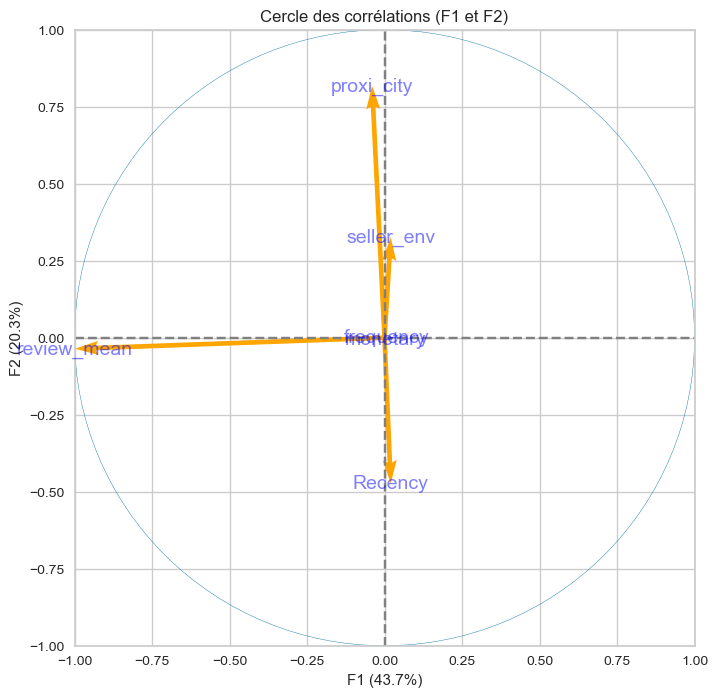

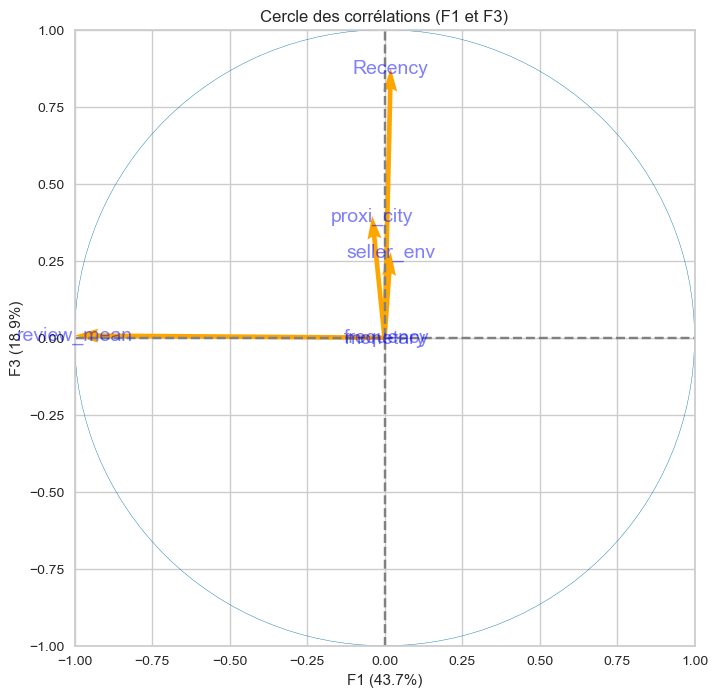

In [18]:
acp(modele=modele_6_indic_encode)

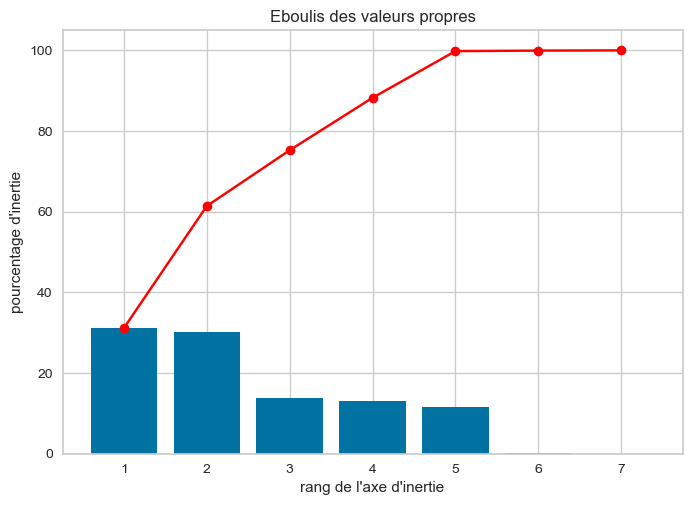

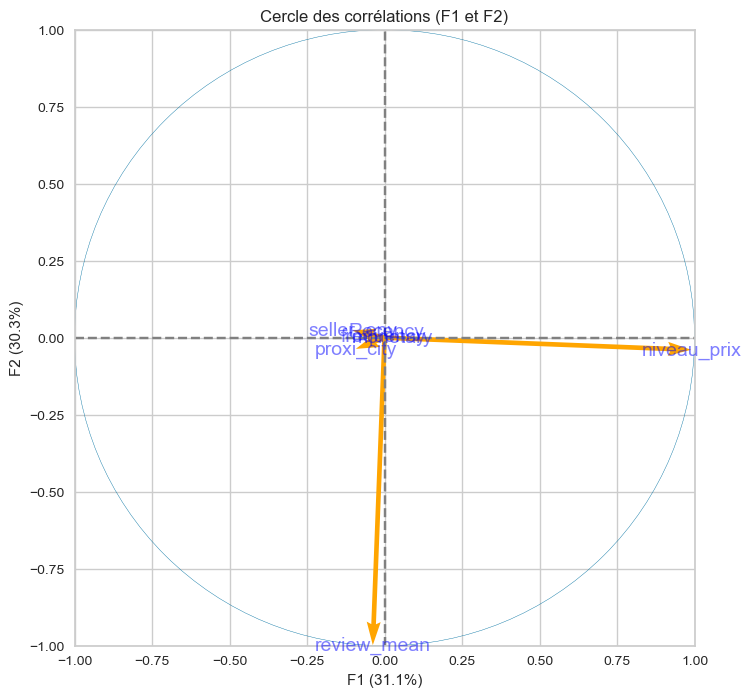

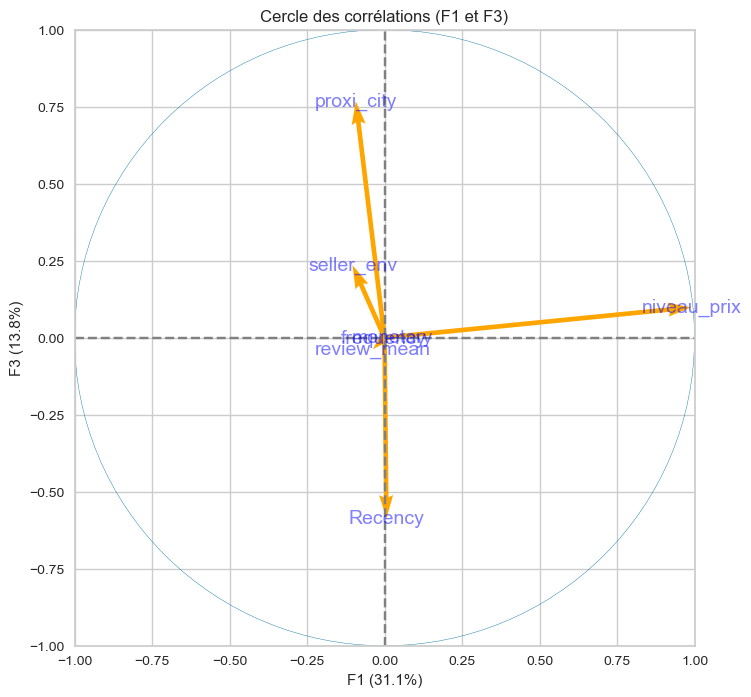

In [19]:
acp(modele=modele_7_indic_encode)

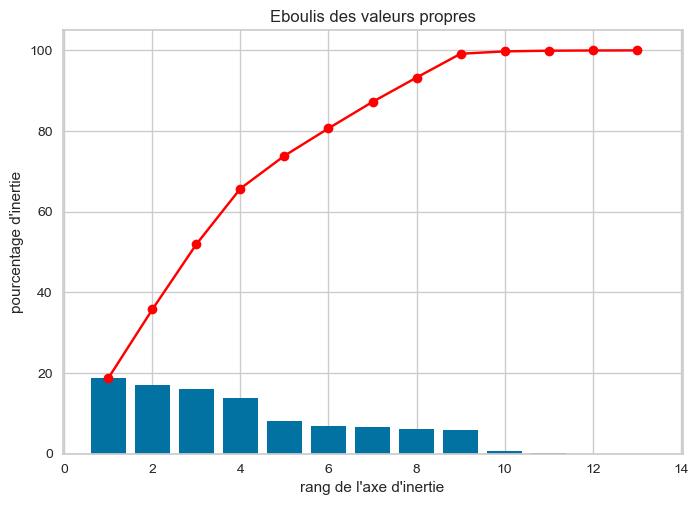

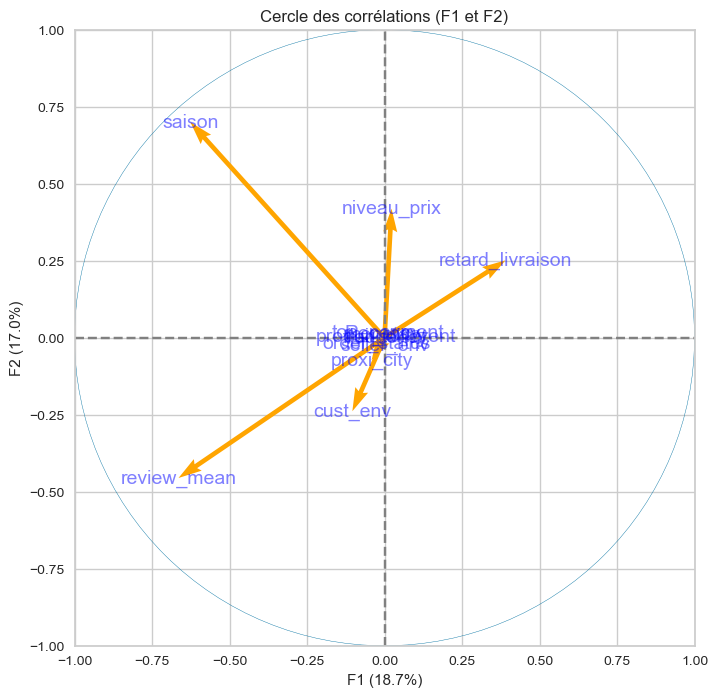

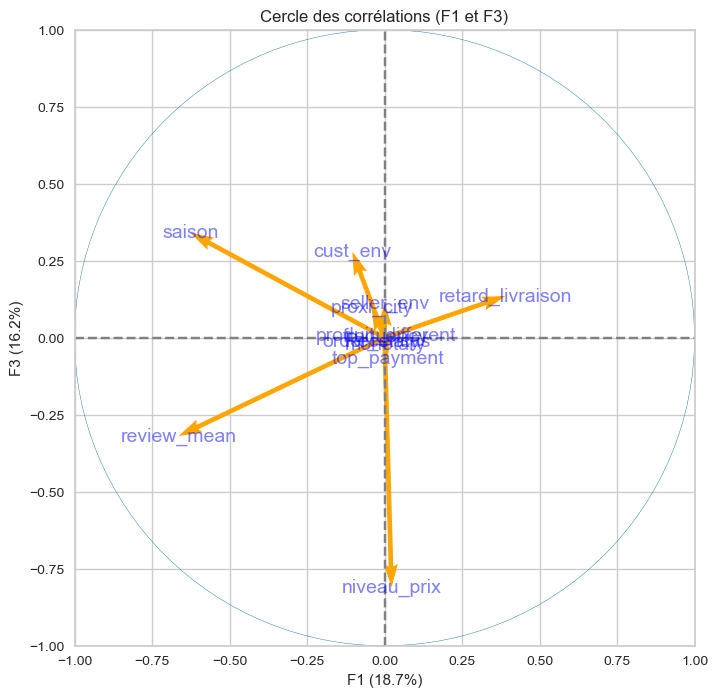

In [20]:
acp(modele=modele_13_indic_encode)

# Kmeans

In [21]:
def kmeans(modele, k=(1, 14), standardiser=MinMaxScaler()):

    # Centrage et réduction
    scale = standardiser
    x_scaled = scale.fit_transform(modele)

    model_kmean = KMeans(random_state=0)
    visualizer = KElbowVisualizer(model_kmean, k=k, timings=False)
    visualizer.fit(x_scaled)
    visualizer.poof()
    n_cluster = visualizer.elbow_value_
    print('Le nombre de kmeans optimal est :', visualizer.elbow_value_)

    kmeans_scaled = KMeans(n_cluster, random_state=0)
    kmeans_scaled.fit(x_scaled)
    identified_clusters = kmeans_scaled.fit_predict(modele)
    modele['cluster_kmean'] = kmeans_scaled.fit_predict(x_scaled)

    f, ax = plt.subplots(figsize=(25, 8))
    ax = sns.countplot(x="cluster_kmean", data=modele)
    ax.bar_label(ax.containers[0])
    plt.show()

    sil_score = silhouette_score(
        x_scaled, kmeans_scaled.labels_, metric='euclidean')
    print('Silhouette Score: %.3f' % sil_score)

    visualizer = SilhouetteVisualizer(kmeans_scaled).fit(x_scaled)
    visualizer.poof()

    for i, col in enumerate(modele.columns):
        plt.figure(i)
        sns.boxplot(data=modele, x=modele['cluster_kmean'], y=modele[col])
        plt.show()
    return modele

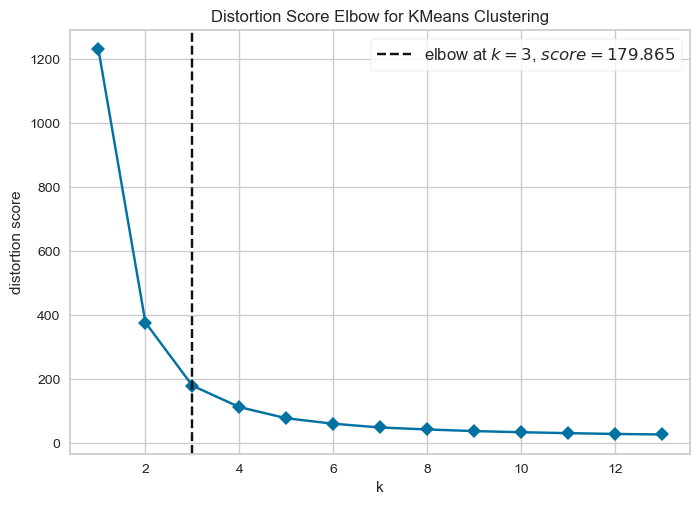

Le nombre de kmeans optimal est : 3


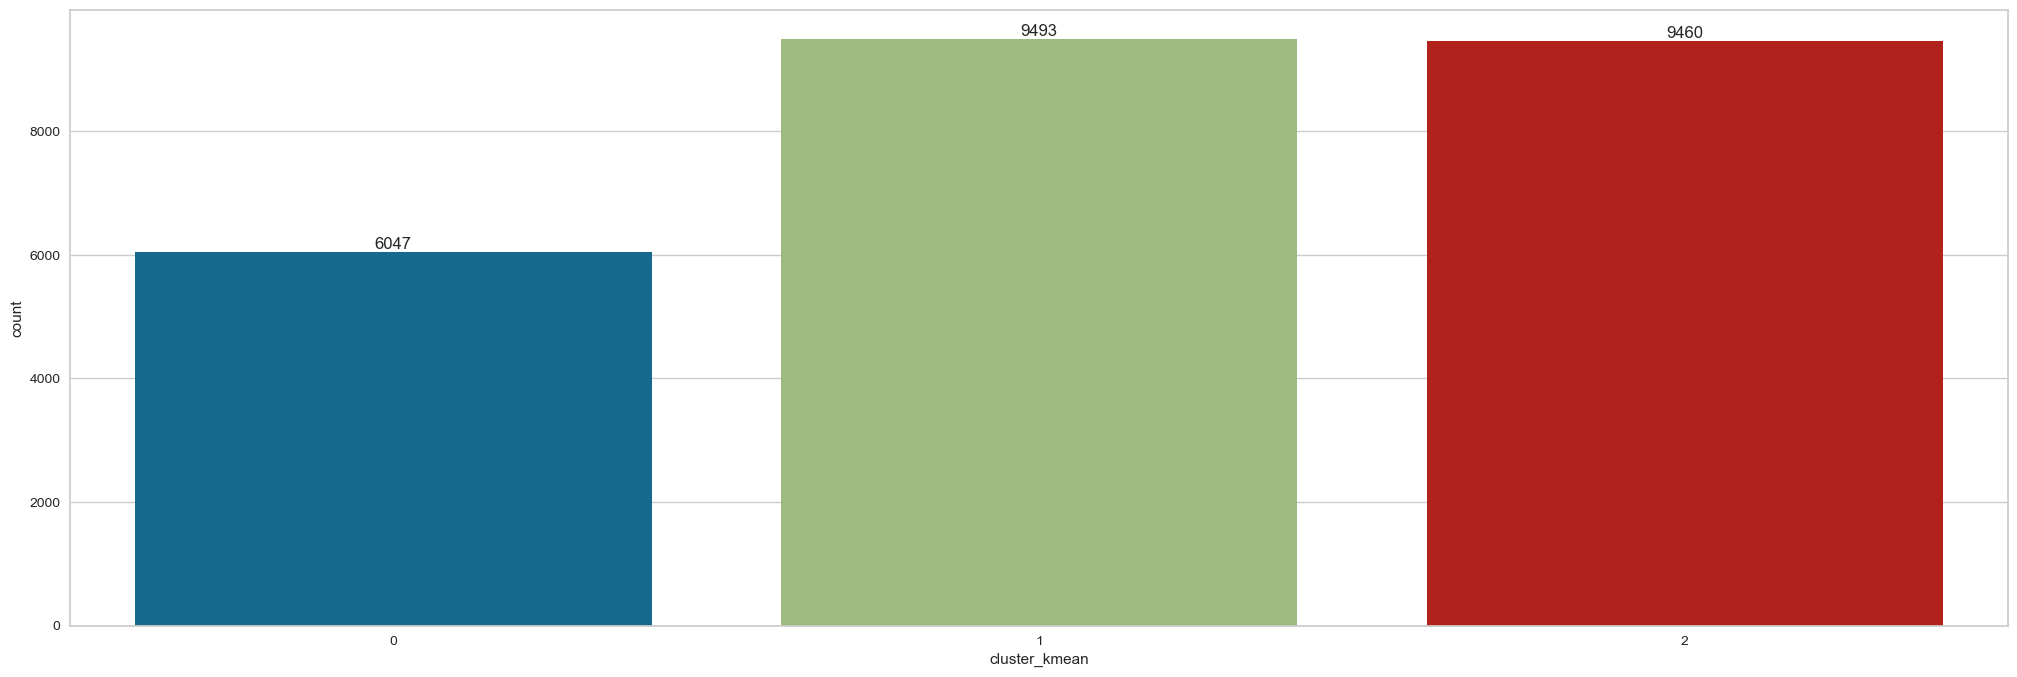

Silhouette Score: 0.551


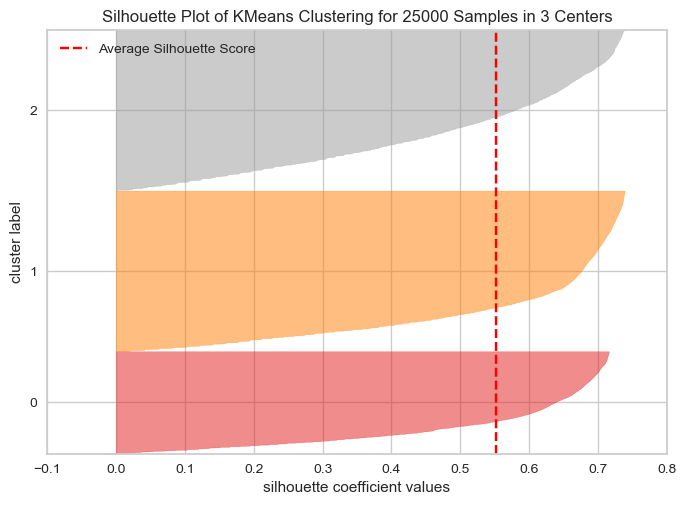

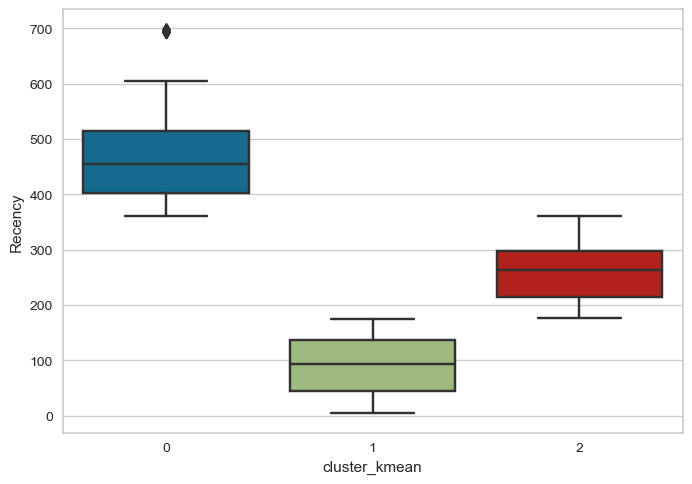

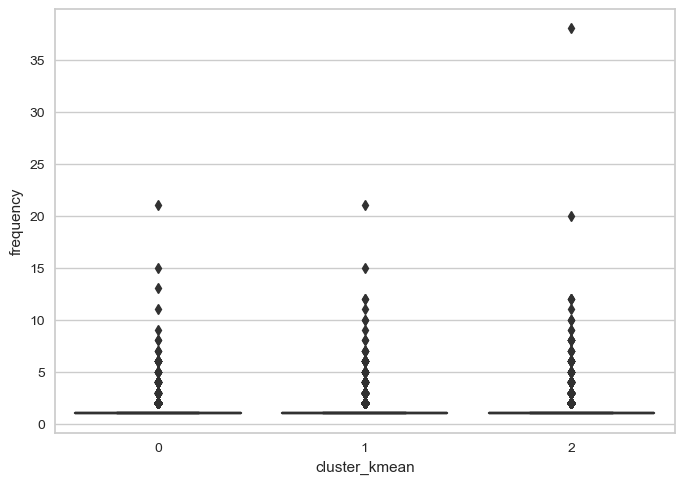

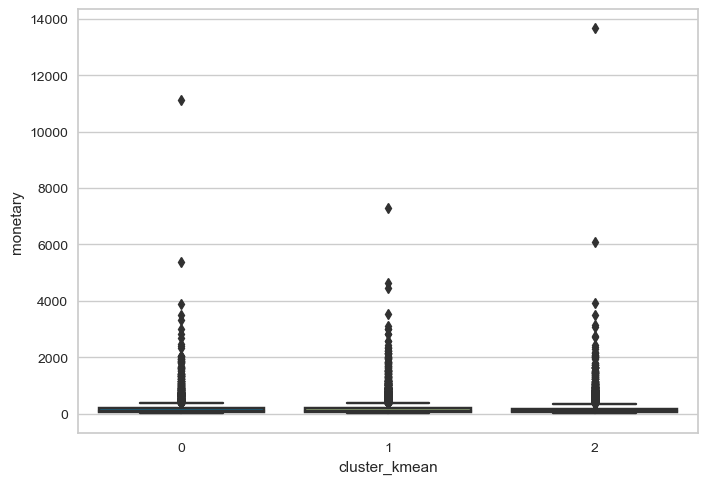

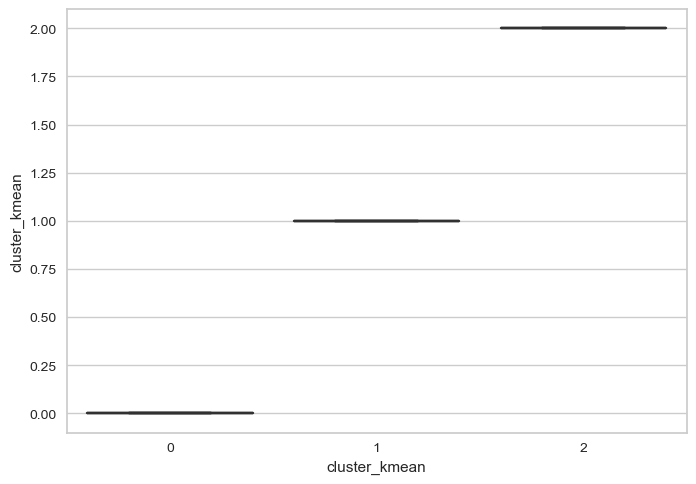

Recency  frequency  monetary  cluster_kmean
53115        62          1    140.03              1
86867       411          4    746.96              0
109536      442          1     55.09              0
21437        20          1    289.41              1
28487       109          1     79.29              1
...         ...        ...       ...            ...
10986        47          1     68.05              1
92364       555          1     82.97              0
85670        41          1    107.85              1
15385       277          1     39.08              2
23899       193          2    135.82              2

[25000 rows x 4 columns]

In [22]:
kmeans(modele_baseline_encode)

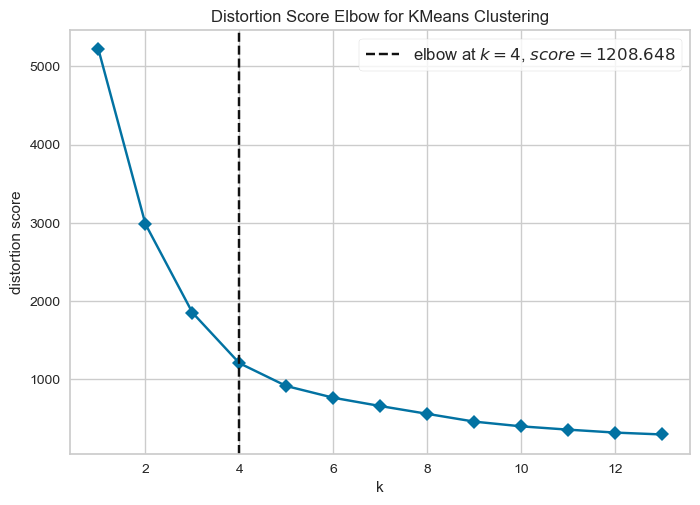

Le nombre de kmeans optimal est : 4


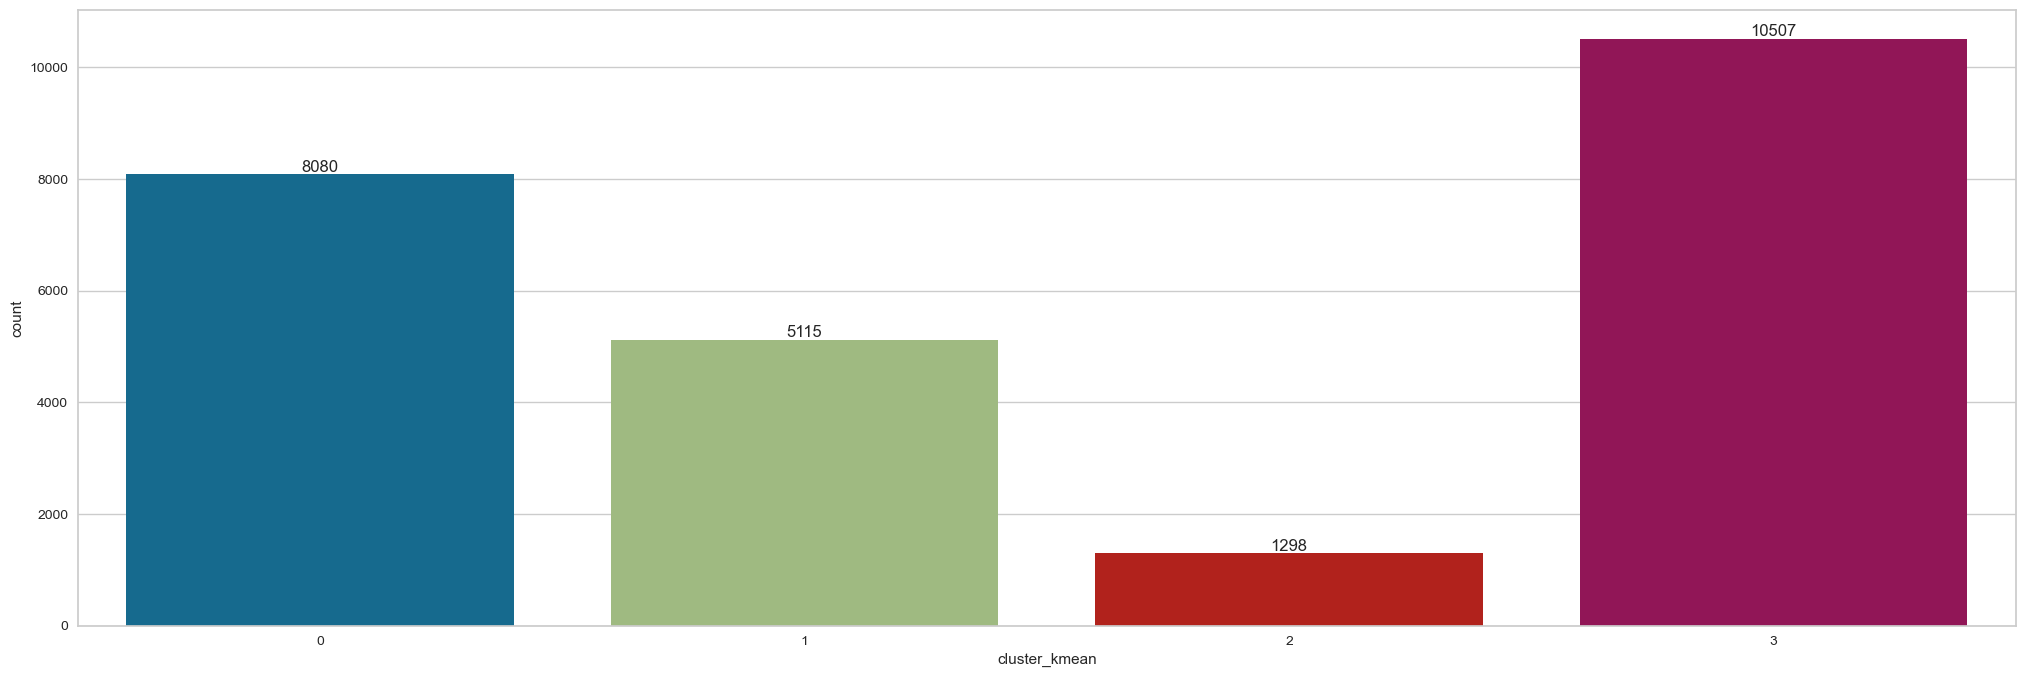

Silhouette Score: 0.469


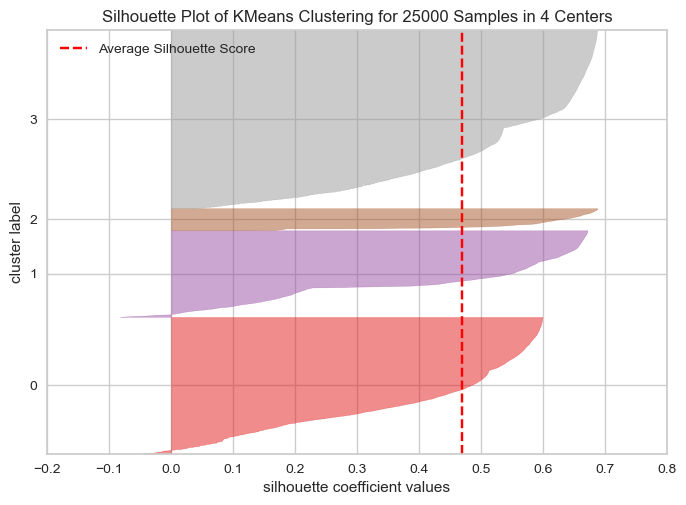

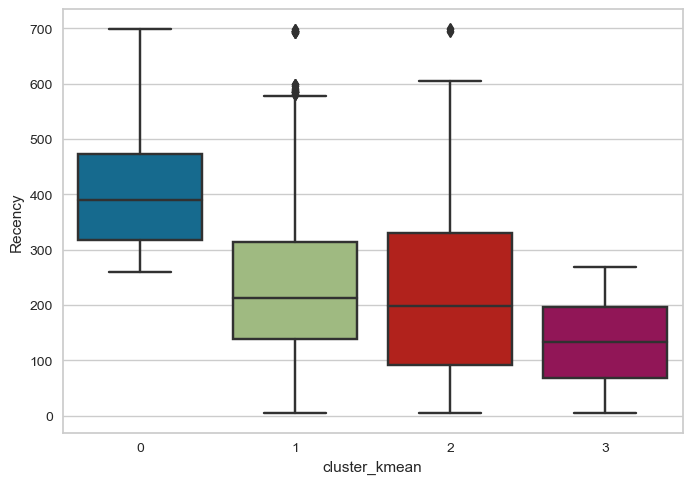

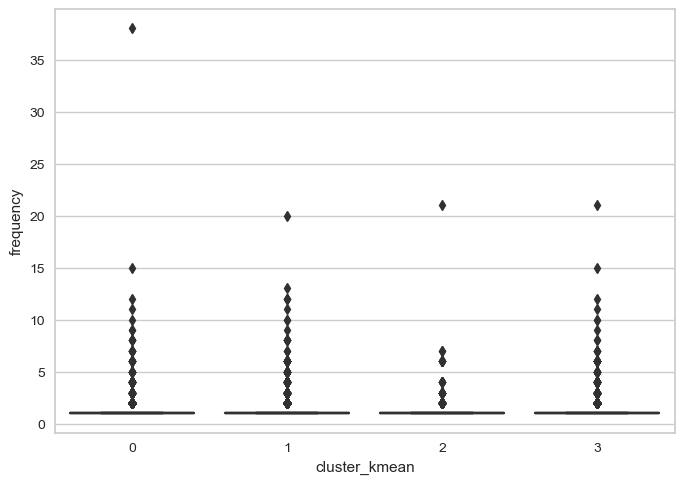

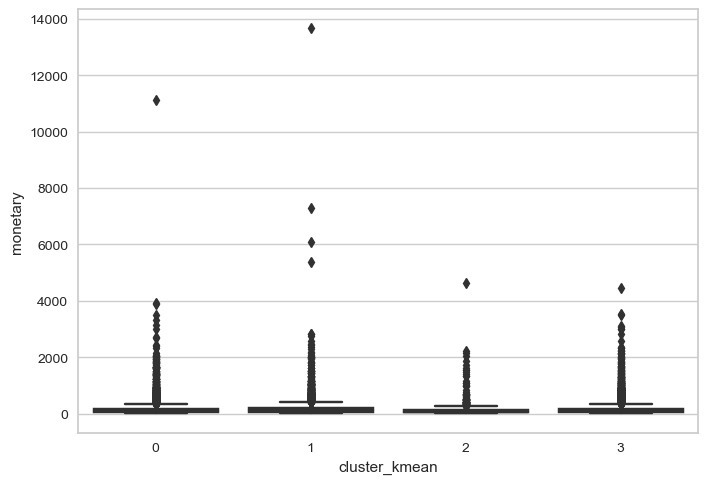

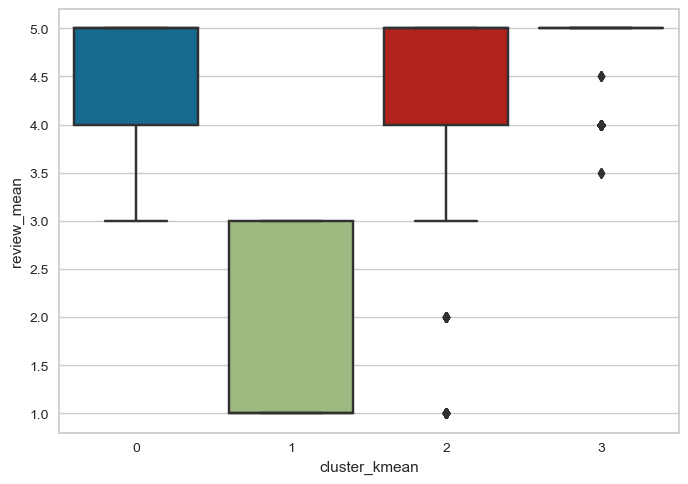

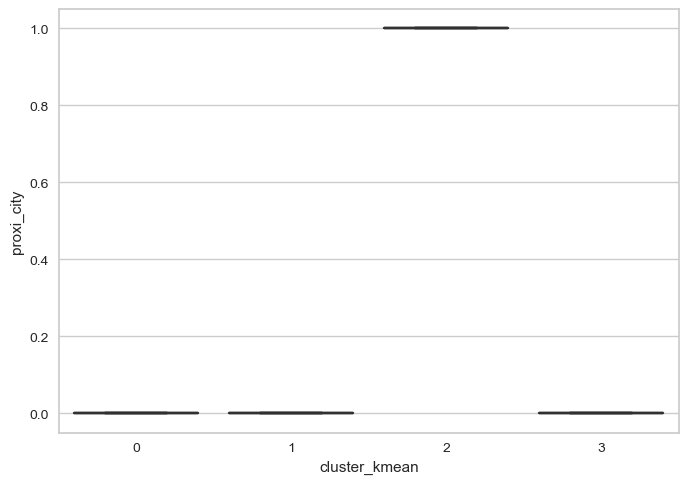

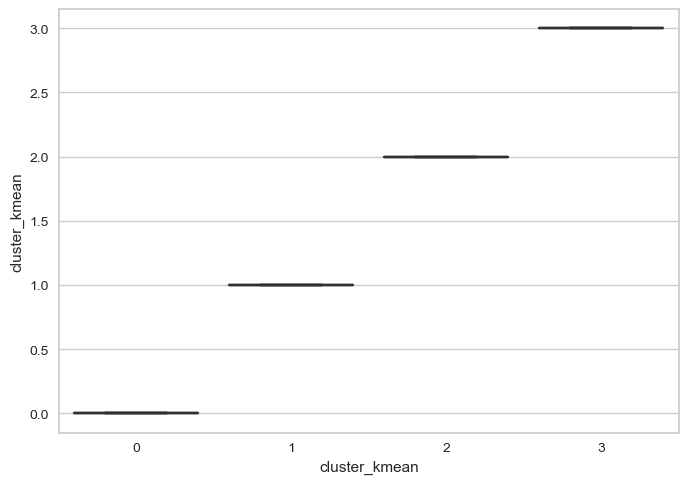

Recency  frequency  monetary  review_mean  proxi_city  cluster_kmean
53115        62          1    140.03          5.0           0              3
86867       411          4    746.96          5.0           0              0
109536      442          1     55.09          4.0           0              0
21437        20          1    289.41          4.0           0              3
28487       109          1     79.29          5.0           0              3
...         ...        ...       ...          ...         ...            ...
10986        47          1     68.05          5.0           0              3
92364       555          1     82.97          3.0           0              0
85670        41          1    107.85          5.0           1              2
15385       277          1     39.08          1.0           0              1
23899       193          2    135.82          5.0           0              3

[25000 rows x 6 columns]

In [23]:
kmeans(modele_5_indic_encode)

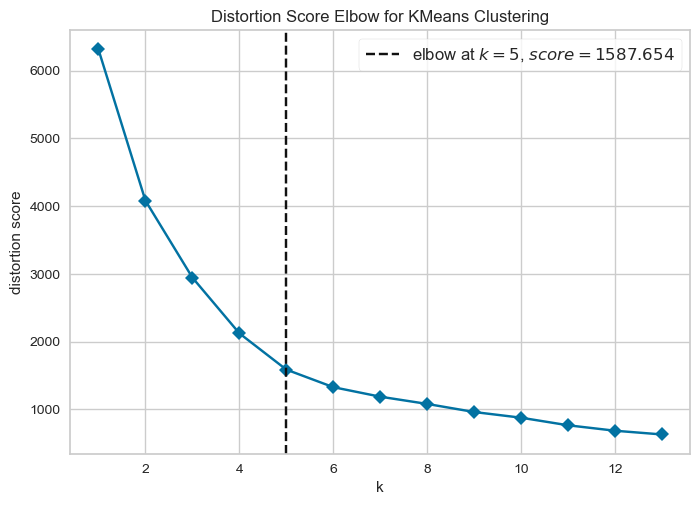

Le nombre de kmeans optimal est : 5


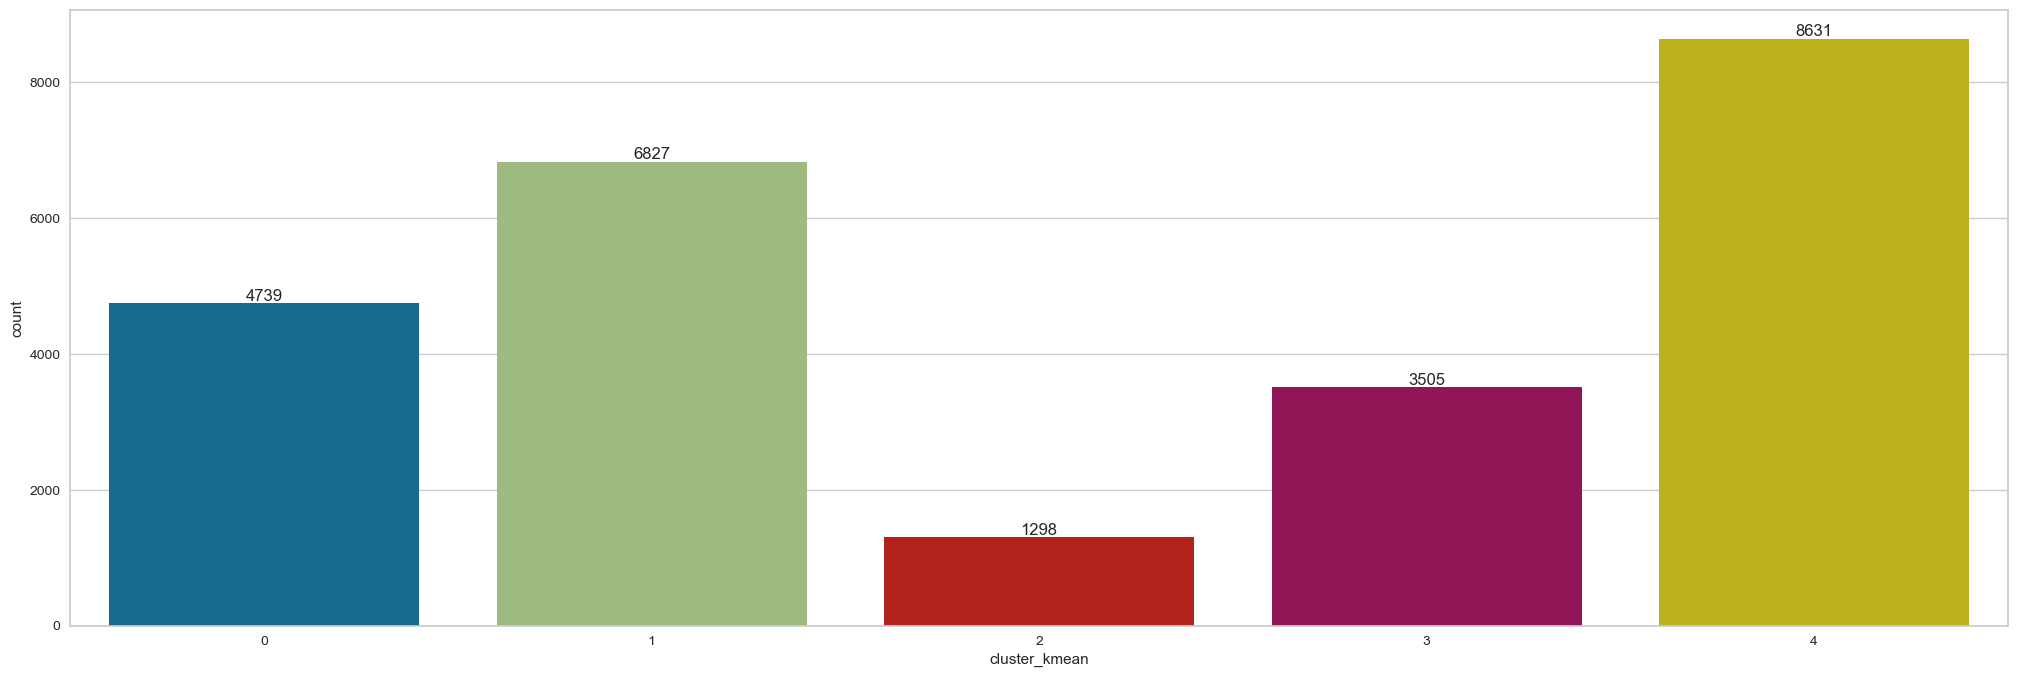

Silhouette Score: 0.441


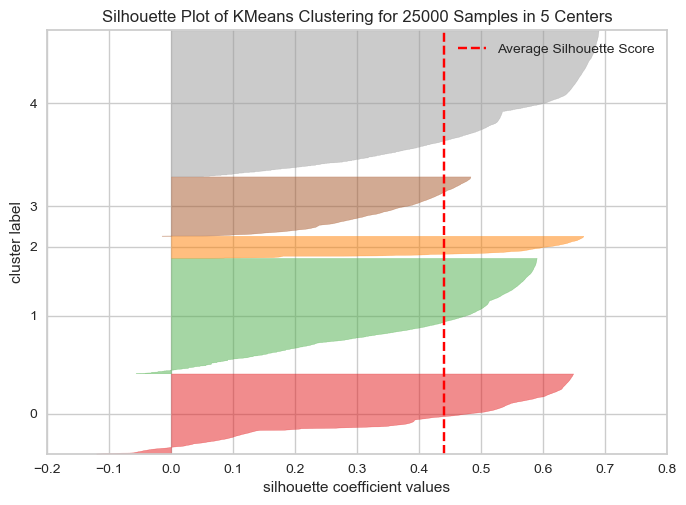

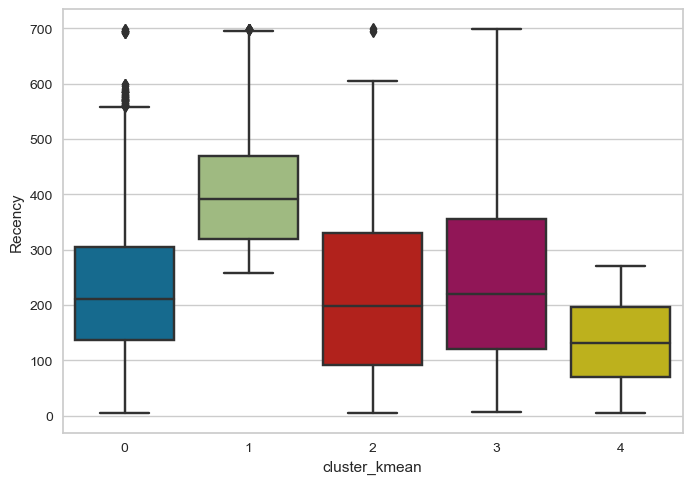

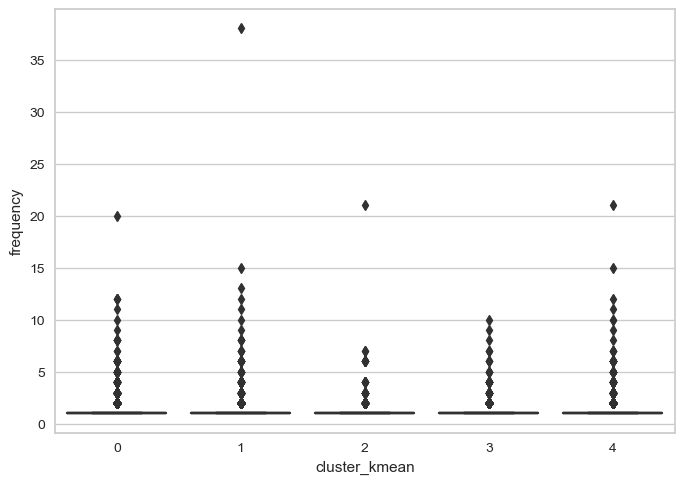

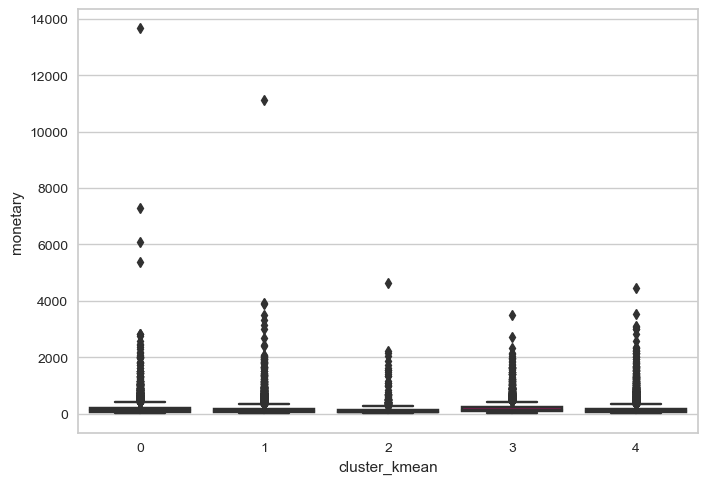

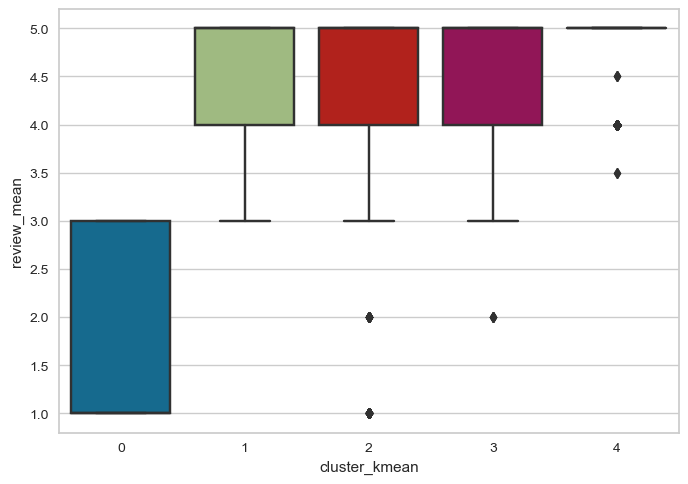

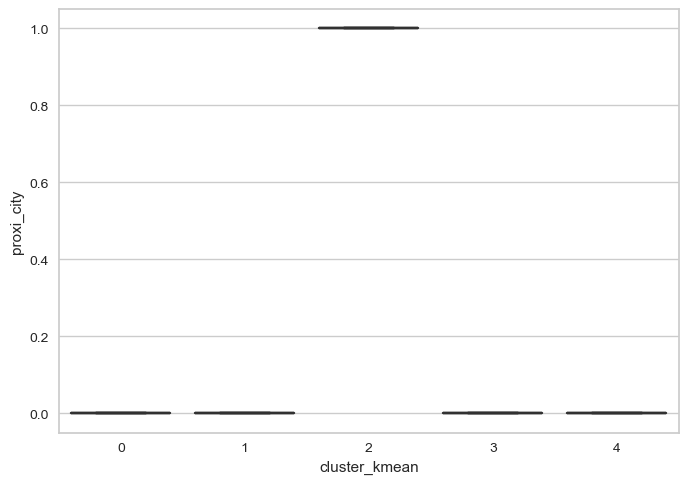

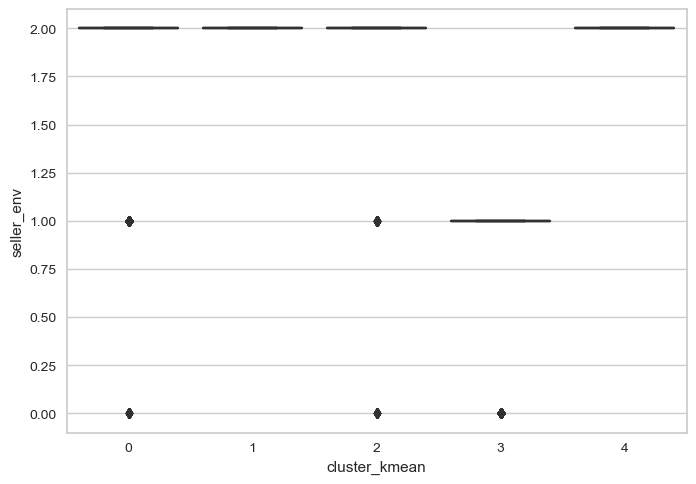

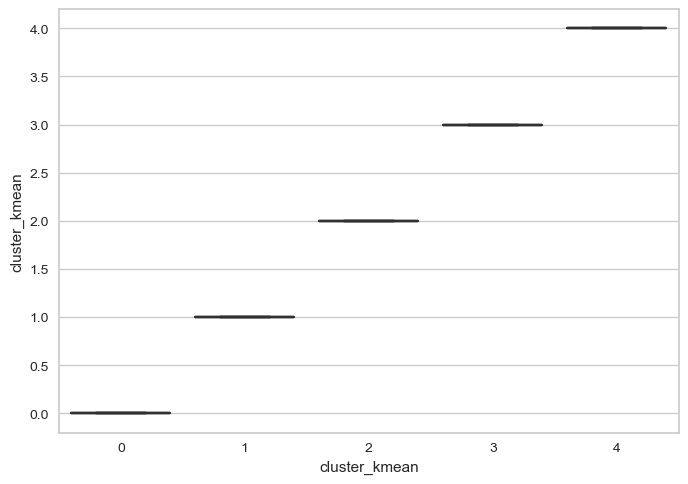

Recency  frequency  monetary  review_mean  proxi_city  seller_env  \
53115        62          1    140.03          5.0           0           2   
86867       411          4    746.96          5.0           0           2   
109536      442          1     55.09          4.0           0           2   
21437        20          1    289.41          4.0           0           2   
28487       109          1     79.29          5.0           0           1   
...         ...        ...       ...          ...         ...         ...   
10986        47          1     68.05          5.0           0           2   
92364       555          1     82.97          3.0           0           2   
85670        41          1    107.85          5.0           1           2   
15385       277          1     39.08          1.0           0           2   
23899       193          2    135.82          5.0           0           2   

        cluster_kmean  
53115               4  
86867               1  
109536              1  
21437               4  
28487               3  
...               ...  
10986               4  
92364               1  
85670               2  
15385               0  
23899               4  

[25000 rows x 7 columns]

In [24]:
kmeans(modele_6_indic_encode)

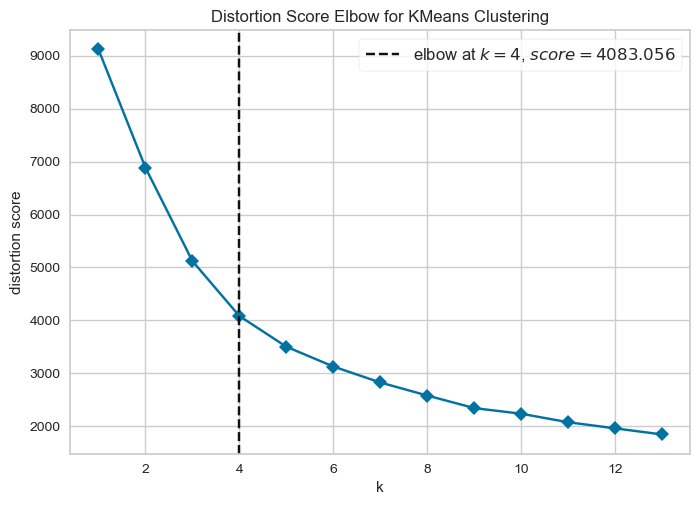

Le nombre de kmeans optimal est : 4


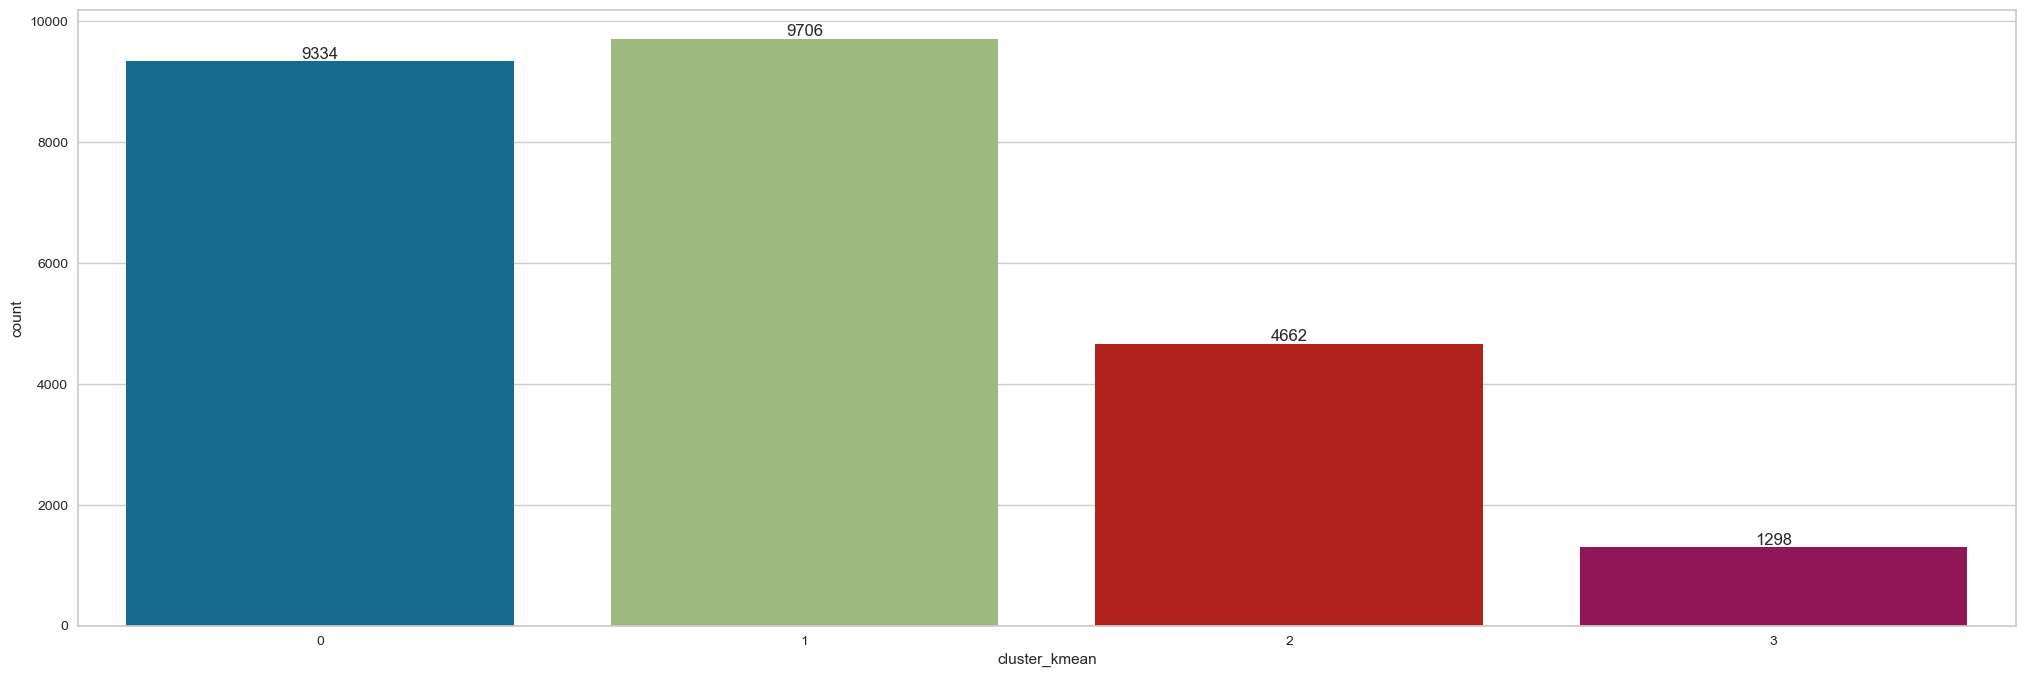

Silhouette Score: 0.340


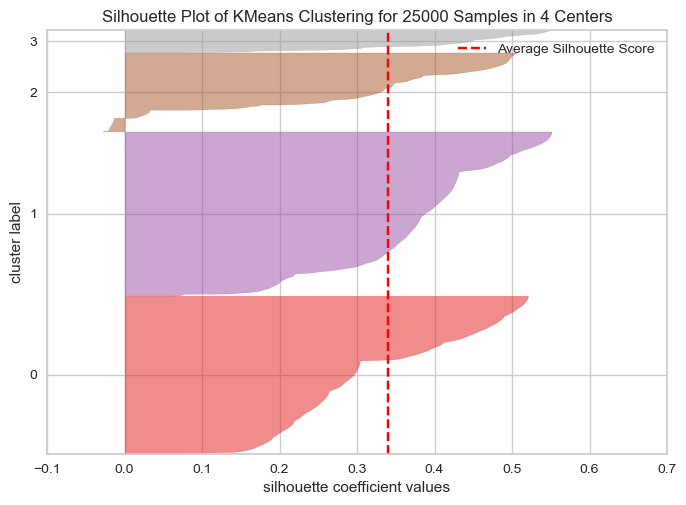

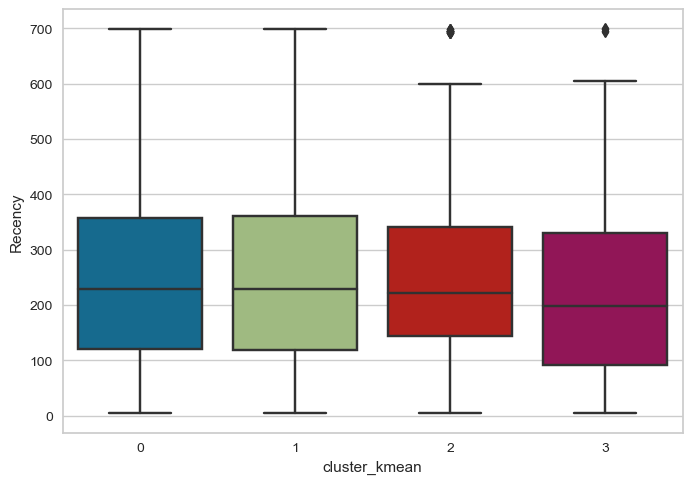

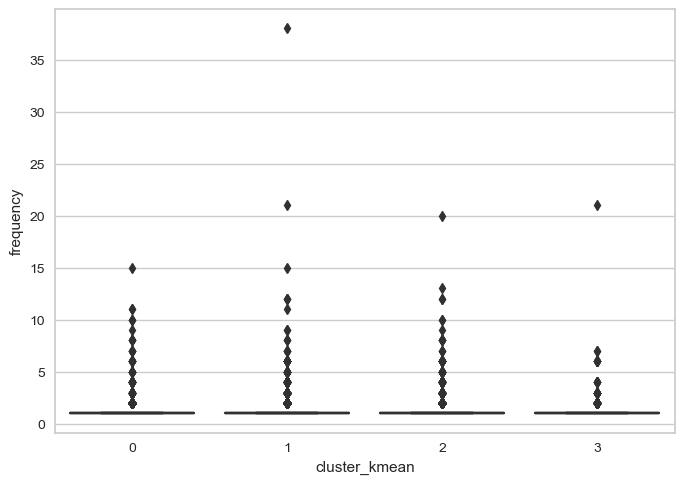

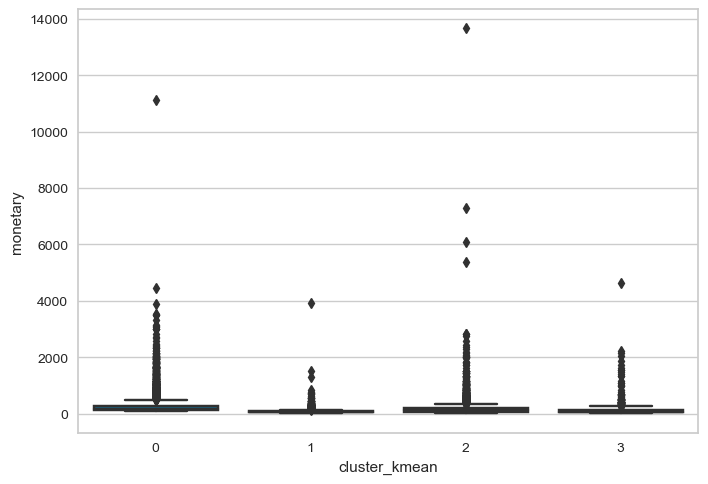

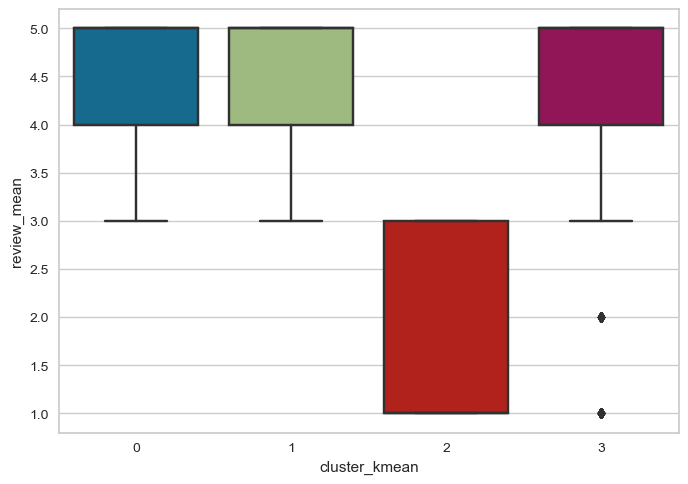

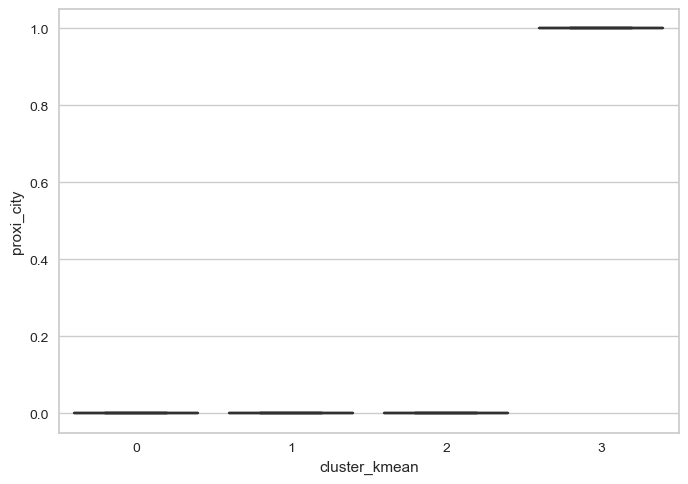

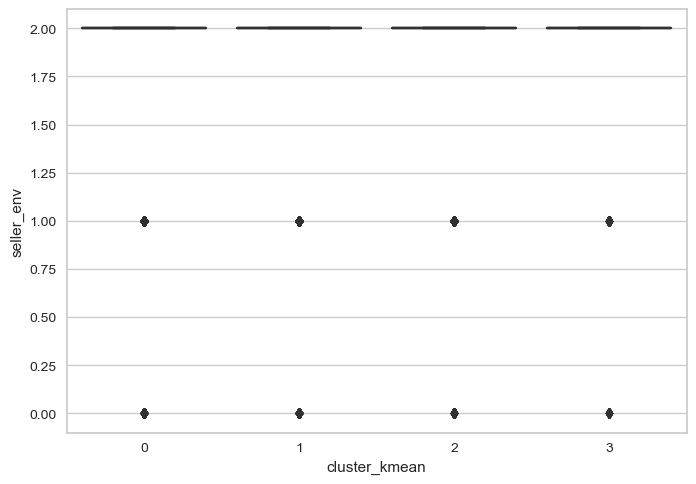

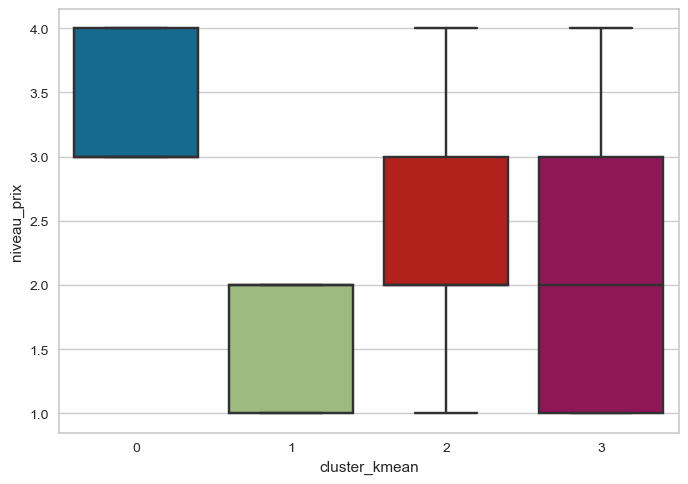

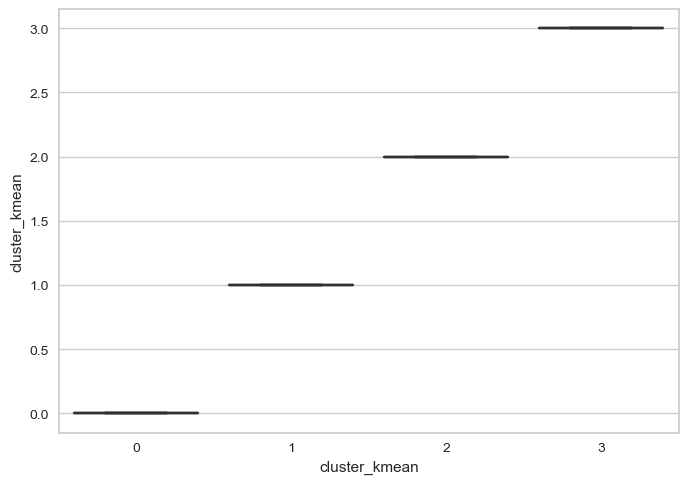

Recency  frequency  monetary  review_mean  proxi_city  seller_env  \
53115        62          1    140.03          5.0           0           2   
86867       411          4    746.96          5.0           0           2   
109536      442          1     55.09          4.0           0           2   
21437        20          1    289.41          4.0           0           2   
28487       109          1     79.29          5.0           0           1   
...         ...        ...       ...          ...         ...         ...   
10986        47          1     68.05          5.0           0           2   
92364       555          1     82.97          3.0           0           2   
85670        41          1    107.85          5.0           1           2   
15385       277          1     39.08          1.0           0           2   
23899       193          2    135.82          5.0           0           2   

        niveau_prix  cluster_kmean  
53115             3              0  
86867             4              0  
109536            2              1  
21437             4              0  
28487             2              1  
...             ...            ...  
10986             2              1  
92364             2              2  
85670             3              3  
15385             1              2  
23899             2              1  

[25000 rows x 8 columns]

In [25]:
kmeans(modele_7_indic_encode)

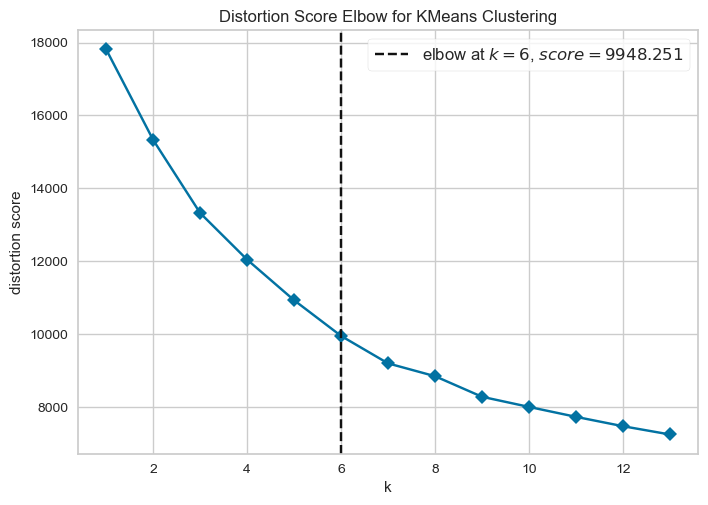

Le nombre de kmeans optimal est : 6


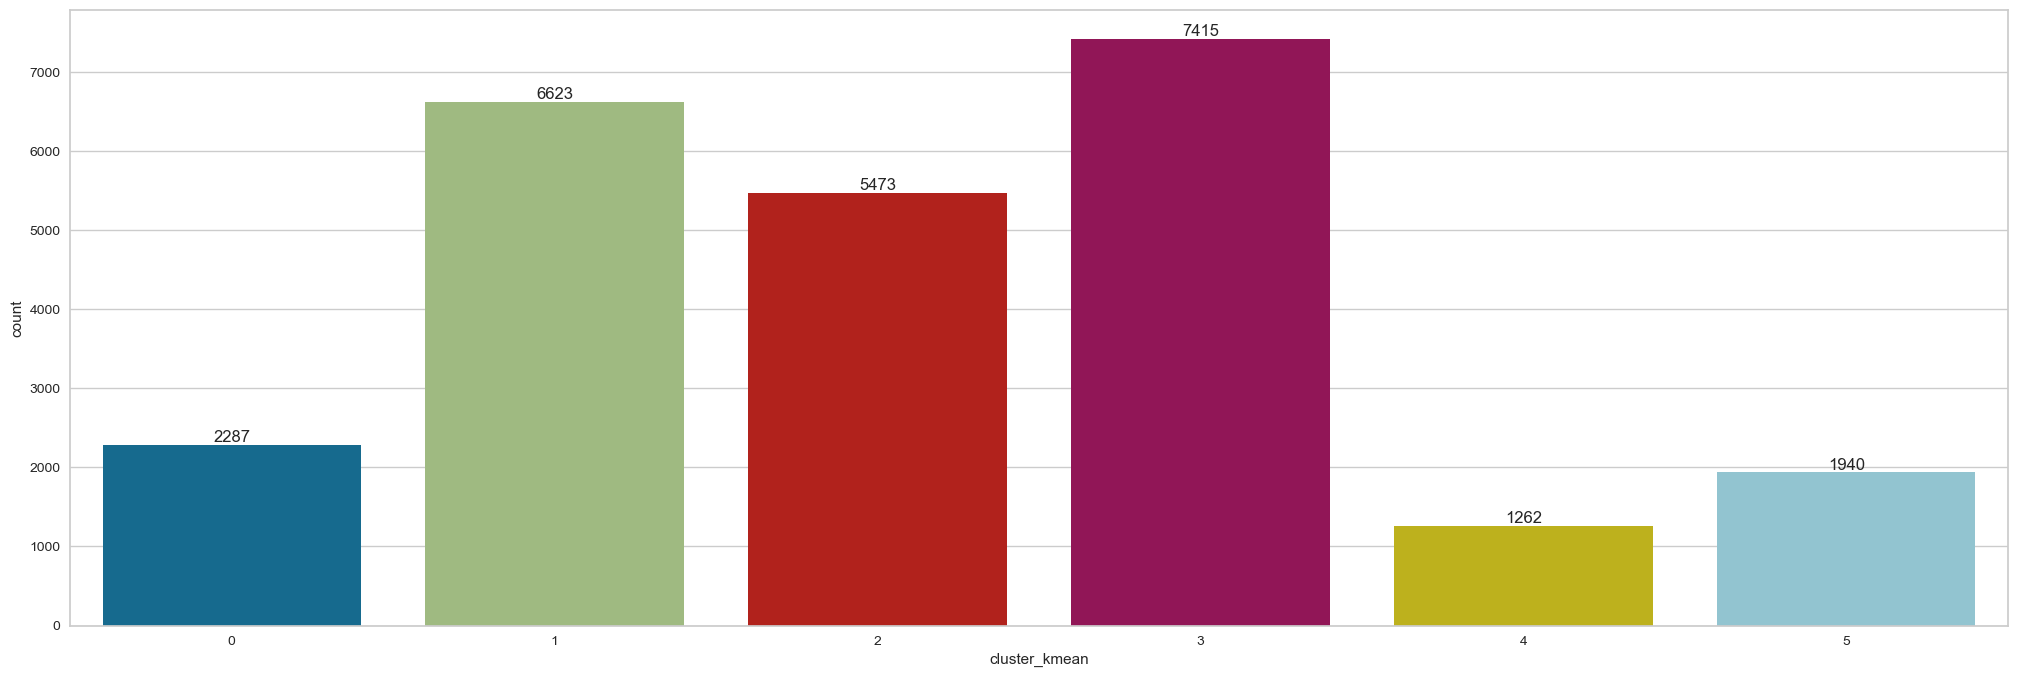

Silhouette Score: 0.193


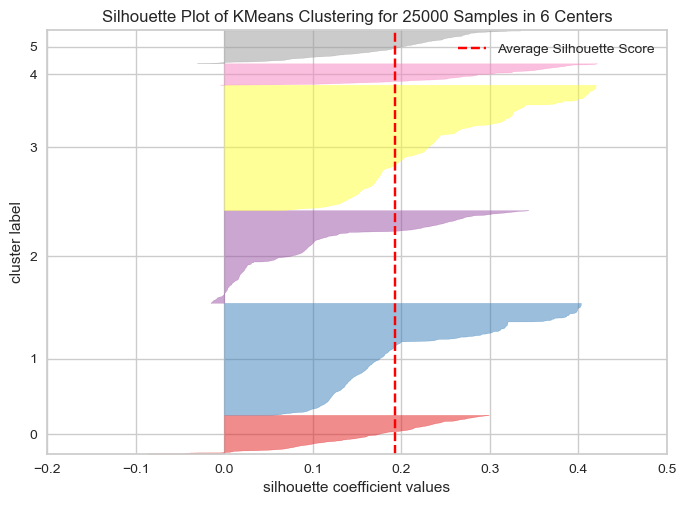

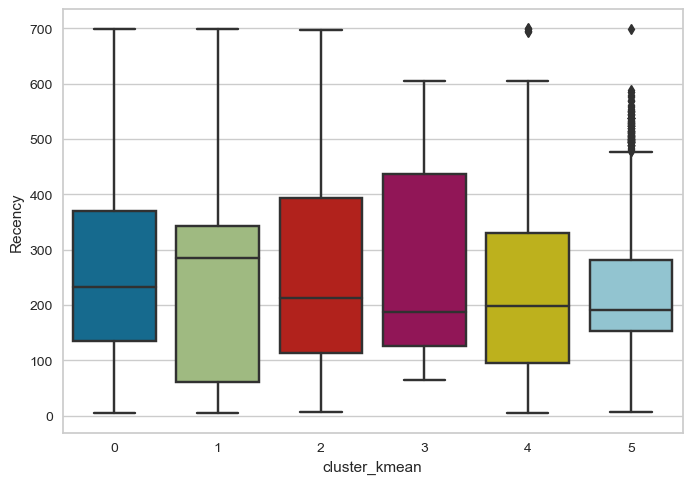

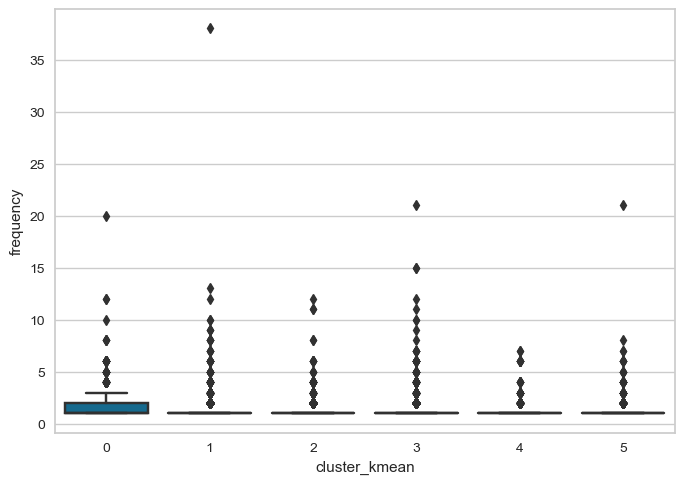

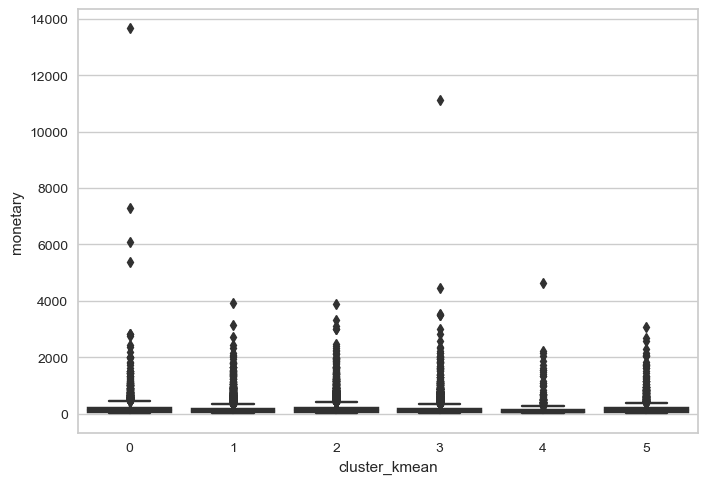

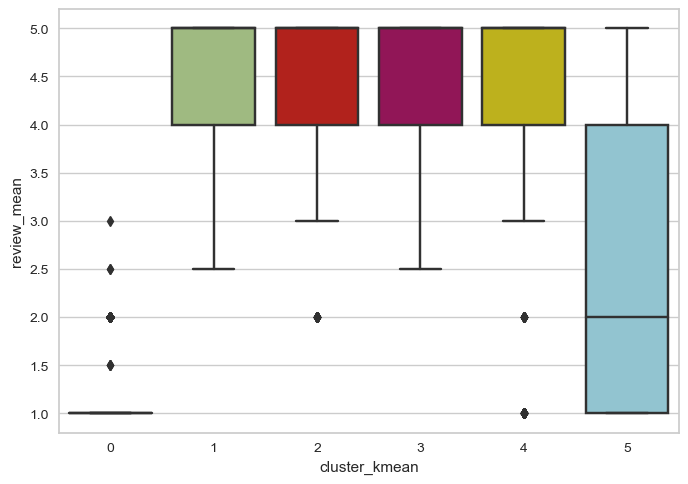

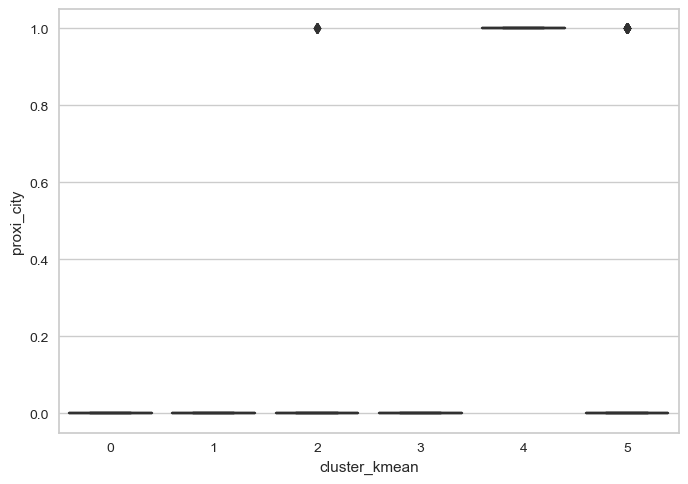

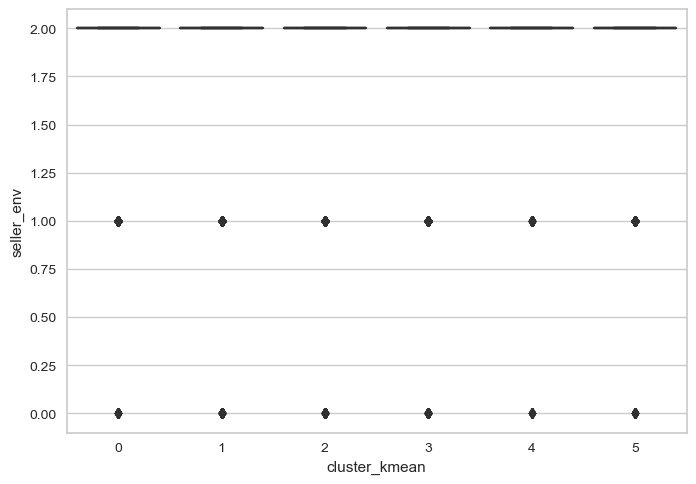

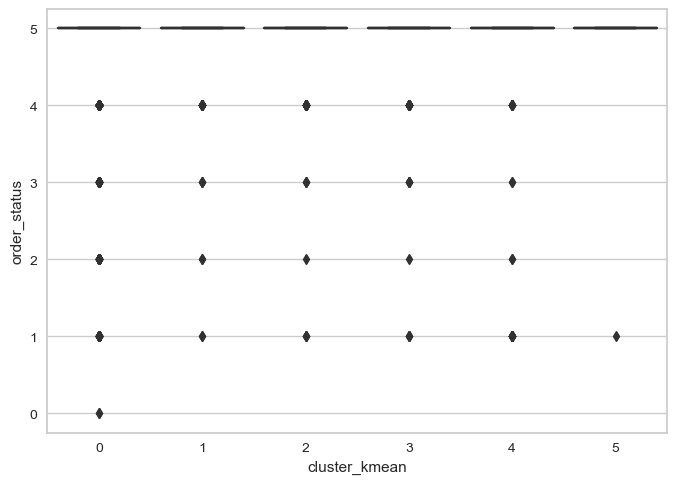

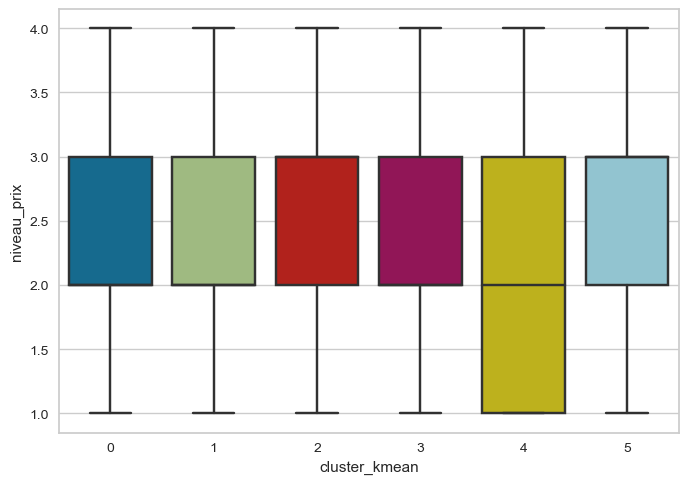

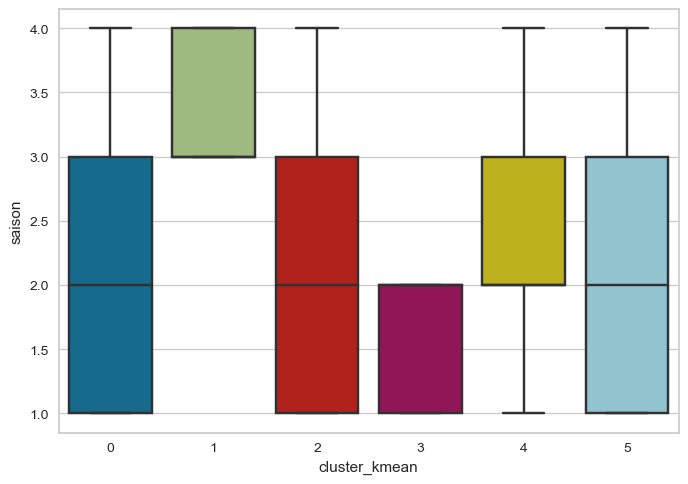

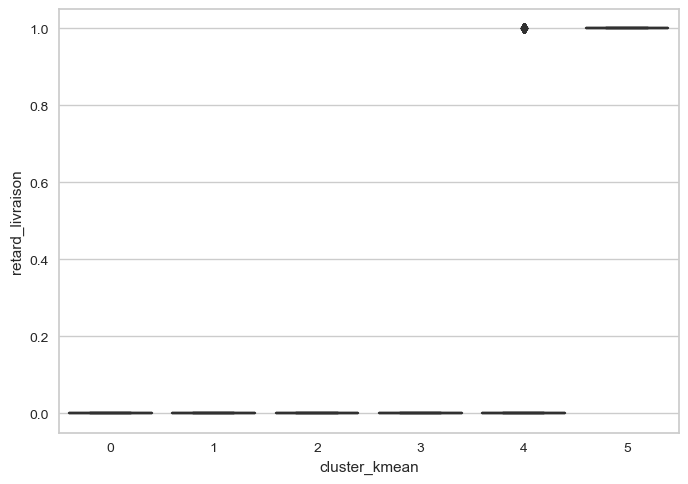

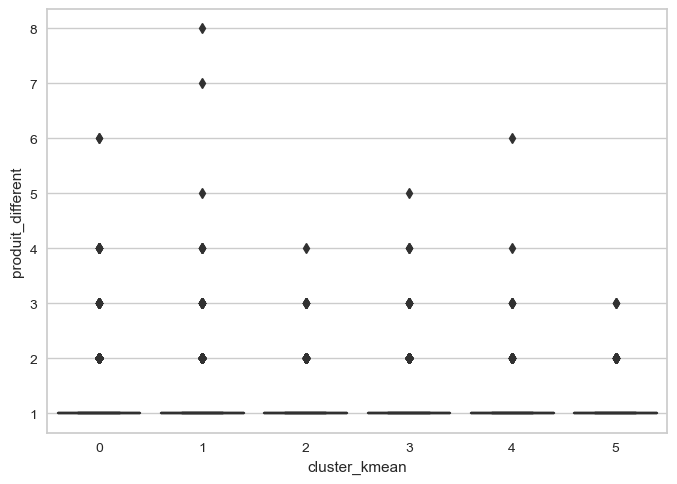

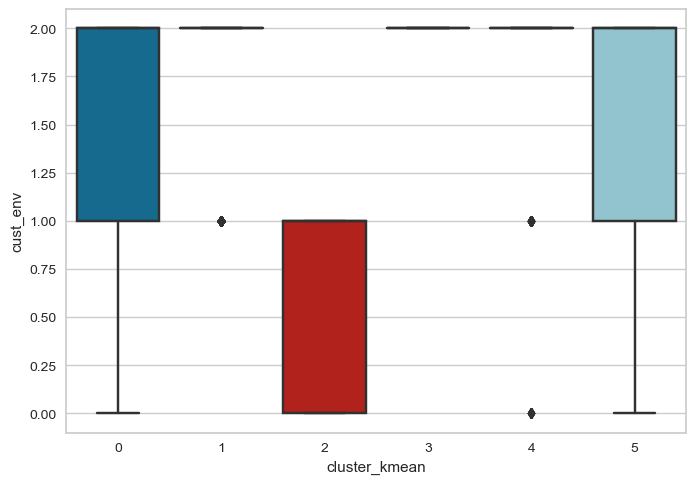

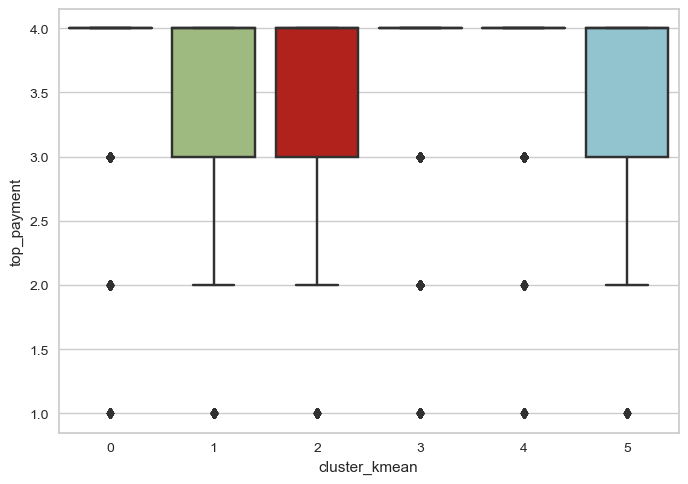

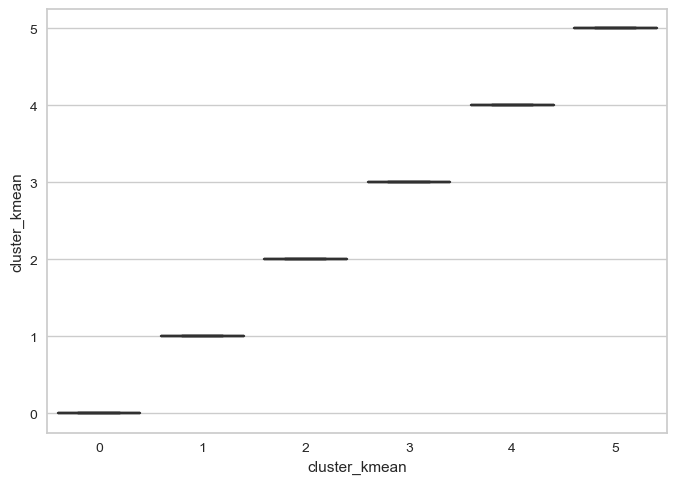

Recency  frequency  monetary  review_mean  proxi_city  seller_env  \
53115        62          1    140.03          5.0           0           2   
86867       411          4    746.96          5.0           0           2   
109536      442          1     55.09          4.0           0           2   
21437        20          1    289.41          4.0           0           2   
28487       109          1     79.29          5.0           0           1   
...         ...        ...       ...          ...         ...         ...   
10986        47          1     68.05          5.0           0           2   
92364       555          1     82.97          3.0           0           2   
85670        41          1    107.85          5.0           1           2   
15385       277          1     39.08          1.0           0           2   
23899       193          2    135.82          5.0           0           2   

        order_status  niveau_prix  saison  retard_livraison  \
53115              5            3       3                 0   
86867              5            4       3                 0   
109536             5            2       2                 0   
21437              5            4       3                 0   
28487              5            2       2                 0   
...              ...          ...     ...               ...   
10986              5            2       3                 0   
92364              5            2       1                 1   
85670              5            3       3                 0   
15385              5            1       4                 0   
23899              5            2       1                 0   

        produit_different  cust_env  top_payment  cluster_kmean  
53115                   1         1            4              2  
86867                   1         2            3              1  
109536                  1         2            4              3  
21437                   1         1            4              2  
28487                   1         2            4              3  
...                   ...       ...          ...            ...  
10986                   1         2            4              1  
92364                   1         2            4              5  
85670                   1         2            4              4  
15385                   1         2            3              0  
23899                   1         1            2              2  

[25000 rows x 14 columns]

In [26]:
kmeans(modele_13_indic_encode)

# Classification mixte (Kmeans et CAH)

https://colab.research.google.com/drive/11jgAEIubV6NUgH0WDiBhqBVsbZAvIlDB#scrollTo=PecZ5aBzV73q&uniqifier=3

In [27]:
def classification_mixte_dendrogram(modele, standardiser=MinMaxScaler(), axhline=1.5, name='baseline'):
    scaler = standardiser
    x_scaled = scaler.fit_transform(modele.iloc[:, :-1])

    kmeans_cah = KMeans(100, random_state=0)
    kmeans_cah.fit(x_scaled)
    modele['cluster_pred'] = kmeans_cah.fit_predict(x_scaled)

    df_cah = modele.set_index('cluster_pred')

    Z = linkage(kmeans_cah.cluster_centers_, method="ward")

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    _ = dendrogram(Z, ax=ax)

    plt.title("Hierarchical Clustering Dendrogram")
    plt.axhline(y=axhline, linewidth=1, color="black", linestyle="--")
    plt.show()
    df_z = pd.DataFrame(Z)

    df_z.to_csv(f"df_z_{name}.csv")

    return modele

In [28]:
def classification_mixte_cluster(modele, df_z, n_cluster=5):
    cah = AgglomerativeClustering(n_cluster, linkage="ward")
    cah.fit(modele)
    modele["cah_cluster"] = cah.labels_

    for i, col in enumerate(modele.columns):
        plt.figure(i)
        sns.boxplot(data=modele[:-2], x=modele['cah_cluster'], y=modele[col])
        plt.show()
    print(modele['cah_cluster'].value_counts())

    f, ax = plt.subplots(figsize=(25, 8))
    ax = sns.countplot(x="cah_cluster", data=modele)
    ax.bar_label(ax.containers[0])
    plt.show()
    return modele

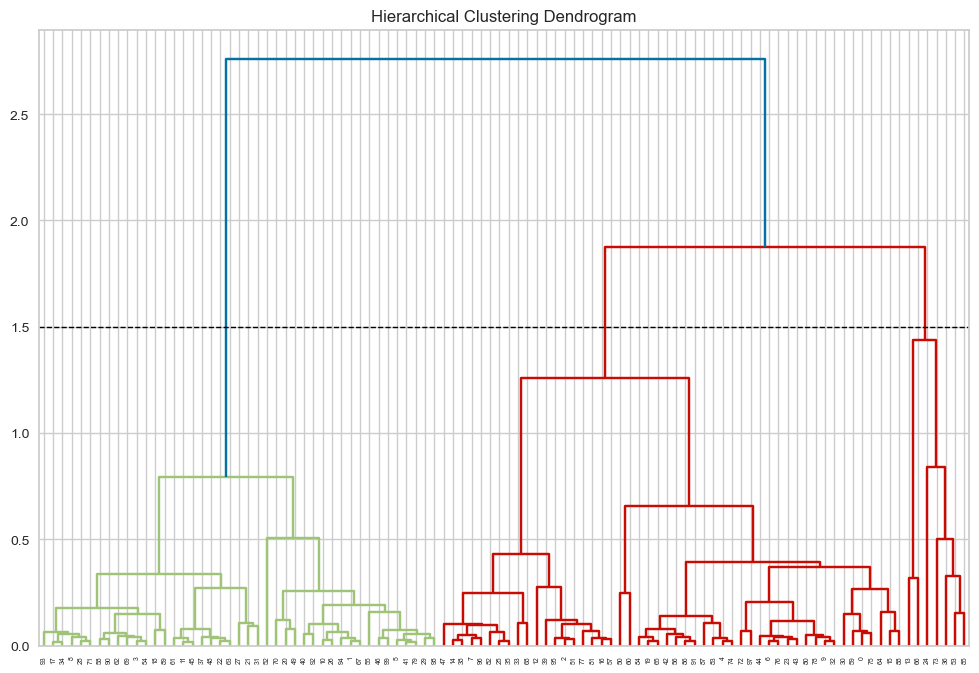

Recency  frequency  monetary  cluster_kmean  cluster_pred
53115        62          1    140.03              1            26
86867       411          4    746.96              0            15
109536      442          1     55.09              0            38
21437        20          1    289.41              1            79
28487       109          1     79.29              1            45
...         ...        ...       ...            ...           ...
10986        47          1     68.05              1            10
92364       555          1     82.97              0            57
85670        41          1    107.85              1            10
15385       277          1     39.08              2             6
23899       193          2    135.82              2            62

[25000 rows x 5 columns]

In [29]:
classification_mixte_dendrogram(
    modele_baseline_encode, standardiser=MinMaxScaler(), axhline=1.5, name='baseline')

In [30]:
df_z_modele_baseline = pd.read_csv('df_z_baseline.csv', index_col=[0])
df_z_modele_baseline.rename(columns={"3": "cluster_pred"}, inplace=True)
df_z_modele_baseline['cluster_pred'] = df_z_modele_baseline['cluster_pred'].astype(
    'int')
df_z_modele_baseline

0      1         2  cluster_pred
0    41.0   79.0  0.014320             2
1    17.0   34.0  0.018316             2
2    11.0   45.0  0.018392             2
3     1.0   67.0  0.019010             2
4     3.0   54.0  0.019742             2
..    ...    ...       ...           ...
94   24.0  190.0  0.839740             5
95  189.0  192.0  1.260299            50
96  184.0  194.0  1.438501             7
97  195.0  196.0  1.876507            57
98  193.0  197.0  2.760397           100

[99 rows x 4 columns]

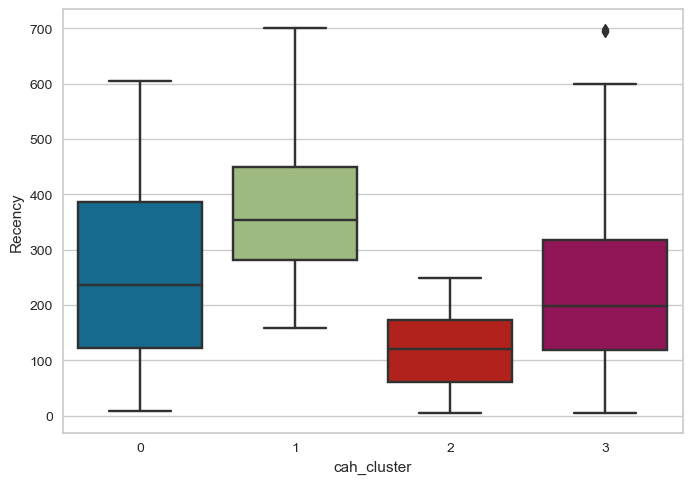

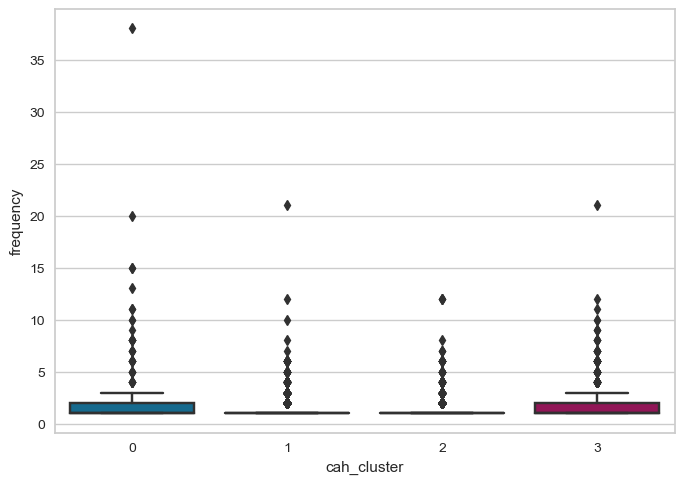

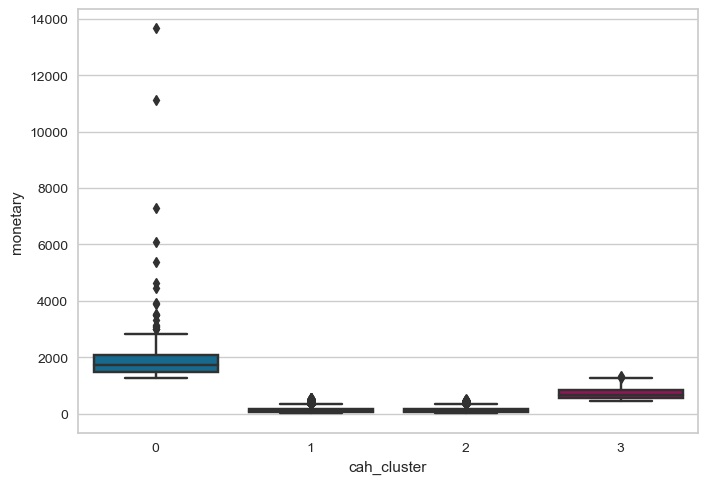

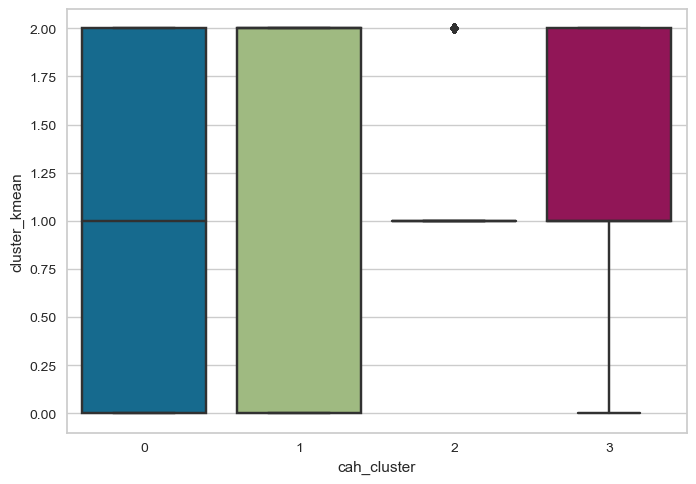

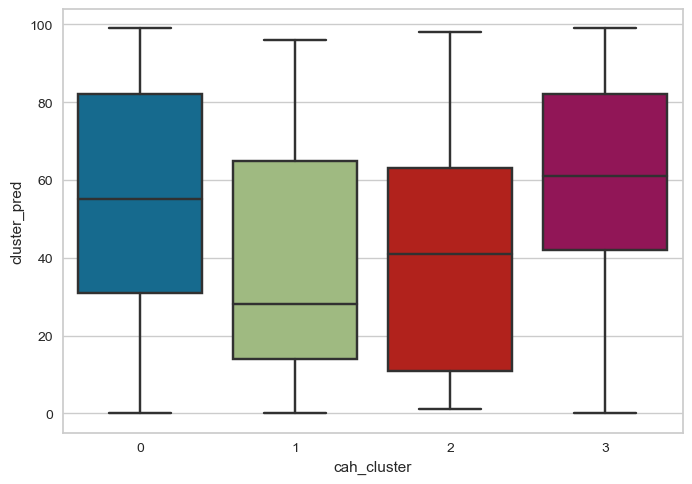

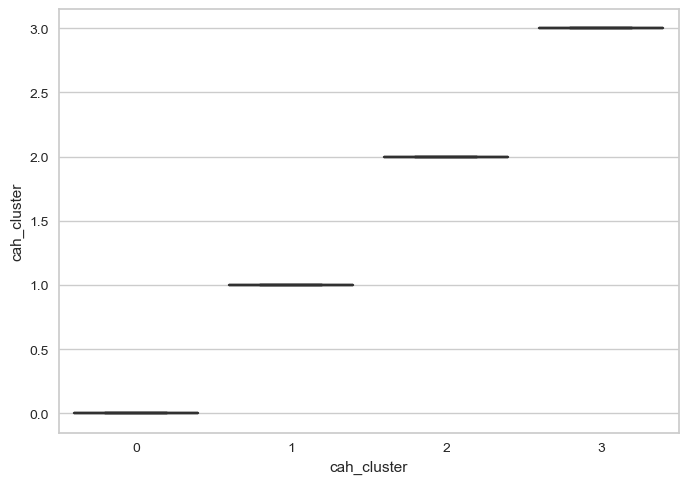

1    12102
2    11662
3     1032
0      204
Name: cah_cluster, dtype: int64


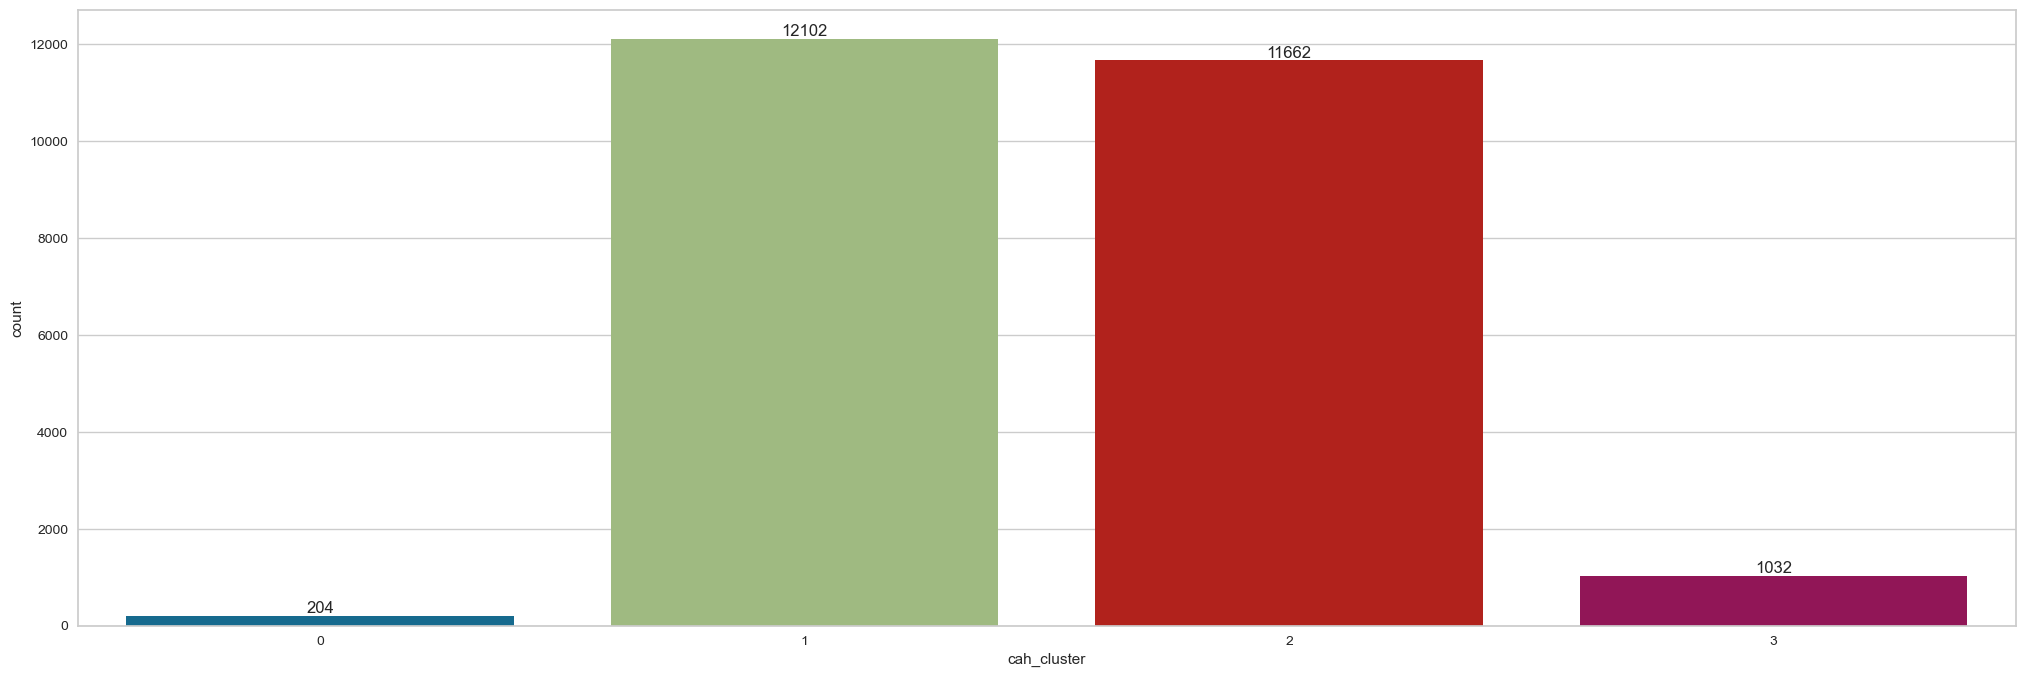

Recency  frequency  monetary  cluster_kmean  cluster_pred  cah_cluster
53115        62          1    140.03              1            26            2
86867       411          4    746.96              0            15            3
109536      442          1     55.09              0            38            1
21437        20          1    289.41              1            79            2
28487       109          1     79.29              1            45            2
...         ...        ...       ...            ...           ...          ...
10986        47          1     68.05              1            10            2
92364       555          1     82.97              0            57            1
85670        41          1    107.85              1            10            2
15385       277          1     39.08              2             6            1
23899       193          2    135.82              2            62            2

[25000 rows x 6 columns]

In [31]:
classification_mixte_cluster(
    modele_baseline_encode, df_z_modele_baseline, n_cluster=4)

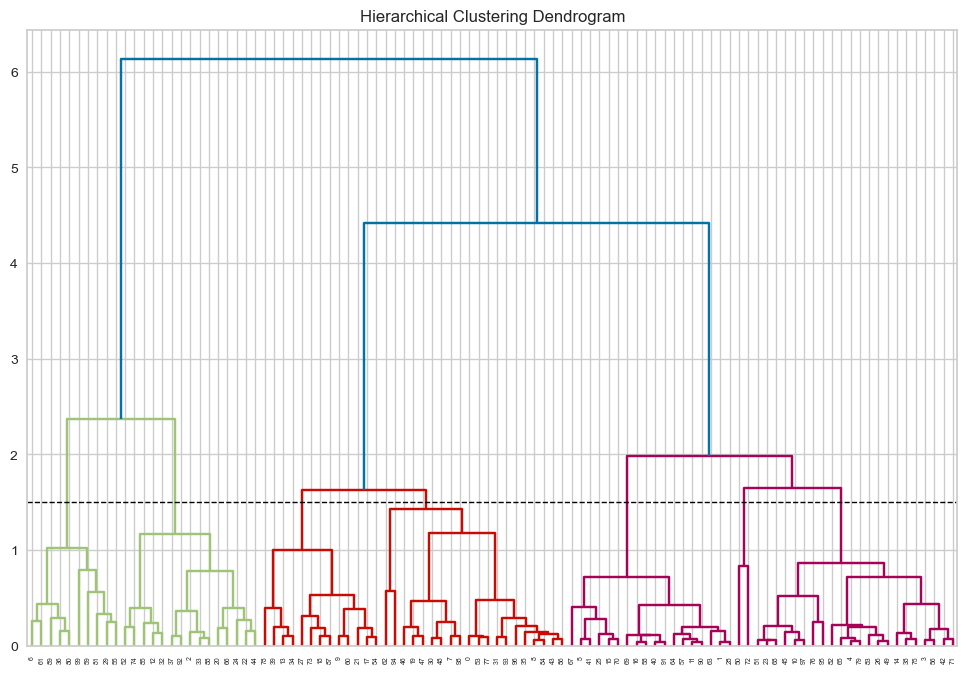

Recency  frequency  monetary  review_mean  proxi_city  cluster_kmean  \
53115        62          1    140.03          5.0           0              3   
86867       411          4    746.96          5.0           0              0   
109536      442          1     55.09          4.0           0              0   
21437        20          1    289.41          4.0           0              3   
28487       109          1     79.29          5.0           0              3   
...         ...        ...       ...          ...         ...            ...   
10986        47          1     68.05          5.0           0              3   
92364       555          1     82.97          3.0           0              0   
85670        41          1    107.85          5.0           1              2   
15385       277          1     39.08          1.0           0              1   
23899       193          2    135.82          5.0           0              3   

        cluster_pred  
53115             57  
86867             79  
109536            38  
21437              5  
28487             28  
...              ...  
10986             11  
92364             21  
85670             33  
15385             53  
23899             40  

[25000 rows x 7 columns]

In [32]:
classification_mixte_dendrogram(
    modele_5_indic_encode, standardiser=MinMaxScaler(), axhline=1.5, name='5_indic')

In [33]:
df_z_modele_5 = pd.read_csv('df_z_5_indic.csv', index_col=[0])
df_z_modele_5.rename(columns={"3": "cluster_pred"}, inplace=True)
df_z_modele_5['cluster_pred'] = df_z_modele_5['cluster_pred'].astype('int')
df_z_modele_5

0      1         2  cluster_pred
0    11.0   90.0  0.033138             2
1    16.0   58.0  0.035780             2
2    40.0   91.0  0.037779             2
3     1.0   28.0  0.038595             2
4     4.0   79.0  0.045552             2
..    ...    ...       ...           ...
94  186.0  187.0  1.651979            24
95  182.0  194.0  1.983944            42
96  189.0  190.0  2.371602            25
97  193.0  195.0  4.417444            75
98  196.0  197.0  6.134885           100

[99 rows x 4 columns]

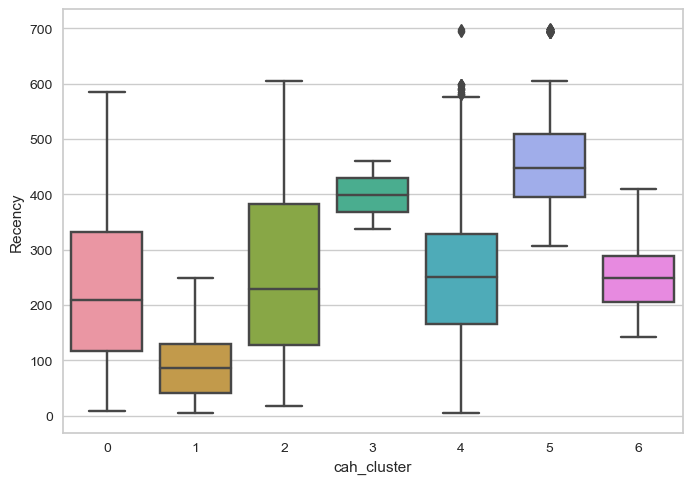

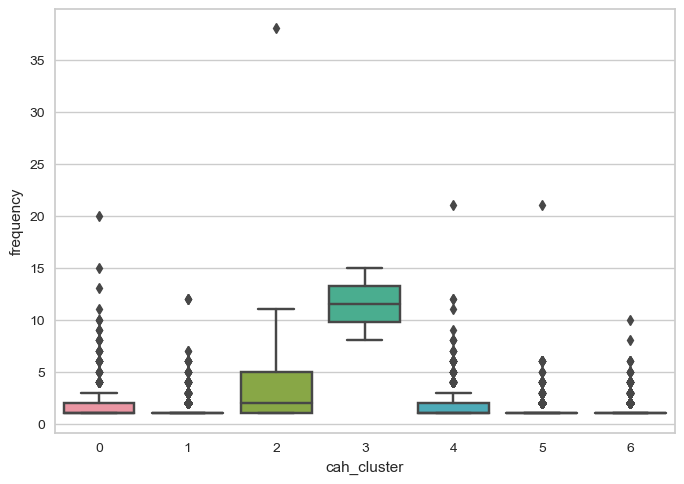

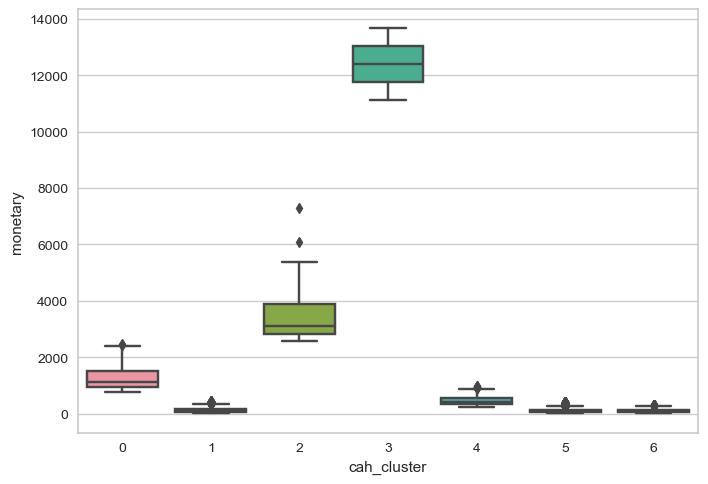

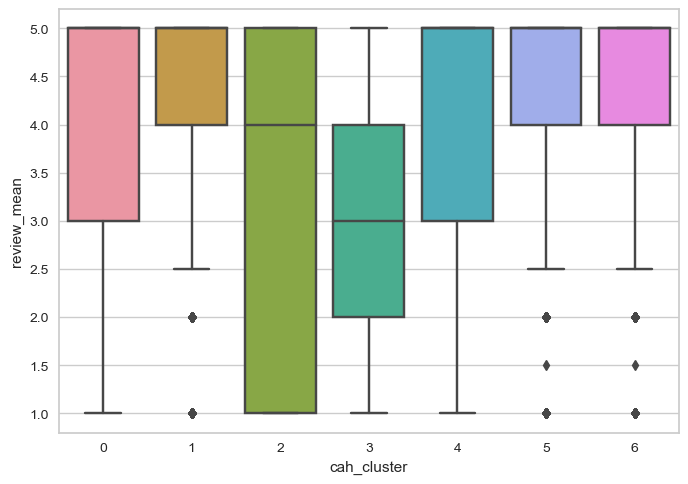

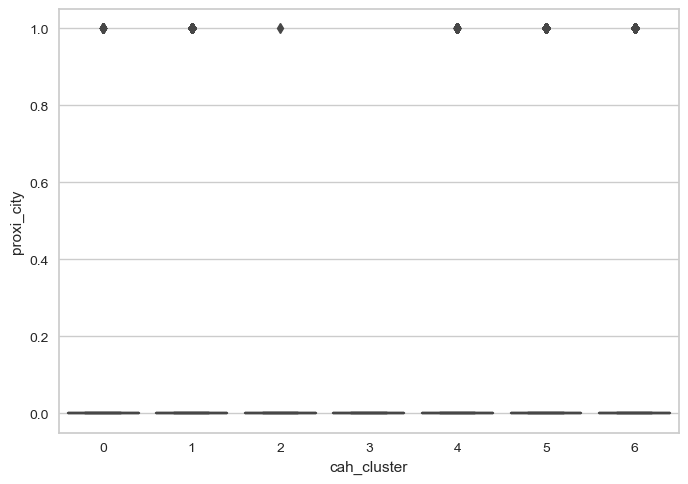

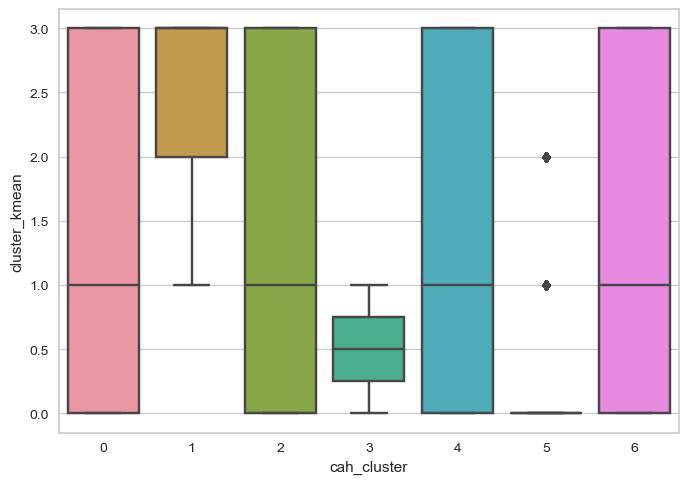

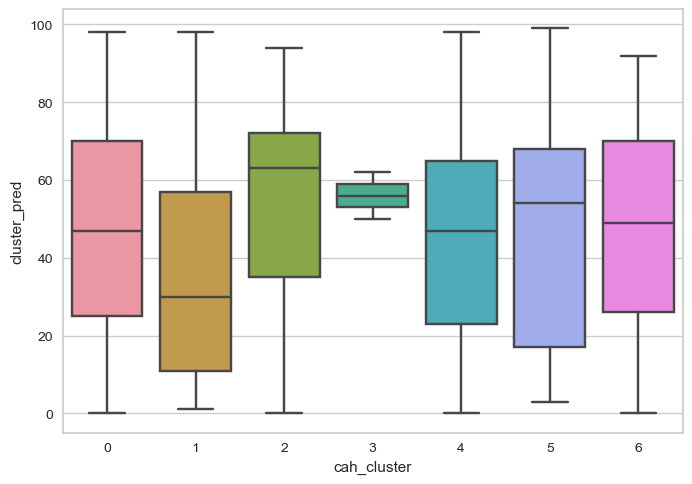

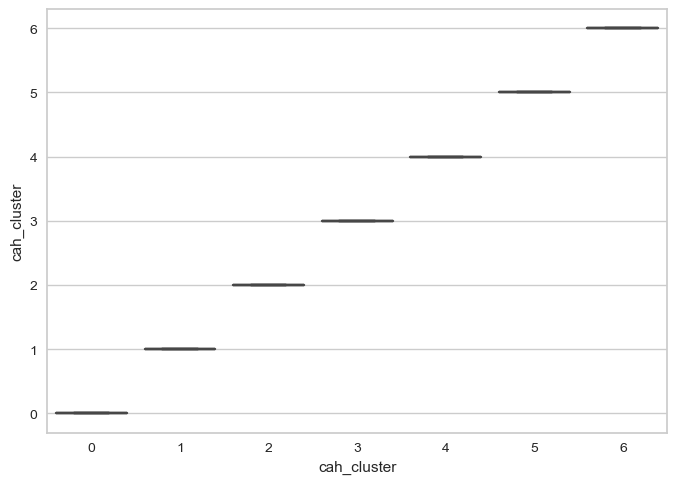

1    8382
6    8049
5    5907
4    2184
0     451
2      25
3       2
Name: cah_cluster, dtype: int64


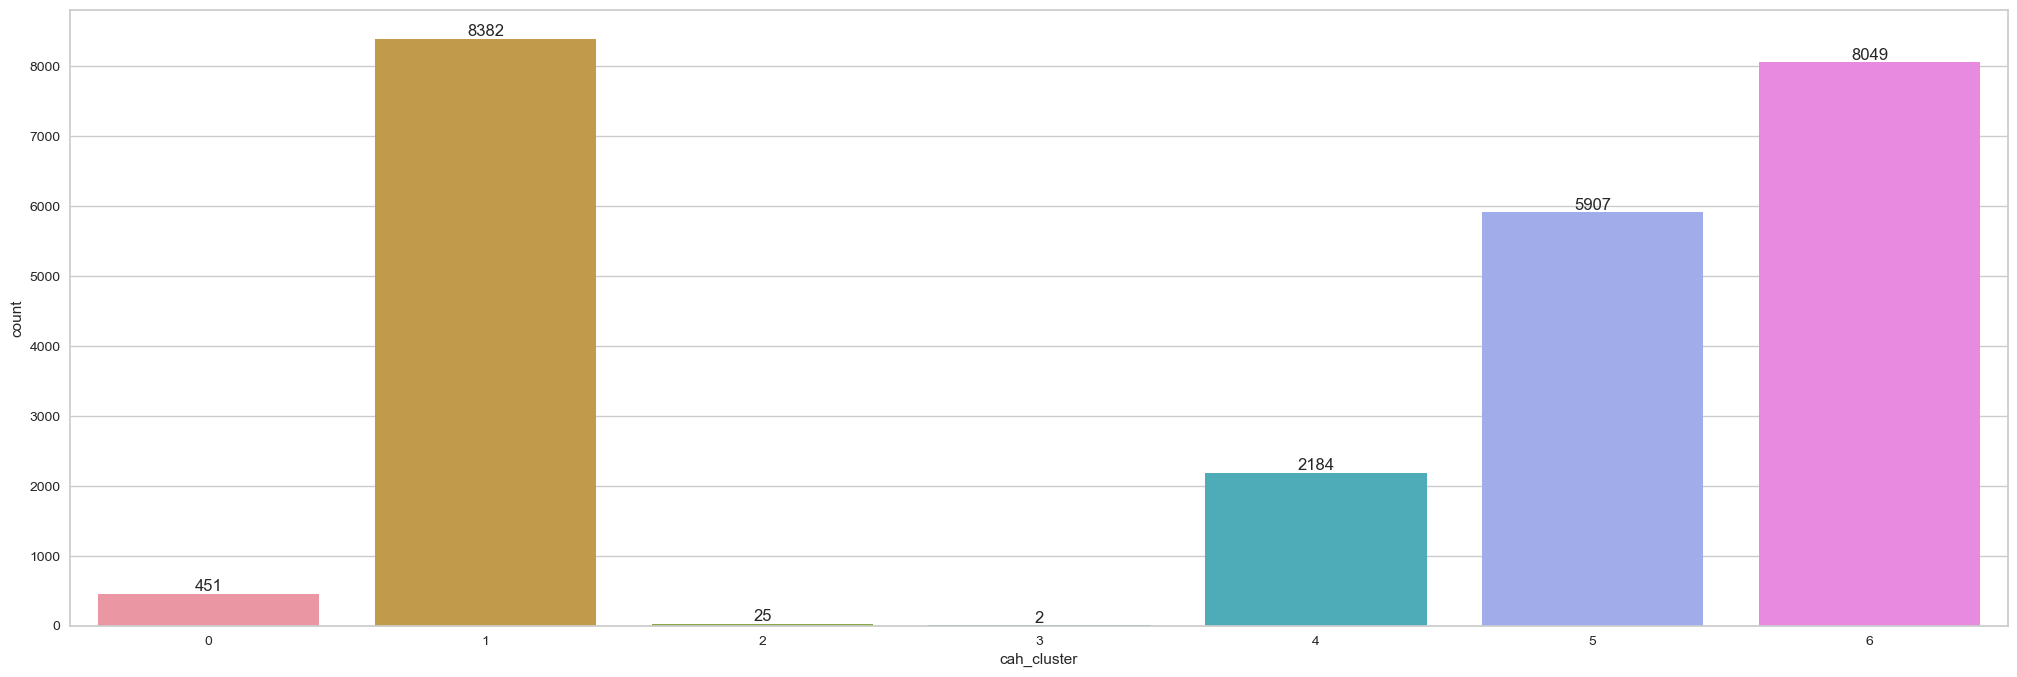

Recency  frequency  monetary  review_mean  proxi_city  cluster_kmean  \
53115        62          1    140.03          5.0           0              3   
86867       411          4    746.96          5.0           0              0   
109536      442          1     55.09          4.0           0              0   
21437        20          1    289.41          4.0           0              3   
28487       109          1     79.29          5.0           0              3   
...         ...        ...       ...          ...         ...            ...   
10986        47          1     68.05          5.0           0              3   
92364       555          1     82.97          3.0           0              0   
85670        41          1    107.85          5.0           1              2   
15385       277          1     39.08          1.0           0              1   
23899       193          2    135.82          5.0           0              3   

        cluster_pred  cah_cluster  
53115             57            1  
86867             79            4  
109536            38            5  
21437              5            1  
28487             28            1  
...              ...          ...  
10986             11            1  
92364             21            5  
85670             33            1  
15385             53            6  
23899             40            6  

[25000 rows x 8 columns]

In [34]:
classification_mixte_cluster(modele_5_indic_encode, df_z_modele_5, n_cluster=7)

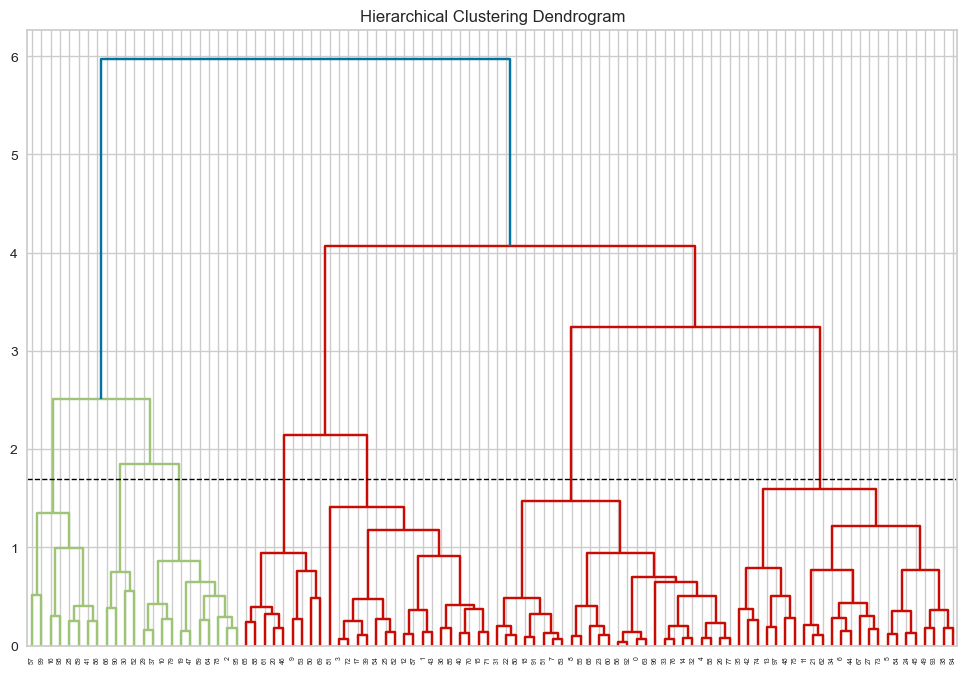

Recency  frequency  monetary  review_mean  proxi_city  seller_env  \
53115        62          1    140.03          5.0           0           2   
86867       411          4    746.96          5.0           0           2   
109536      442          1     55.09          4.0           0           2   
21437        20          1    289.41          4.0           0           2   
28487       109          1     79.29          5.0           0           1   
...         ...        ...       ...          ...         ...         ...   
10986        47          1     68.05          5.0           0           2   
92364       555          1     82.97          3.0           0           2   
85670        41          1    107.85          5.0           1           2   
15385       277          1     39.08          1.0           0           2   
23899       193          2    135.82          5.0           0           2   

        cluster_kmean  cluster_pred  
53115               4            92  
86867               1             7  
109536              1            80  
21437               4             8  
28487               3            21  
...               ...           ...  
10986               4            92  
92364               1             1  
85670               2            47  
15385               0            40  
23899               4            32  

[25000 rows x 8 columns]

In [35]:
classification_mixte_dendrogram(
    modele_6_indic_encode, standardiser=MinMaxScaler(), axhline=1.7, name='6_indic')

In [36]:
df_z_modele_6 = pd.read_csv('df_z_6_indic.csv', index_col=[0])
df_z_modele_6.rename(columns={"3": "cluster_pred"}, inplace=True)
df_z_modele_6['cluster_pred'] = df_z_modele_6['cluster_pred'].astype('int')
df_z_modele_6

0      1         2  cluster_pred
0    56.0   92.0  0.040152             2
1    33.0   76.0  0.061767             2
2     0.0   63.0  0.062055             2
3     3.0   72.0  0.069694             2
4     7.0   83.0  0.070088             2
..    ...    ...       ...           ...
94  184.0  190.0  2.147763            27
95  189.0  193.0  2.510324            23
96  191.0  192.0  3.244682            50
97  194.0  196.0  4.062644            77
98  195.0  197.0  5.972750           100

[99 rows x 4 columns]

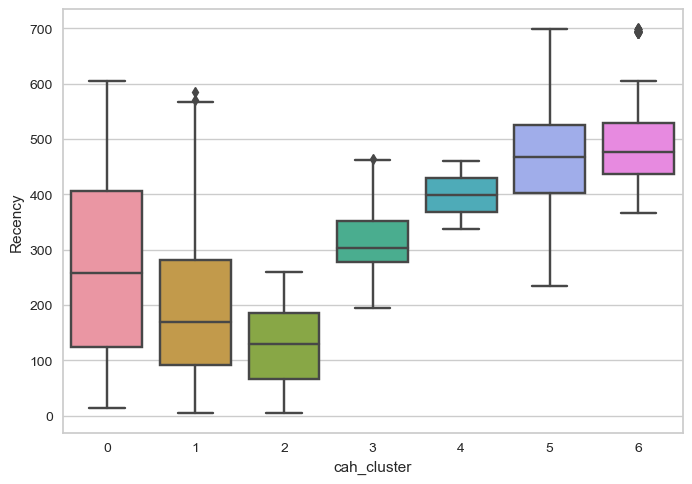

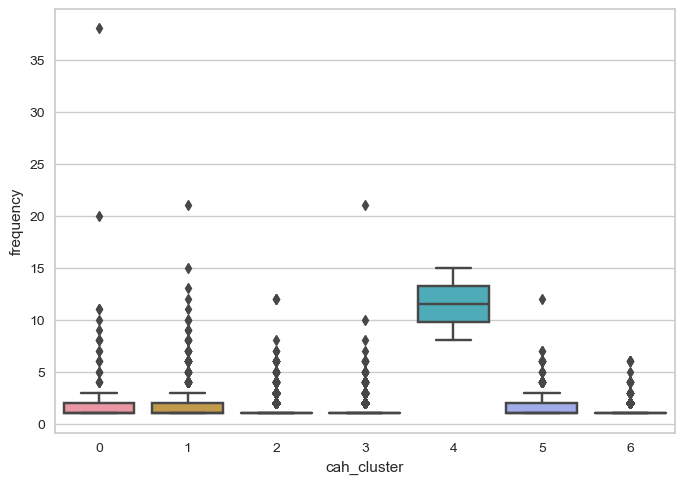

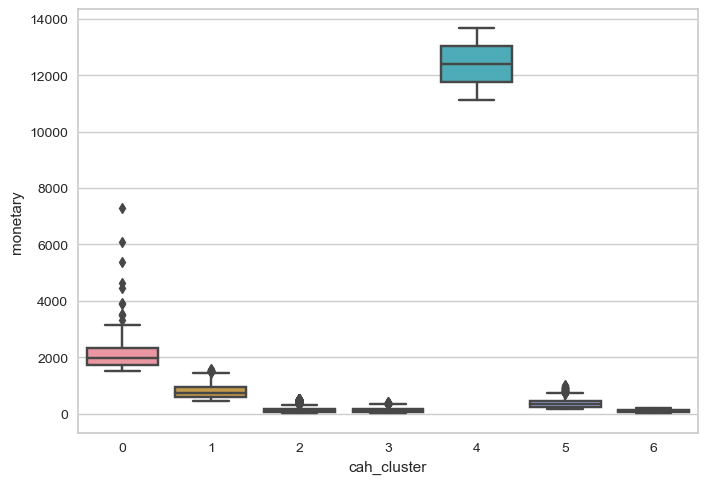

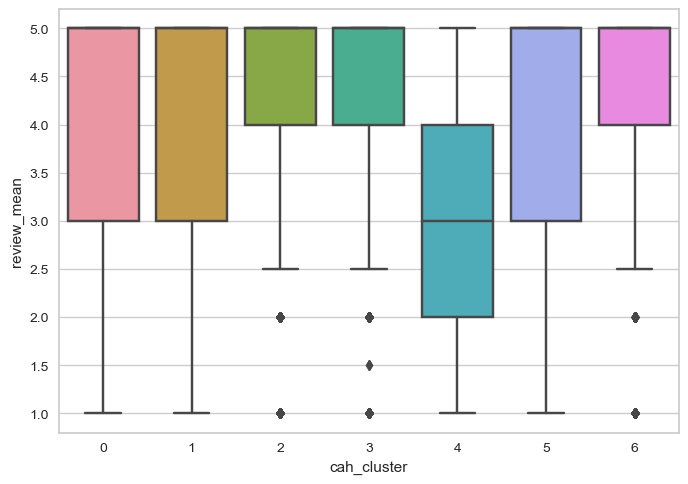

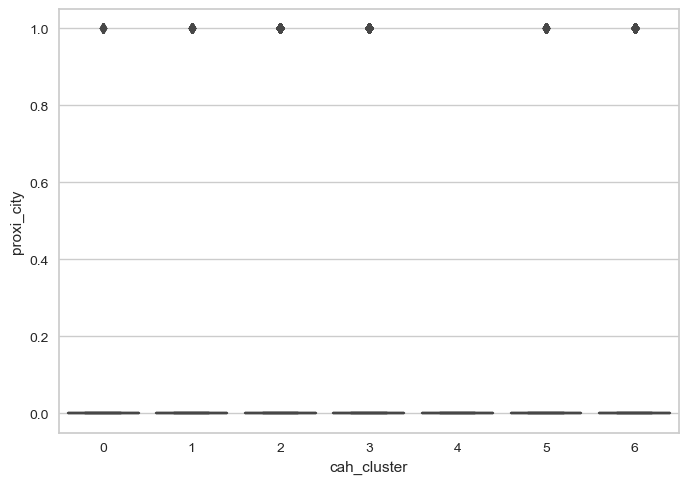

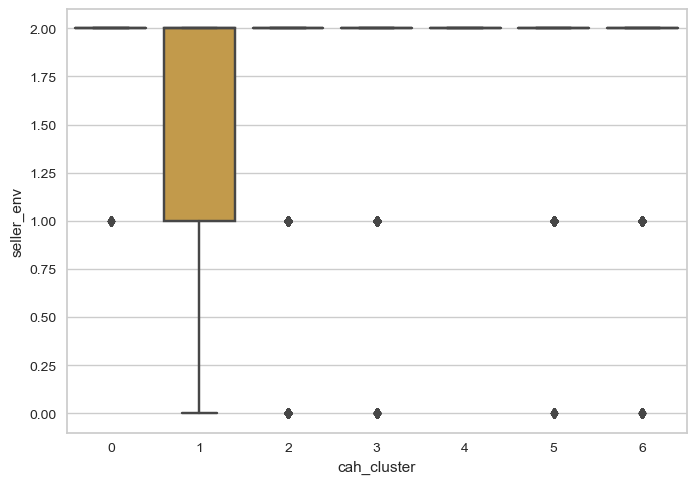

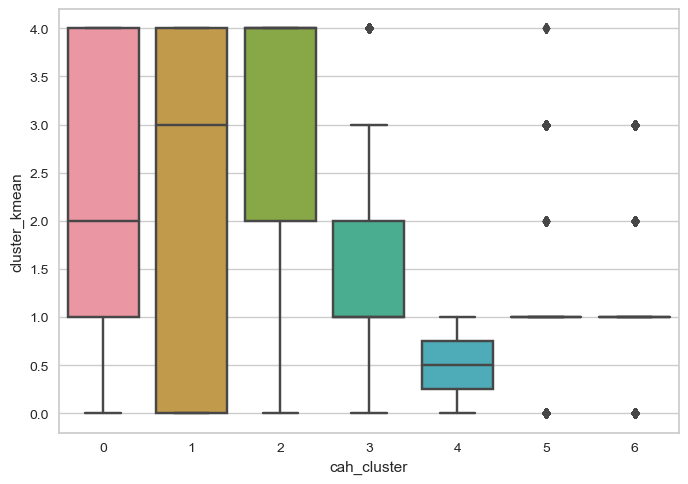

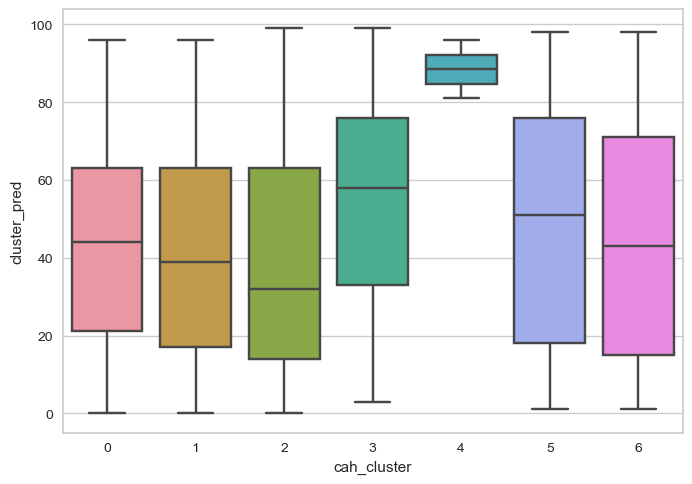

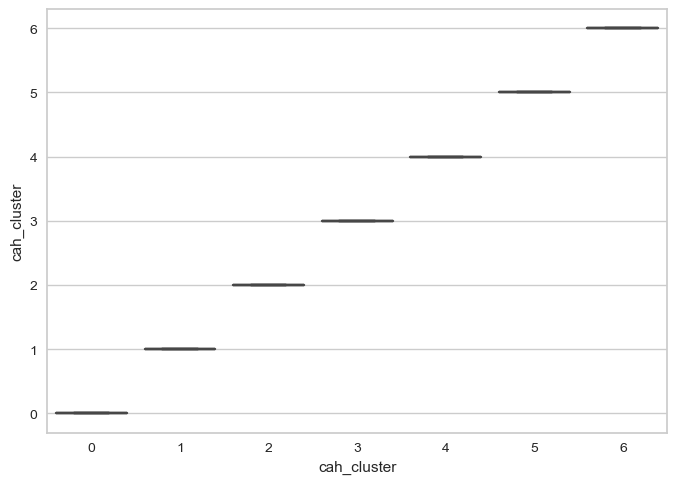

2    12730
3     6420
6     3550
5     1271
1      897
0      130
4        2
Name: cah_cluster, dtype: int64


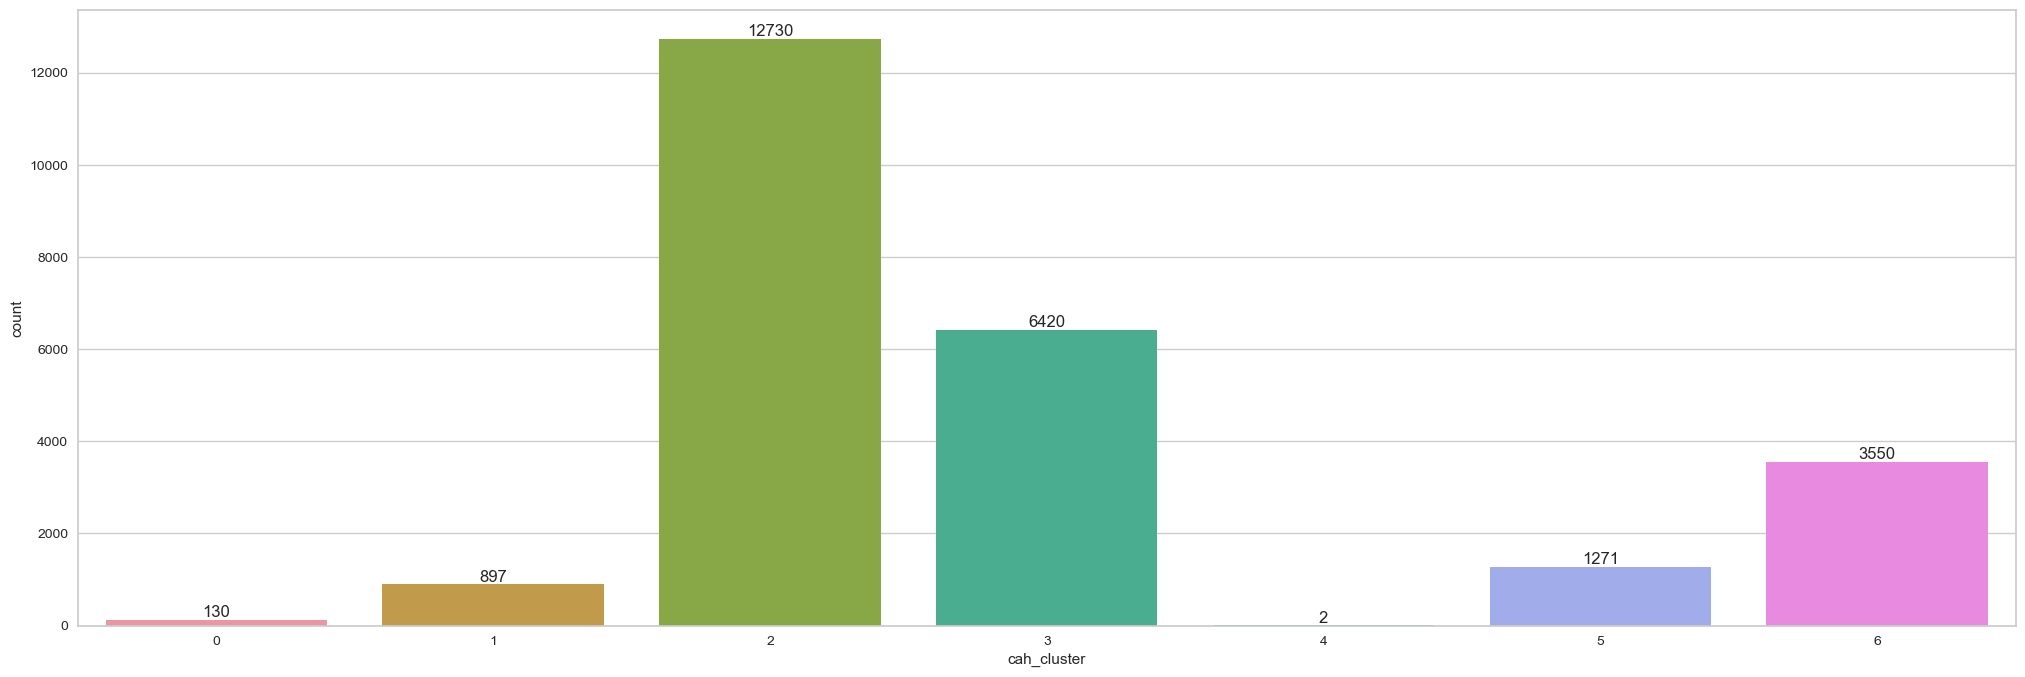

Recency  frequency  monetary  review_mean  proxi_city  seller_env  \
53115        62          1    140.03          5.0           0           2   
86867       411          4    746.96          5.0           0           2   
109536      442          1     55.09          4.0           0           2   
21437        20          1    289.41          4.0           0           2   
28487       109          1     79.29          5.0           0           1   
...         ...        ...       ...          ...         ...         ...   
10986        47          1     68.05          5.0           0           2   
92364       555          1     82.97          3.0           0           2   
85670        41          1    107.85          5.0           1           2   
15385       277          1     39.08          1.0           0           2   
23899       193          2    135.82          5.0           0           2   

        cluster_kmean  cluster_pred  cah_cluster  
53115               4            92            2  
86867               1             7            5  
109536              1            80            6  
21437               4             8            2  
28487               3            21            2  
...               ...           ...          ...  
10986               4            92            2  
92364               1             1            6  
85670               2            47            2  
15385               0            40            3  
23899               4            32            2  

[25000 rows x 9 columns]

In [37]:
classification_mixte_cluster(modele_6_indic_encode, df_z_modele_6, n_cluster=7)

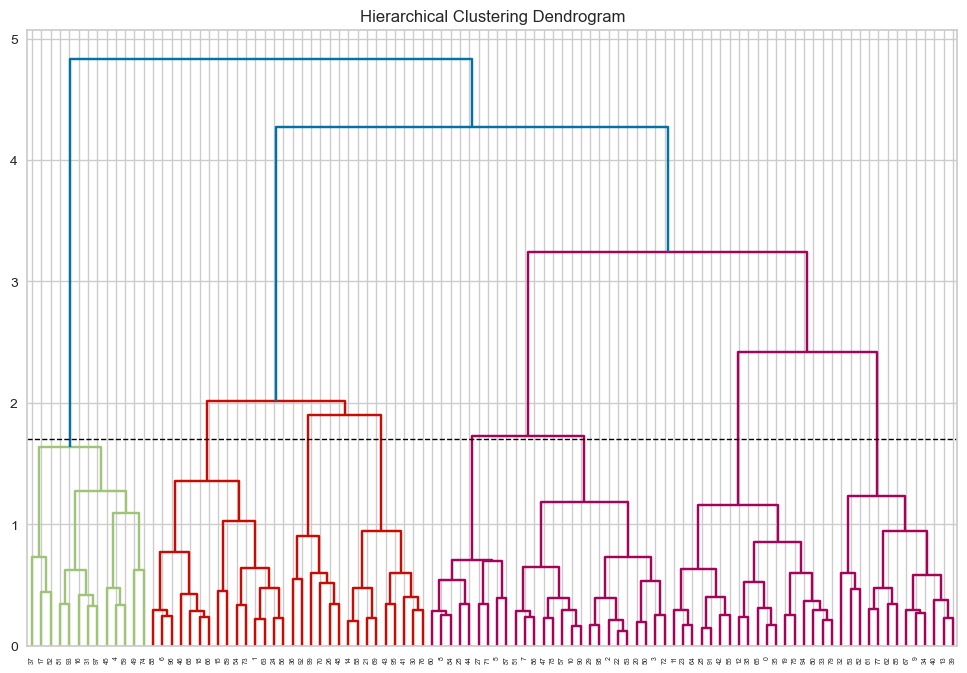

Recency  frequency  monetary  review_mean  proxi_city  seller_env  \
53115        62          1    140.03          5.0           0           2   
86867       411          4    746.96          5.0           0           2   
109536      442          1     55.09          4.0           0           2   
21437        20          1    289.41          4.0           0           2   
28487       109          1     79.29          5.0           0           1   
...         ...        ...       ...          ...         ...         ...   
10986        47          1     68.05          5.0           0           2   
92364       555          1     82.97          3.0           0           2   
85670        41          1    107.85          5.0           1           2   
15385       277          1     39.08          1.0           0           2   
23899       193          2    135.82          5.0           0           2   

        niveau_prix  cluster_kmean  cluster_pred  
53115             3              0            28  
86867             4              0            38  
109536            2              1            47  
21437             4              0            11  
28487             2              1             8  
...             ...            ...           ...  
10986             2              1             2  
92364             2              2            30  
85670             3              3             4  
15385             1              2            21  
23899             2              1            22  

[25000 rows x 9 columns]

In [38]:
classification_mixte_dendrogram(
    modele_7_indic_encode, standardiser=MinMaxScaler(), axhline=1.7, name='7_indic')

In [39]:
df_z_modele_7 = pd.read_csv('df_z_7_indic.csv', index_col=[0])
df_z_modele_7.rename(columns={"3": "cluster_pred"}, inplace=True)
df_z_modele_7['cluster_pred'] = df_z_modele_7['cluster_pred'].astype('int')
df_z_modele_7

0      1         2  cluster_pred
0    22.0   83.0  0.117834             2
1    28.0   91.0  0.142776             2
2    10.0   90.0  0.157963             2
3    29.0   98.0  0.166885             2
4    23.0   64.0  0.168842             2
..    ...    ...       ...           ...
94  190.0  193.0  2.018371            30
95  186.0  188.0  2.415110            31
96  192.0  195.0  3.242975            57
97  194.0  196.0  4.268872            87
98  191.0  197.0  4.833454           100

[99 rows x 4 columns]

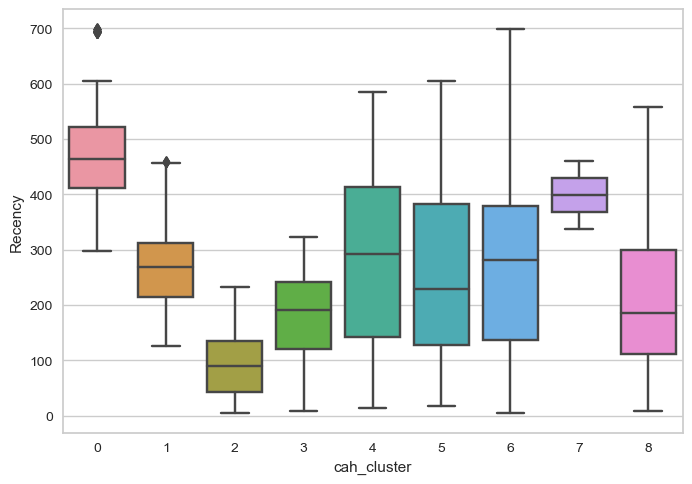

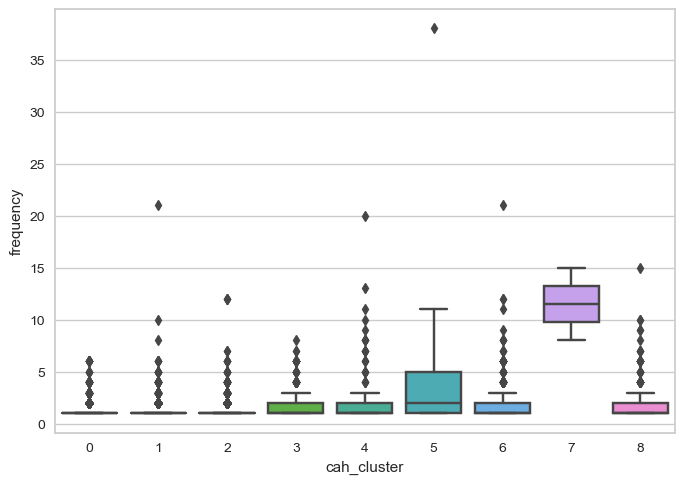

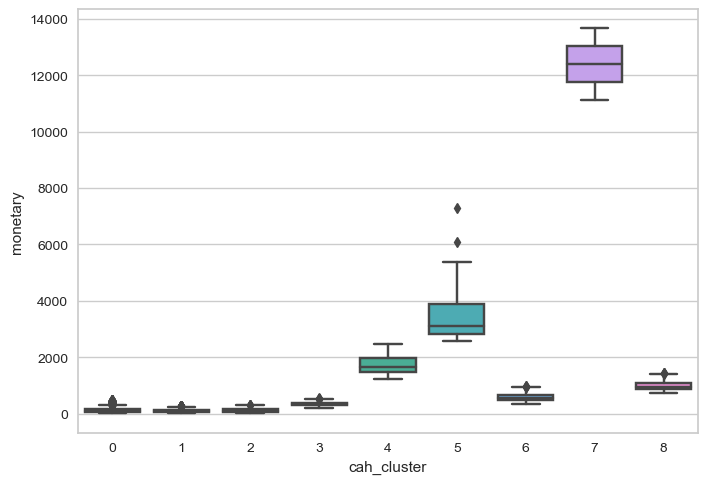

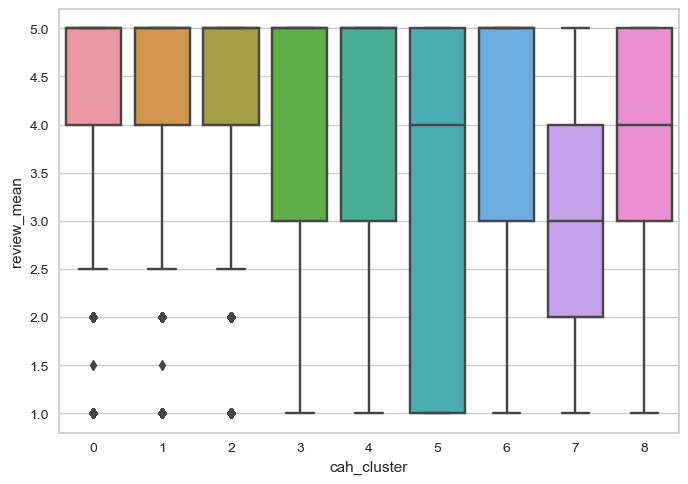

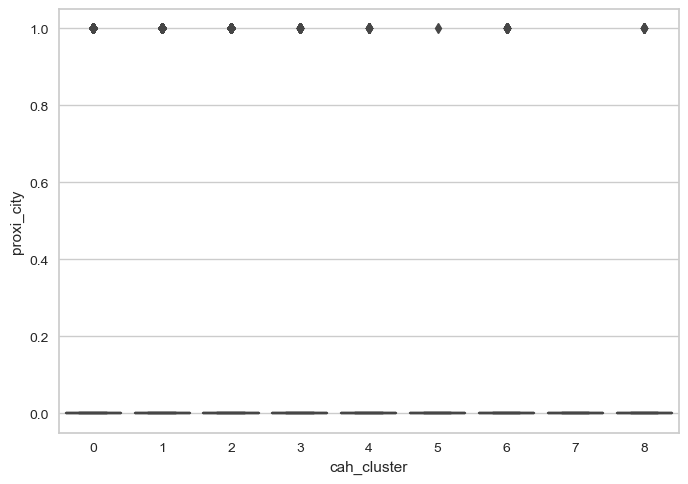

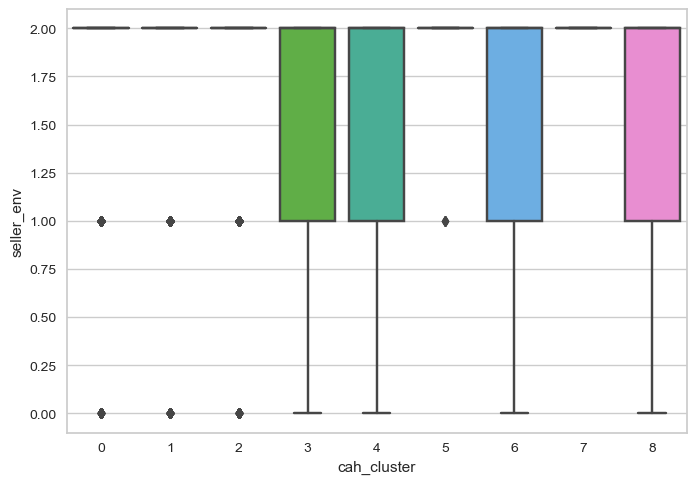

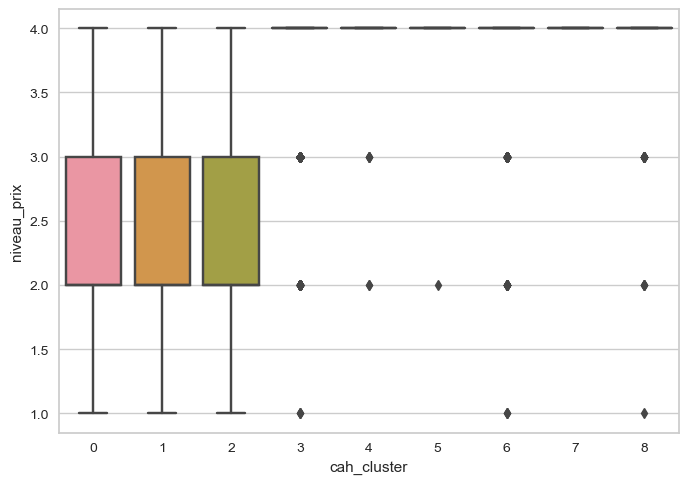

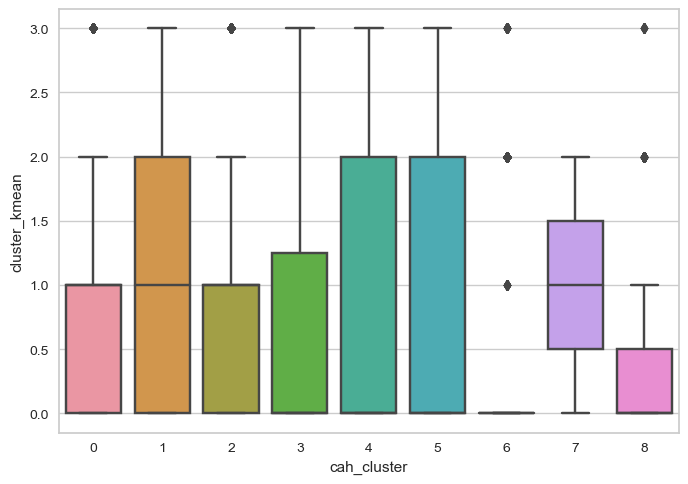

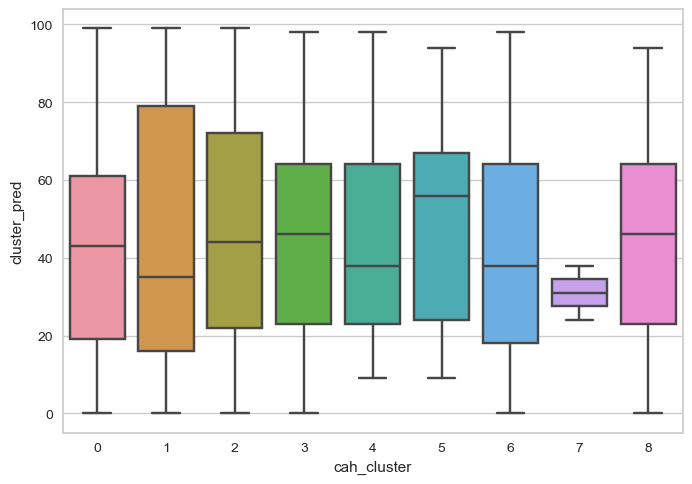

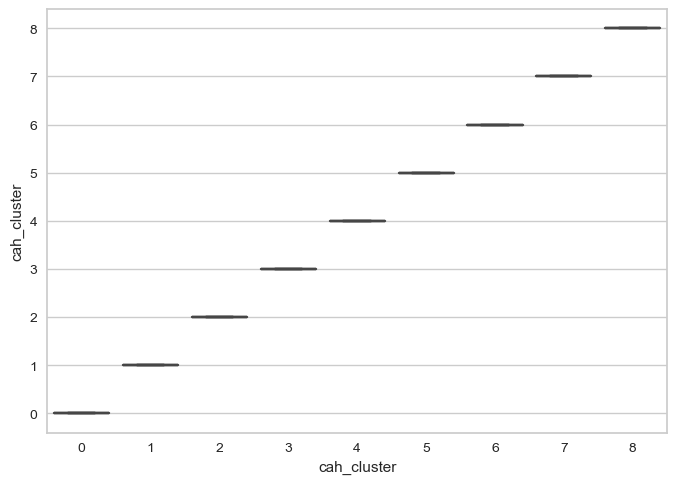

1    8753
2    8315
0    5122
3    1296
6    1009
8     315
4     163
5      25
7       2
Name: cah_cluster, dtype: int64


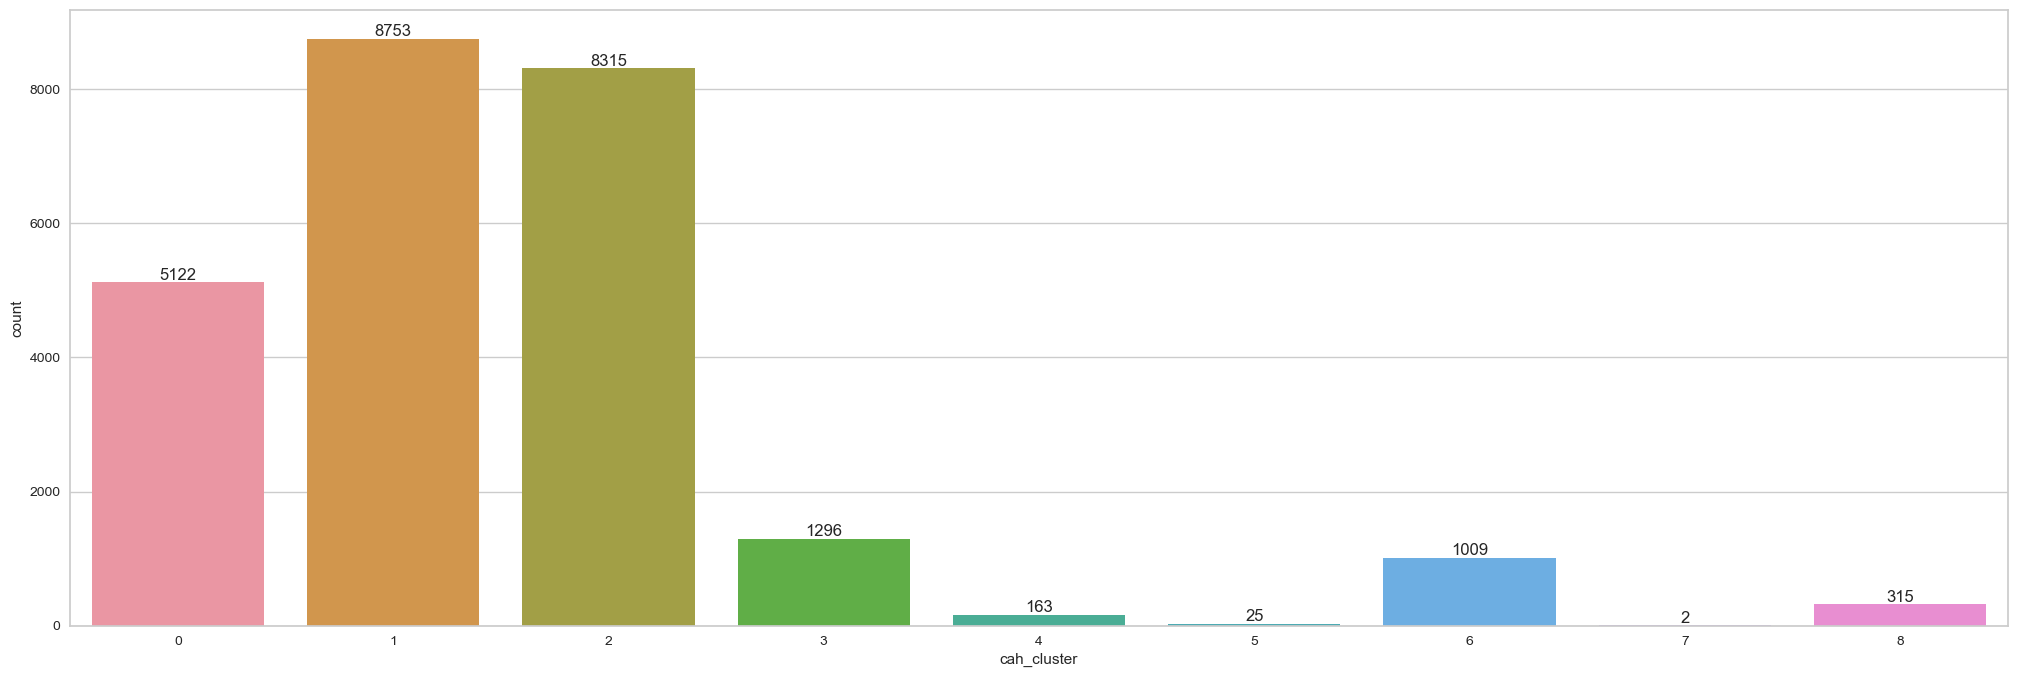

Recency  frequency  monetary  review_mean  proxi_city  seller_env  \
53115        62          1    140.03          5.0           0           2   
86867       411          4    746.96          5.0           0           2   
109536      442          1     55.09          4.0           0           2   
21437        20          1    289.41          4.0           0           2   
28487       109          1     79.29          5.0           0           1   
...         ...        ...       ...          ...         ...         ...   
10986        47          1     68.05          5.0           0           2   
92364       555          1     82.97          3.0           0           2   
85670        41          1    107.85          5.0           1           2   
15385       277          1     39.08          1.0           0           2   
23899       193          2    135.82          5.0           0           2   

        niveau_prix  cluster_kmean  cluster_pred  cah_cluster  
53115             3              0            28            2  
86867             4              0            38            6  
109536            2              1            47            0  
21437             4              0            11            2  
28487             2              1             8            2  
...             ...            ...           ...          ...  
10986             2              1             2            2  
92364             2              2            30            0  
85670             3              3             4            2  
15385             1              2            21            1  
23899             2              1            22            1  

[25000 rows x 10 columns]

In [40]:
classification_mixte_cluster(modele_7_indic_encode, df_z_modele_7, n_cluster=9)

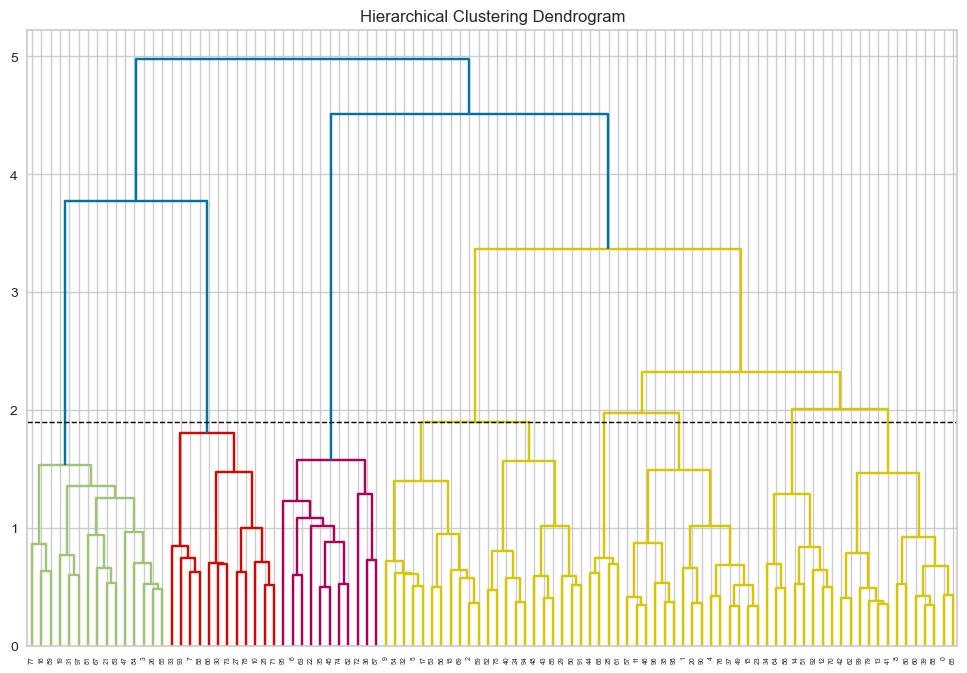

Recency  frequency  monetary  review_mean  proxi_city  seller_env  \
53115        62          1    140.03          5.0           0           2   
86867       411          4    746.96          5.0           0           2   
109536      442          1     55.09          4.0           0           2   
21437        20          1    289.41          4.0           0           2   
28487       109          1     79.29          5.0           0           1   
...         ...        ...       ...          ...         ...         ...   
10986        47          1     68.05          5.0           0           2   
92364       555          1     82.97          3.0           0           2   
85670        41          1    107.85          5.0           1           2   
15385       277          1     39.08          1.0           0           2   
23899       193          2    135.82          5.0           0           2   

        order_status  niveau_prix  saison  retard_livraison  \
53115              5            3       3                 0   
86867              5            4       3                 0   
109536             5            2       2                 0   
21437              5            4       3                 0   
28487              5            2       2                 0   
...              ...          ...     ...               ...   
10986              5            2       3                 0   
92364              5            2       1                 1   
85670              5            3       3                 0   
15385              5            1       4                 0   
23899              5            2       1                 0   

        produit_different  cust_env  top_payment  cluster_kmean  cluster_pred  
53115                   1         1            4              2            80  
86867                   1         2            3              1            99  
109536                  1         2            4              3            46  
21437                   1         1            4              2            85  
28487                   1         2            4              3            14  
...                   ...       ...          ...            ...           ...  
10986                   1         2            4              1             8  
92364                   1         2            4              5            10  
85670                   1         2            4              4             6  
15385                   1         2            3              0            31  
23899                   1         1            2              2            61  

[25000 rows x 15 columns]

In [41]:
classification_mixte_dendrogram(
    modele_13_indic_encode, standardiser=MinMaxScaler(), axhline=1.9, name='13_indic')

In [42]:
df_z_modele_13 = pd.read_csv('df_z_13_indic.csv', index_col=[0])
df_z_modele_13.rename(columns={"3": "cluster_pred"}, inplace=True)
df_z_modele_13['cluster_pred'] = df_z_modele_13['cluster_pred'].astype('int')
df_z_modele_13

0      1         2  cluster_pred
0    37.0   49.0  0.333393             2
1    15.0   23.0  0.333840             2
2    11.0   46.0  0.341703             2
3    39.0   88.0  0.345654             2
4    13.0   41.0  0.351254             2
..    ...    ...       ...           ...
94  192.0  193.0  2.317498            40
95  191.0  194.0  3.366605            62
96  187.0  190.0  3.770258            27
97  189.0  195.0  4.508911            73
98  196.0  197.0  4.978706           100

[99 rows x 4 columns]

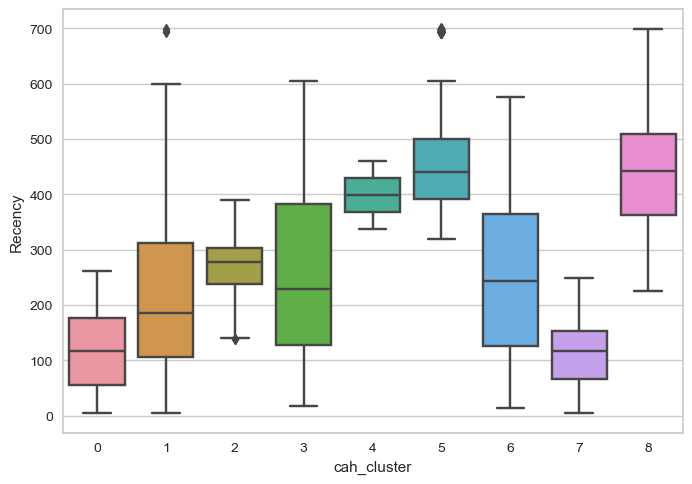

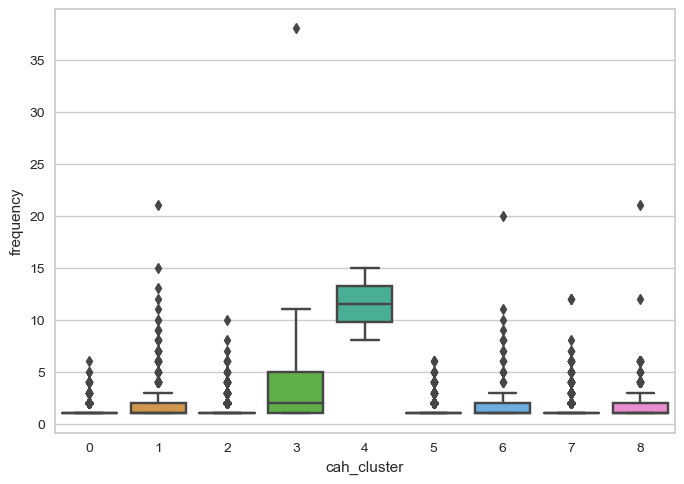

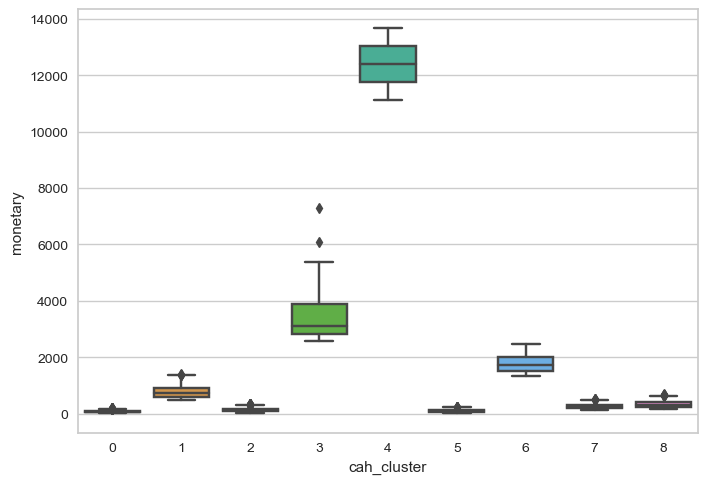

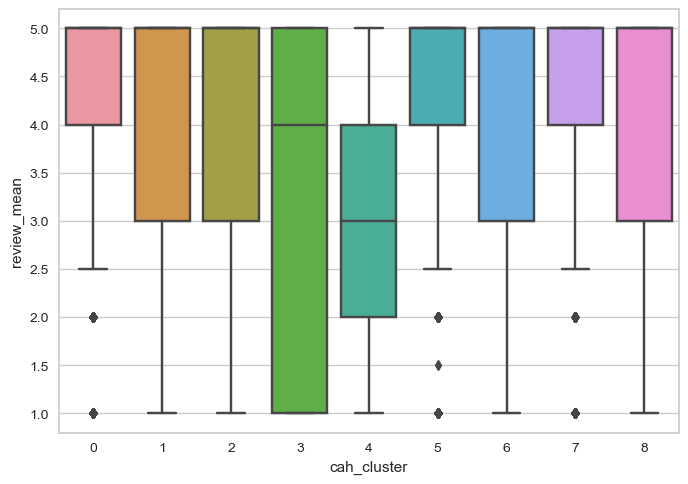

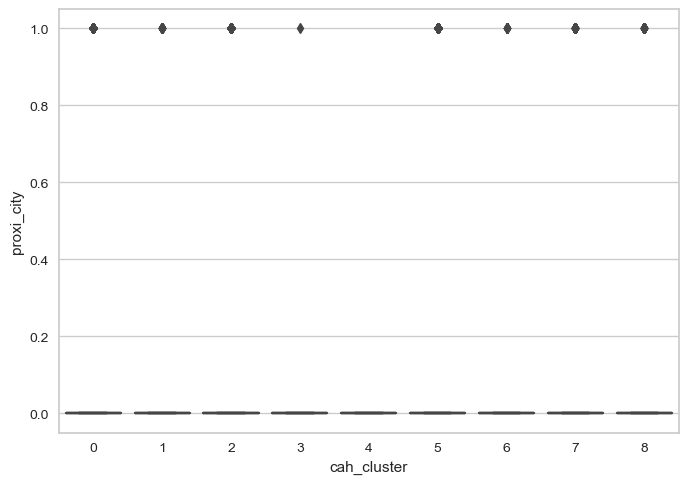

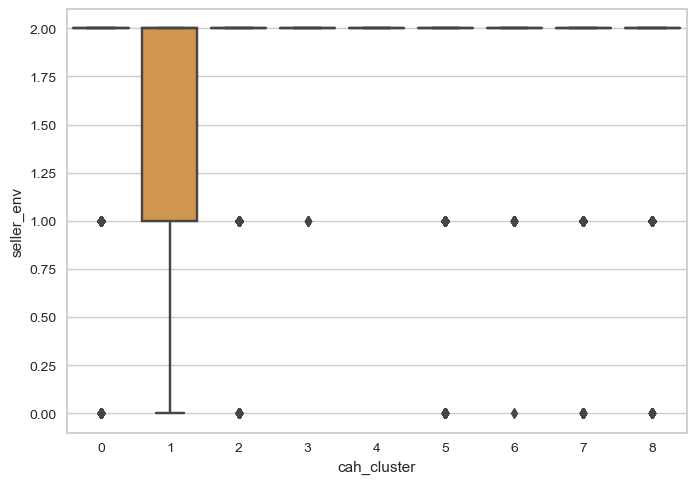

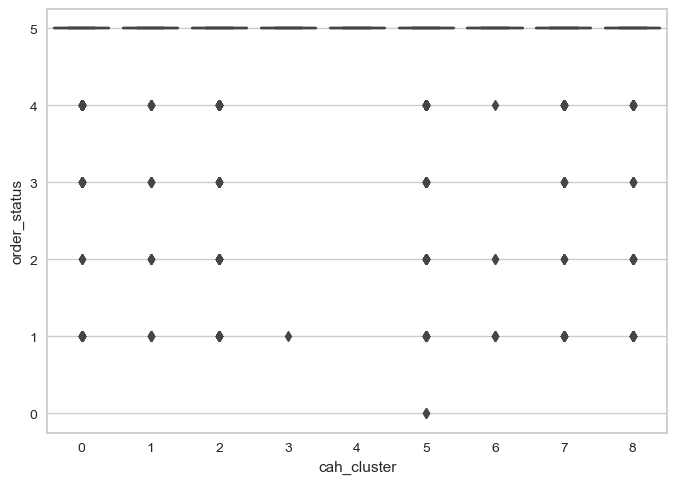

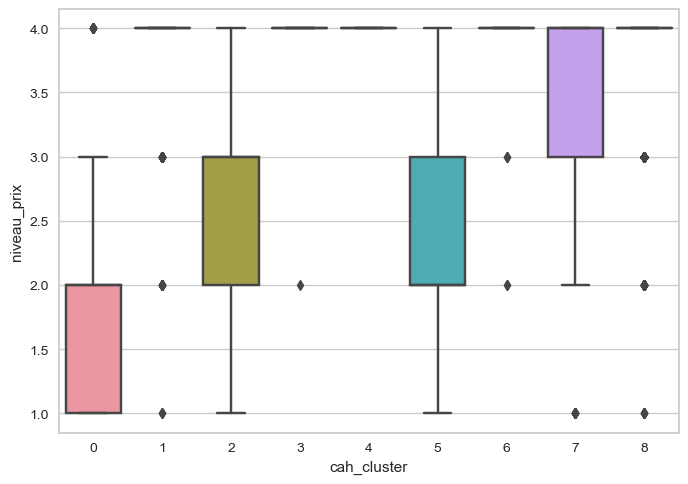

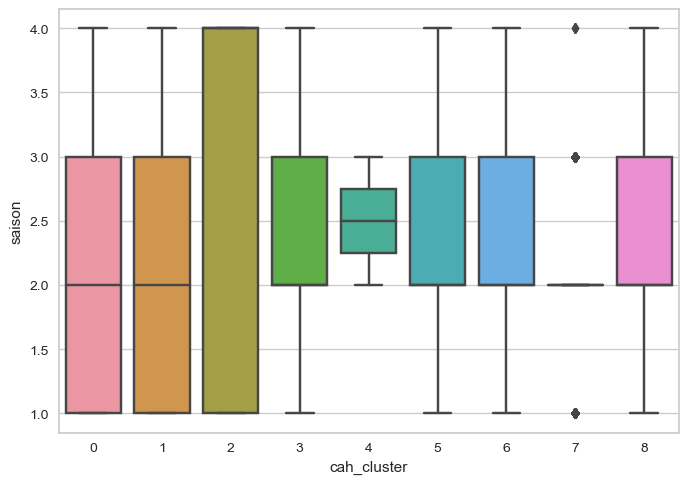

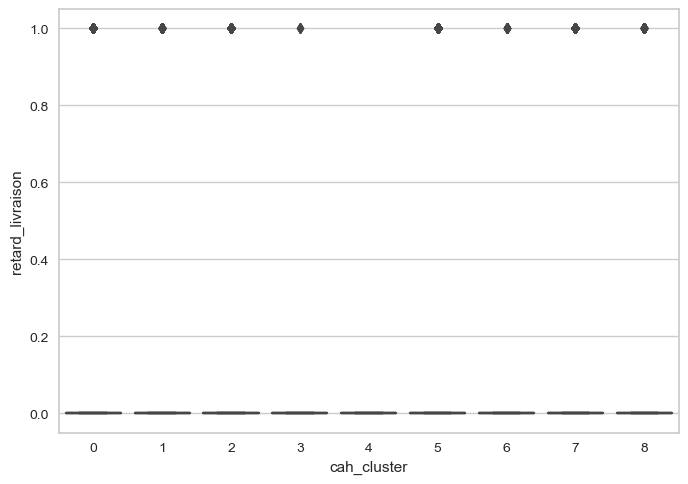

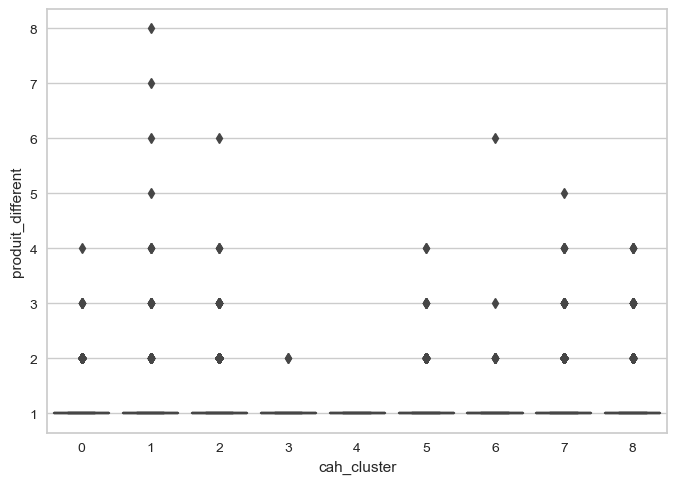

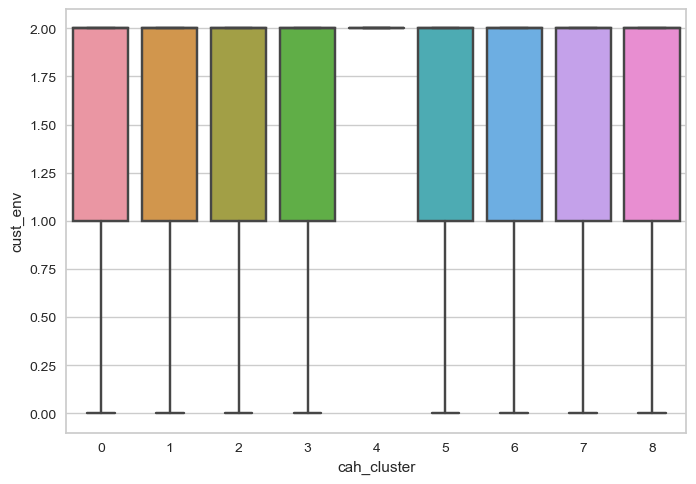

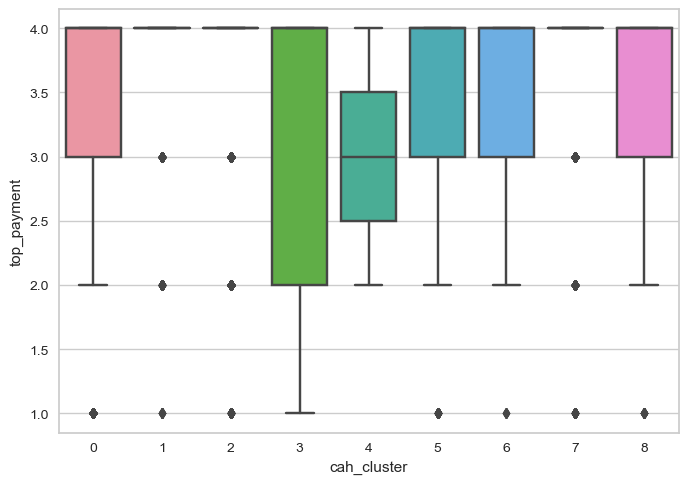

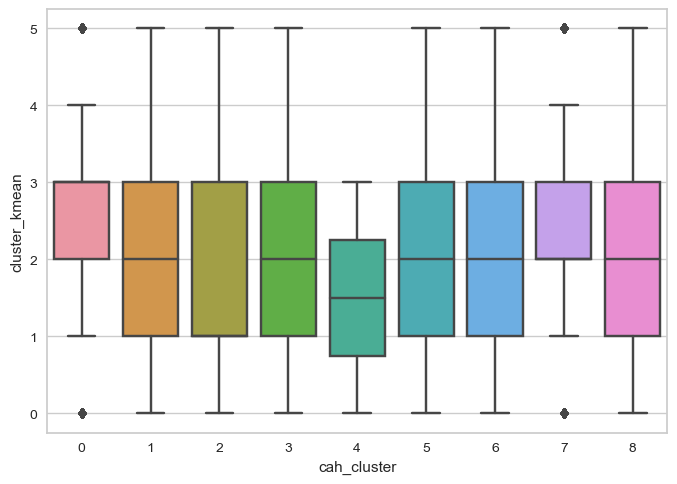

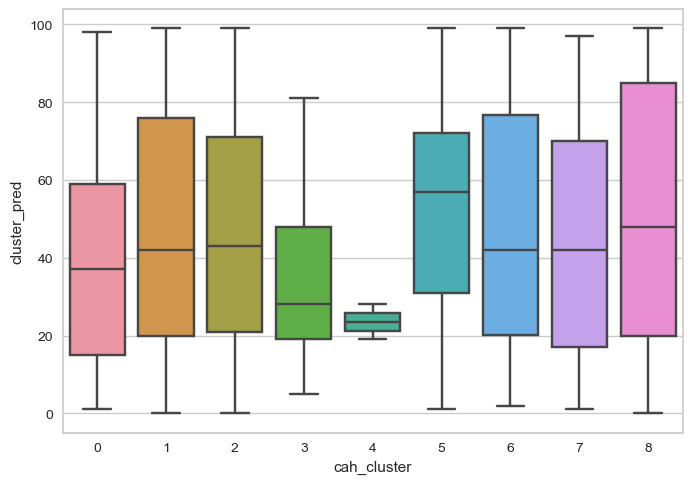

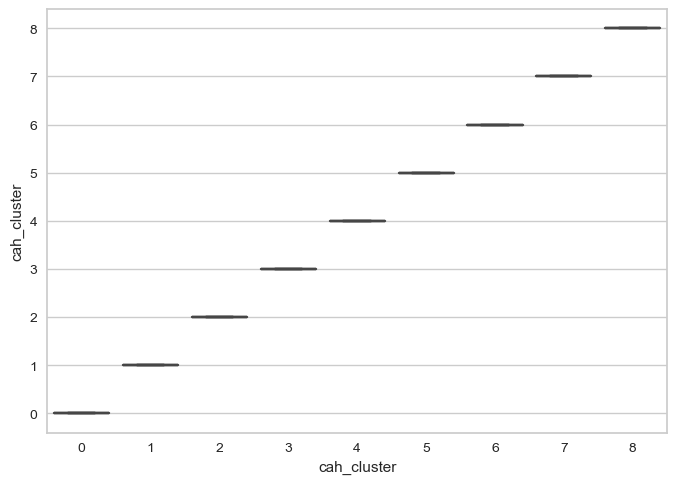

0    8363
2    6037
5    5050
7    2922
8    1532
1     919
6     150
3      25
4       2
Name: cah_cluster, dtype: int64


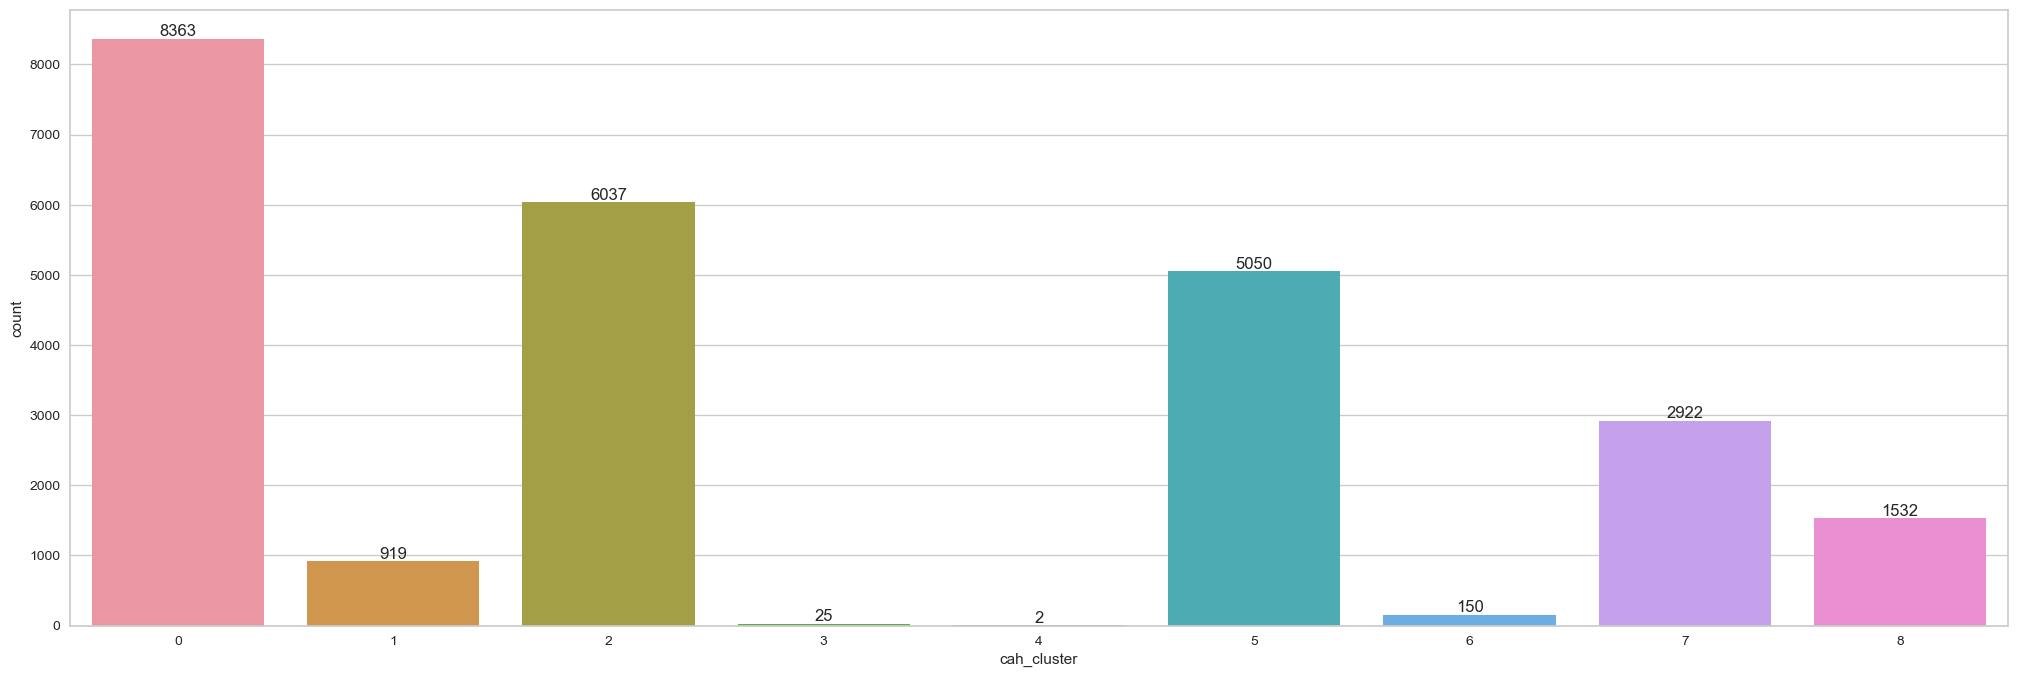

Recency  frequency  monetary  review_mean  proxi_city  seller_env  \
53115        62          1    140.03          5.0           0           2   
86867       411          4    746.96          5.0           0           2   
109536      442          1     55.09          4.0           0           2   
21437        20          1    289.41          4.0           0           2   
28487       109          1     79.29          5.0           0           1   
...         ...        ...       ...          ...         ...         ...   
10986        47          1     68.05          5.0           0           2   
92364       555          1     82.97          3.0           0           2   
85670        41          1    107.85          5.0           1           2   
15385       277          1     39.08          1.0           0           2   
23899       193          2    135.82          5.0           0           2   

        order_status  niveau_prix  saison  retard_livraison  \
53115              5            3       3                 0   
86867              5            4       3                 0   
109536             5            2       2                 0   
21437              5            4       3                 0   
28487              5            2       2                 0   
...              ...          ...     ...               ...   
10986              5            2       3                 0   
92364              5            2       1                 1   
85670              5            3       3                 0   
15385              5            1       4                 0   
23899              5            2       1                 0   

        produit_different  cust_env  top_payment  cluster_kmean  cluster_pred  \
53115                   1         1            4              2            80   
86867                   1         2            3              1            99   
109536                  1         2            4              3            46   
21437                   1         1            4              2            85   
28487                   1         2            4              3            14   
...                   ...       ...          ...            ...           ...   
10986                   1         2            4              1             8   
92364                   1         2            4              5            10   
85670                   1         2            4              4             6   
15385                   1         2            3              0            31   
23899                   1         1            2              2            61   

        cah_cluster  
53115             0  
86867             1  
109536            5  
21437             7  
28487             0  
...             ...  
10986             0  
92364             5  
85670             0  
15385             2  
23899             2  

[25000 rows x 16 columns]

In [47]:
classification_mixte_cluster(
    modele_13_indic_encode, df_z_modele_13, n_cluster=9)

# Kprototypes

https://medium.com/analytics-vidhya/customer-segmentation-using-k-prototypes-algorithm-in-python-aad4acbaaede

In [48]:
def kprototypes_elbow(modele=modele_5_indic_encode, standardiser=MinMaxScaler(), categorical_col=modele_5_cat_col, k=(3, 6)):
    scale = standardiser
    modele.iloc[:, :3] = scale.fit_transform(modele.iloc[:, :3])
    model_kpro = KPrototypes(
        random_state=42, init='Huang', verbose=0, max_iter=2)
    visualizer = KElbowVisualizer(model_kpro, k=k)

    visualizer.fit(modele, categorical=categorical_col)
    visualizer.poof()

In [77]:
def kprototypes(modele=modele_5_indic_encode, standardiser=MinMaxScaler(), categorical_col=modele_5_cat_col, nbr_cluster=4, name='5_indic'):
    model_kpro_2 = KPrototypes(
        nbr_cluster, init='Huang', verbose=0, random_state=42, max_iter=2)
    model_kpro_label = model_kpro_2.fit_predict(
        modele, categorical=categorical_col)
    modele["kpro_cluster"] = model_kpro_label
    for i, col in enumerate(modele.columns):
        plt.figure(i)
        sns.boxplot(data=modele, x=modele['kpro_cluster'], y=modele[col])
        plt.show()
    modele.to_csv(f"modele_final_{name}.csv")
    f, ax = plt.subplots(figsize=(25, 8))
    ax = sns.countplot(x="kpro_cluster", data=modele)
    ax.bar_label(ax.containers[0])
    plt.show()
    return modele

La baseline ne contient pas de variable qualitative.

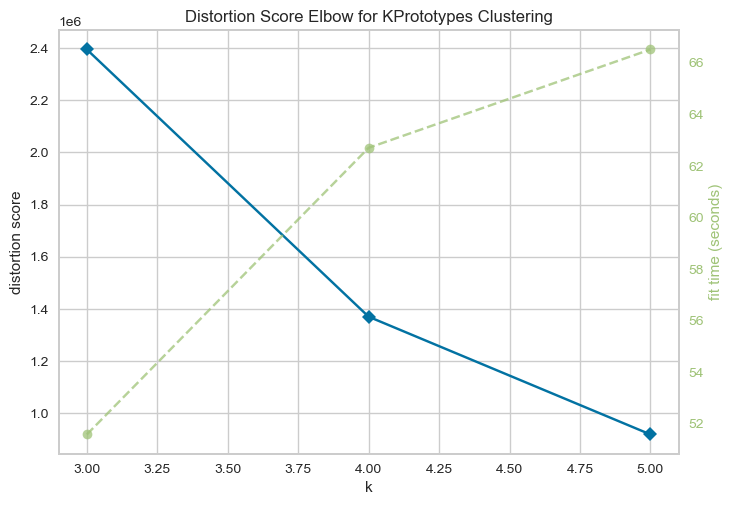

In [50]:
kprototypes_elbow(modele_5_indic_encode,
                  categorical_col=modele_5_cat_col, k=(3, 6))

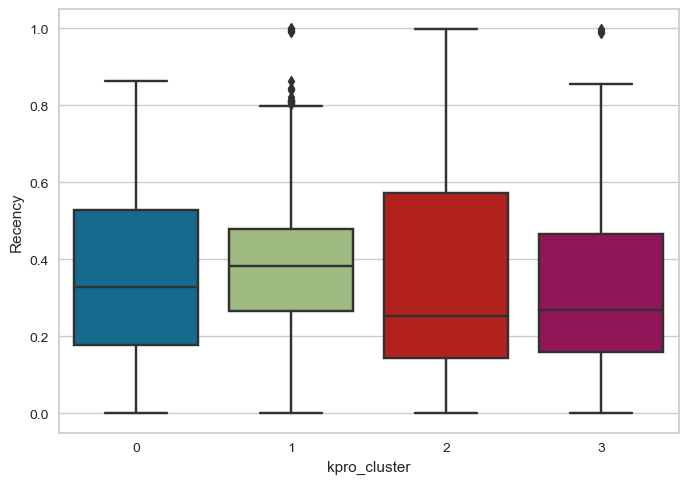

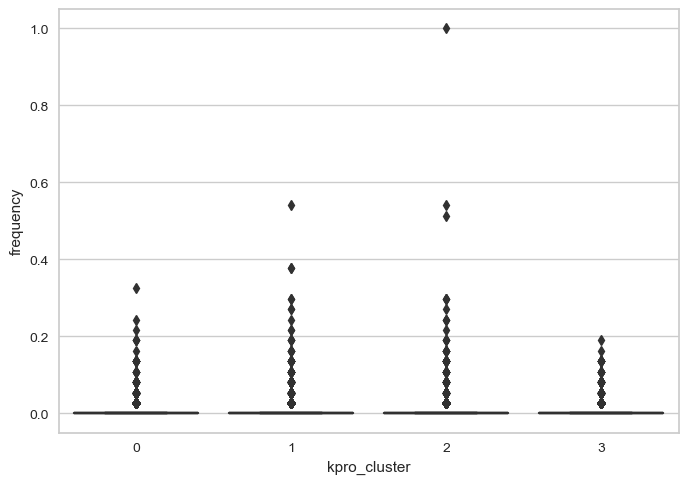

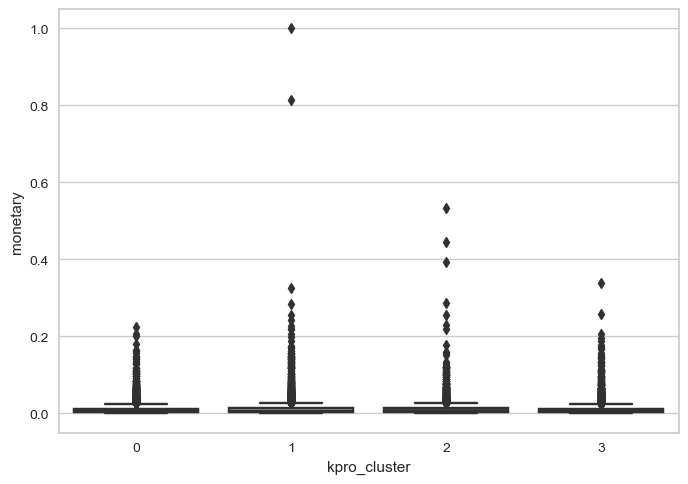

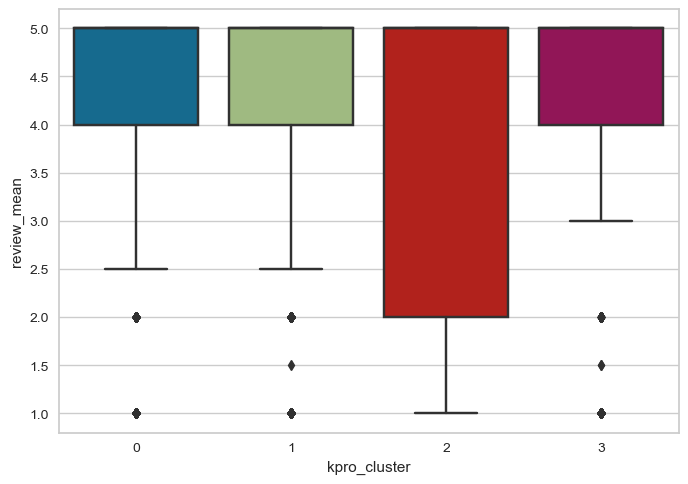

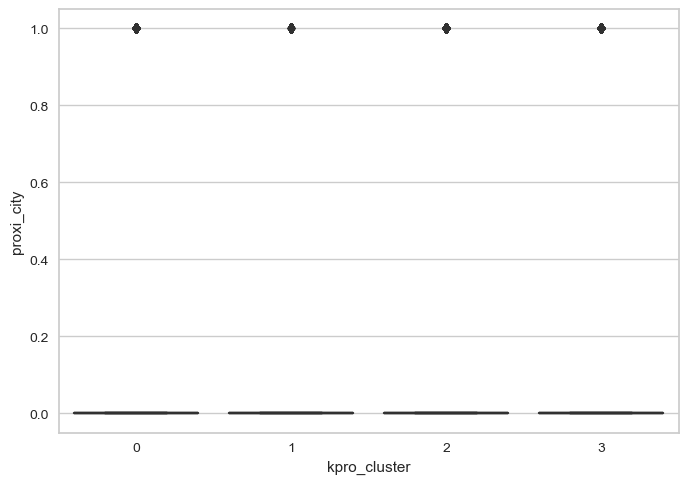

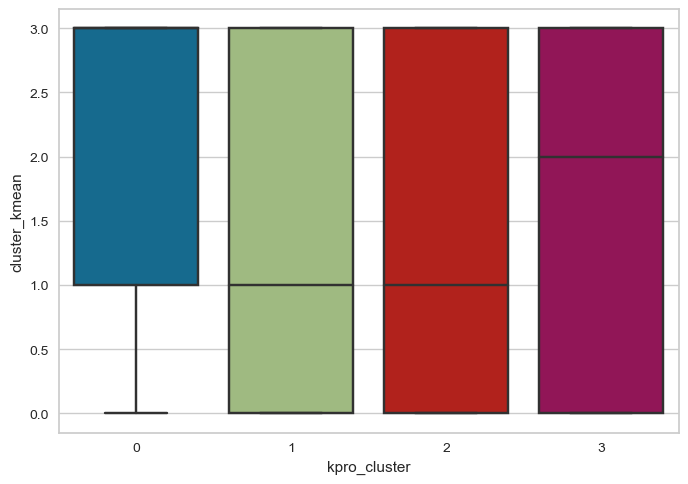

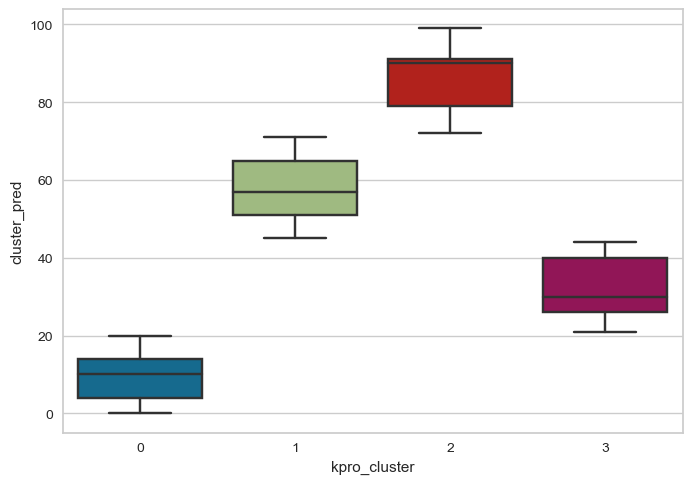

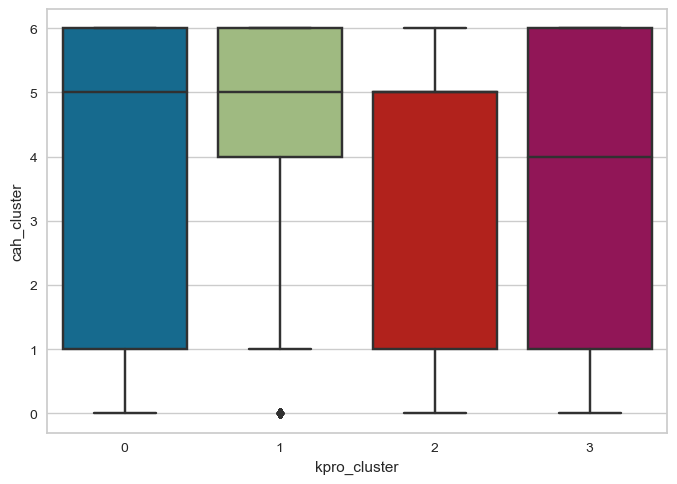

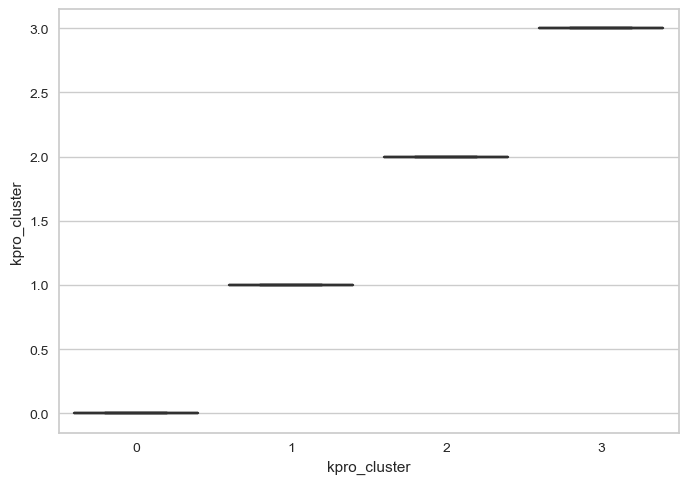

Recency  frequency  monetary  review_mean  proxi_city  cluster_kmean  \
53115   0.083333   0.000000  0.009518          5.0           0              3   
86867   0.584770   0.081081  0.053969          5.0           0              0   
109536  0.629310   0.000000  0.003297          4.0           0              0   
21437   0.022989   0.000000  0.020458          4.0           0              3   
28487   0.150862   0.000000  0.005070          5.0           0              3   
...          ...        ...       ...          ...         ...            ...   
10986   0.061782   0.000000  0.004246          5.0           0              3   
92364   0.791667   0.000000  0.005339          3.0           0              0   
85670   0.053161   0.000000  0.007161          5.0           1              2   
15385   0.392241   0.000000  0.002125          1.0           0              1   
23899   0.271552   0.027027  0.009210          5.0           0              3   

        cluster_pred  cah_cluster  kpro_cluster  
53115             57            1             1  
86867             79            4             2  
109536            38            5             3  
21437              5            1             0  
28487             28            1             3  
...              ...          ...           ...  
10986             11            1             0  
92364             21            5             3  
85670             33            1             3  
15385             53            6             1  
23899             40            6             3  

[25000 rows x 9 columns]

In [51]:
kprototypes(modele_5_indic_encode,
            categorical_col=modele_5_cat_col, nbr_cluster=4)

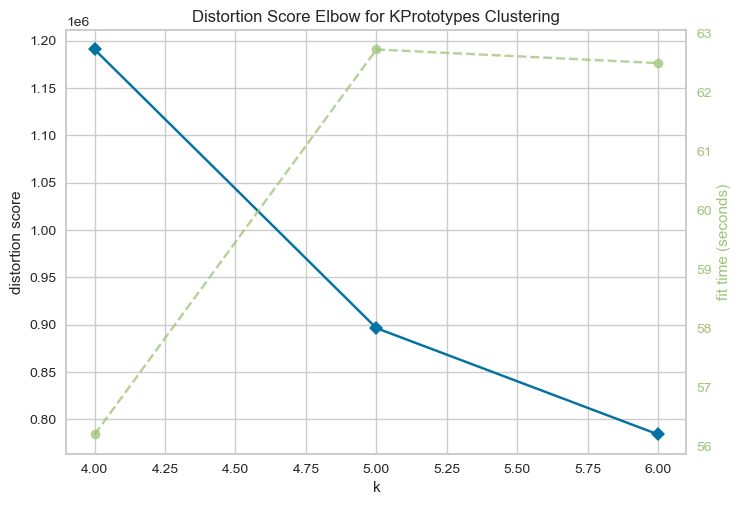

In [52]:
kprototypes_elbow(modele_6_indic_encode,
                  categorical_col=modele_6_cat_col, k=(4, 7))

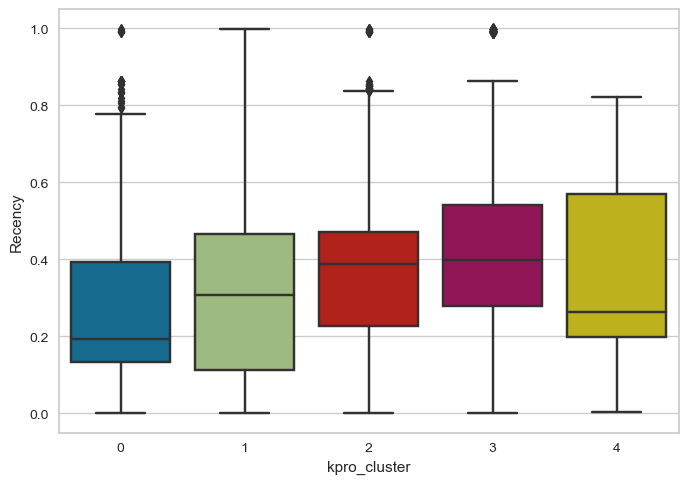

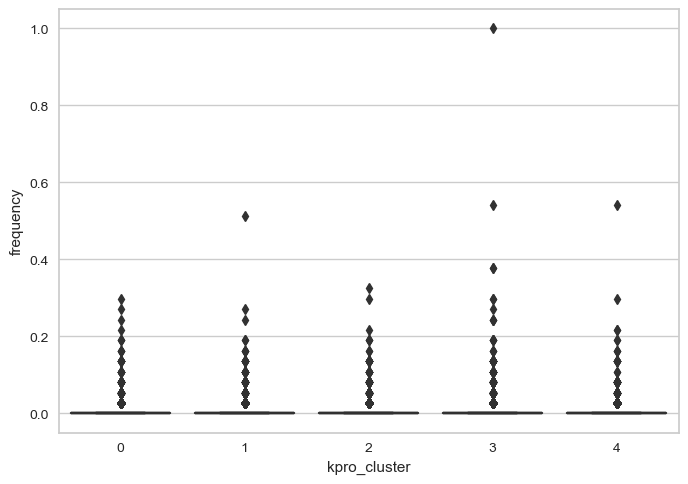

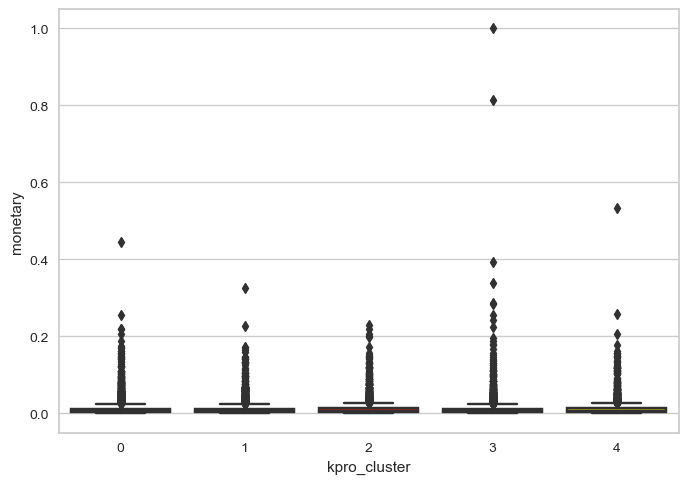

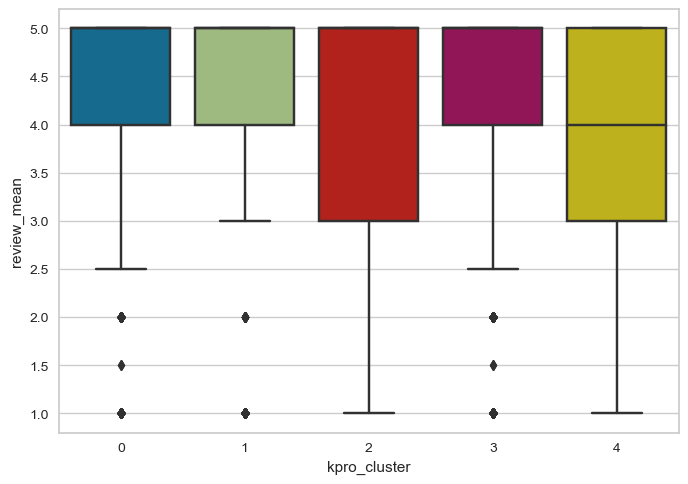

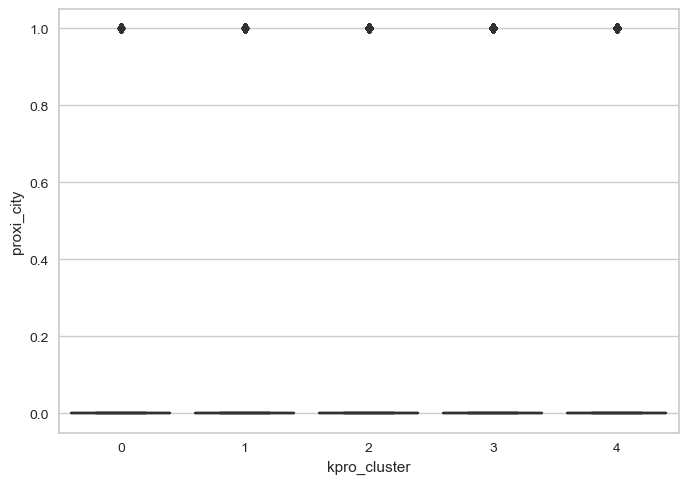

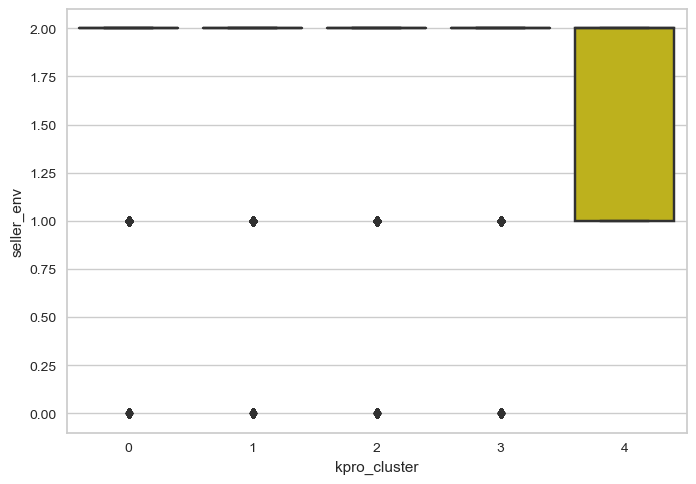

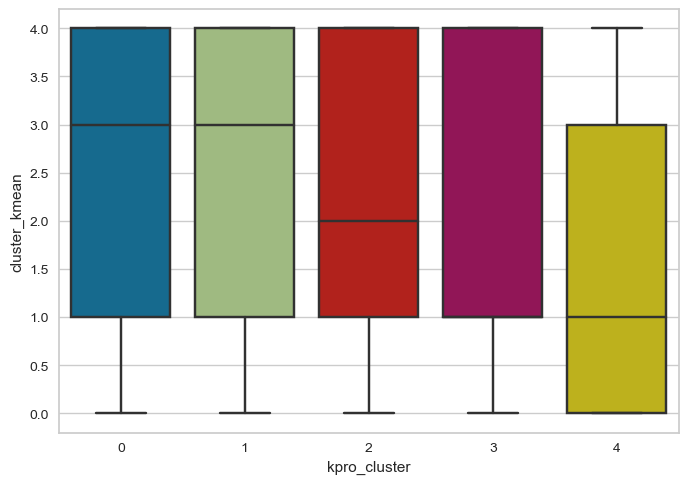

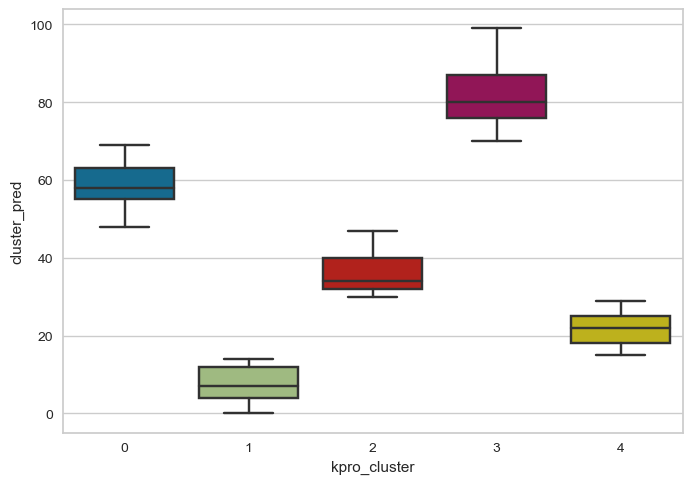

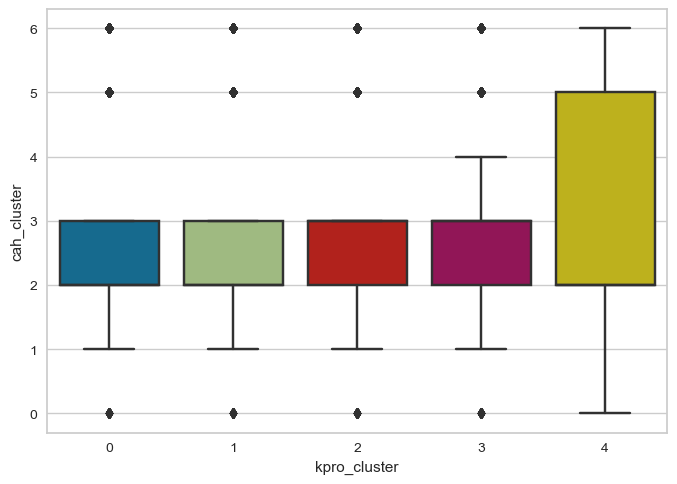

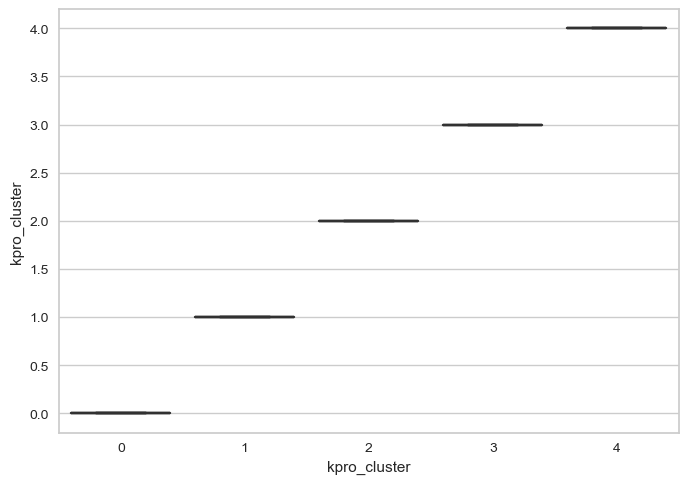

Recency  frequency  monetary  review_mean  proxi_city  seller_env  \
53115   0.083333   0.000000  0.009518          5.0           0           2   
86867   0.584770   0.081081  0.053969          5.0           0           2   
109536  0.629310   0.000000  0.003297          4.0           0           2   
21437   0.022989   0.000000  0.020458          4.0           0           2   
28487   0.150862   0.000000  0.005070          5.0           0           1   
...          ...        ...       ...          ...         ...         ...   
10986   0.061782   0.000000  0.004246          5.0           0           2   
92364   0.791667   0.000000  0.005339          3.0           0           2   
85670   0.053161   0.000000  0.007161          5.0           1           2   
15385   0.392241   0.000000  0.002125          1.0           0           2   
23899   0.271552   0.027027  0.009210          5.0           0           2   

        cluster_kmean  cluster_pred  cah_cluster  kpro_cluster  
53115               4            92            2             3  
86867               1             7            5             1  
109536              1            80            6             3  
21437               4             8            2             1  
28487               3            21            2             4  
...               ...           ...          ...           ...  
10986               4            92            2             3  
92364               1             1            6             1  
85670               2            47            2             2  
15385               0            40            3             2  
23899               4            32            2             2  

[25000 rows x 10 columns]

In [53]:
kprototypes(modele_6_indic_encode, categorical_col=modele_6_cat_col,
            nbr_cluster=5, name='6_indic')

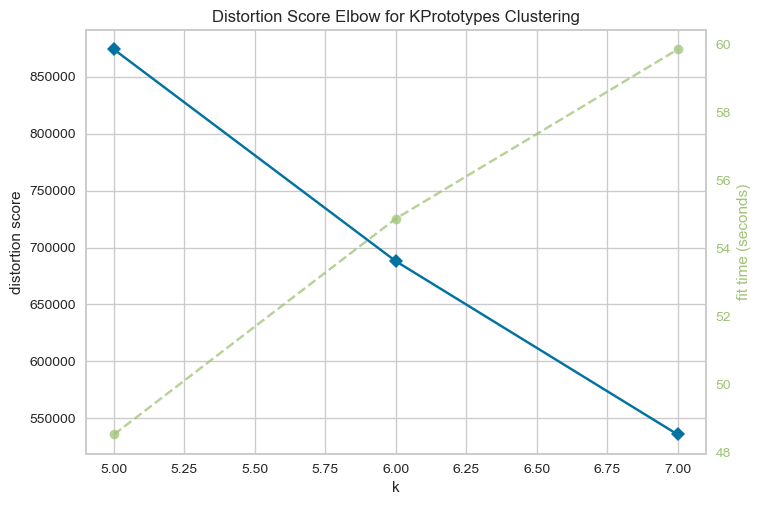

In [54]:
kprototypes_elbow(modele_7_indic_encode,
                  categorical_col=modele_7_cat_col, k=(5, 8))

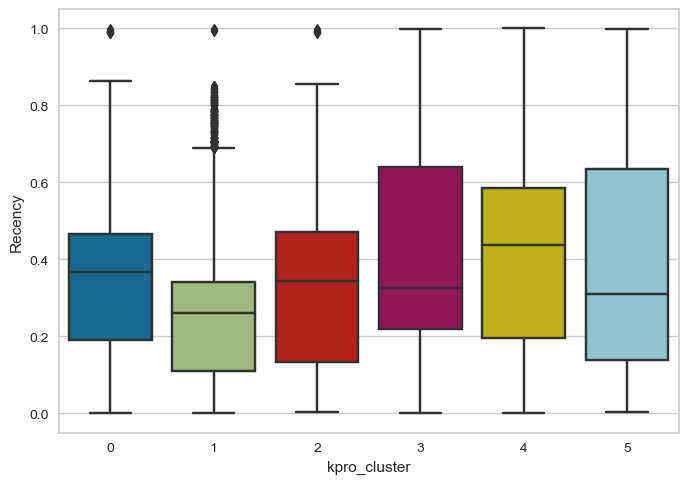

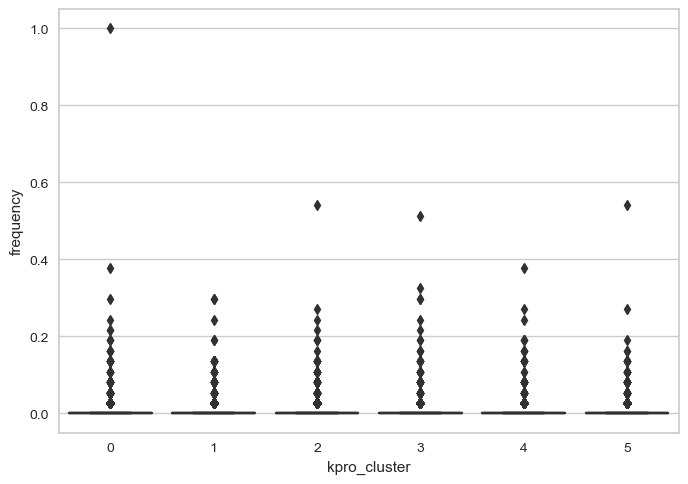

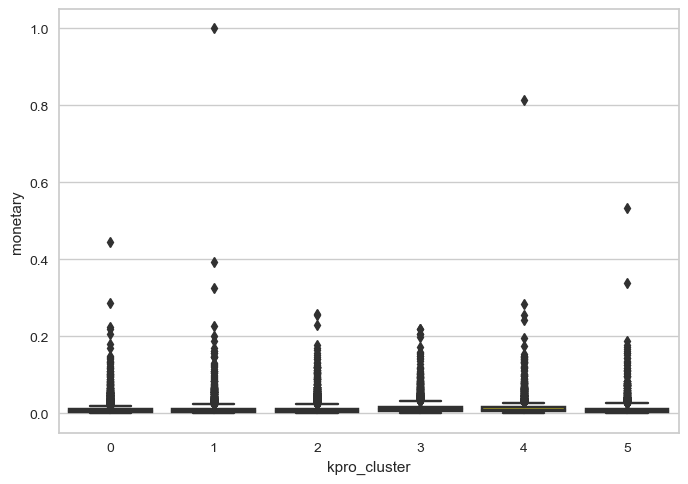

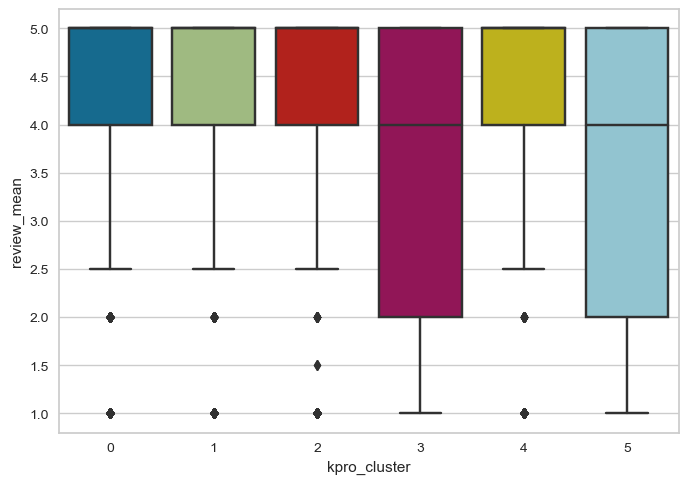

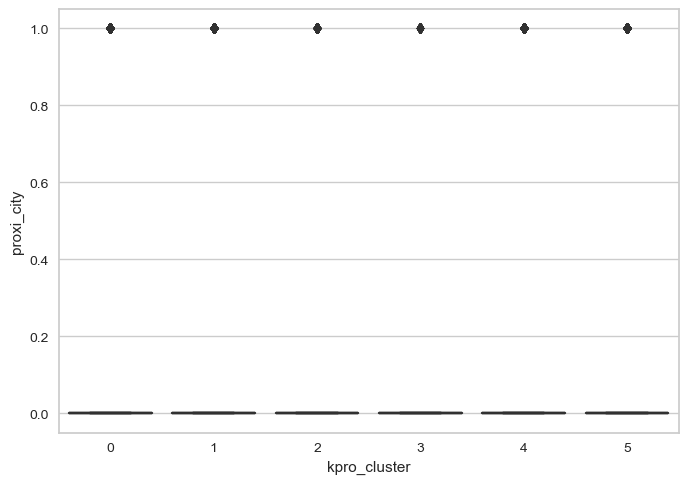

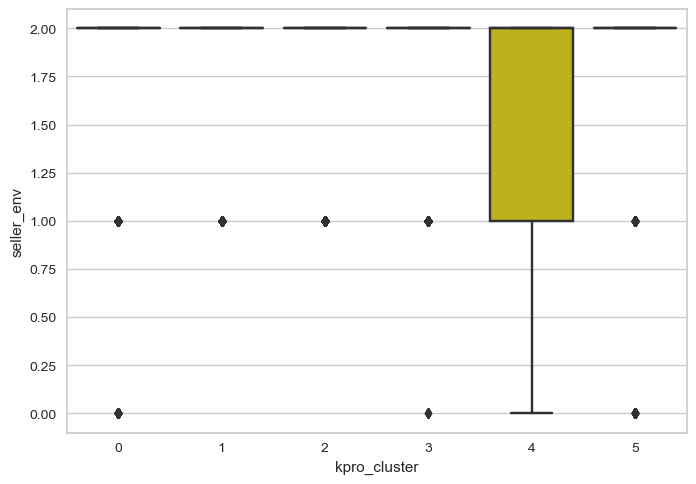

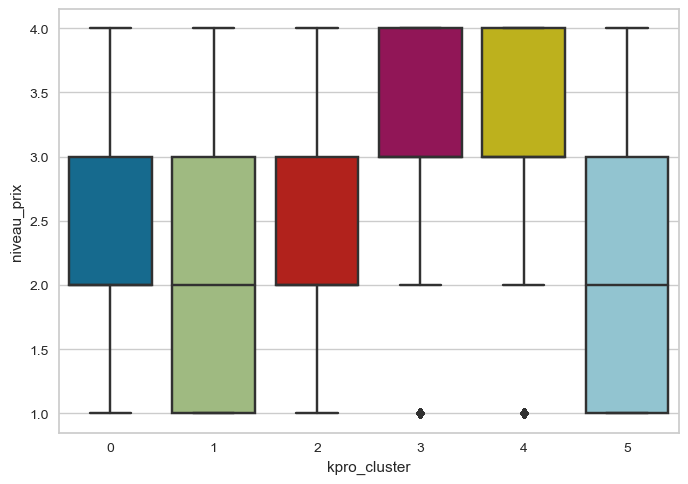

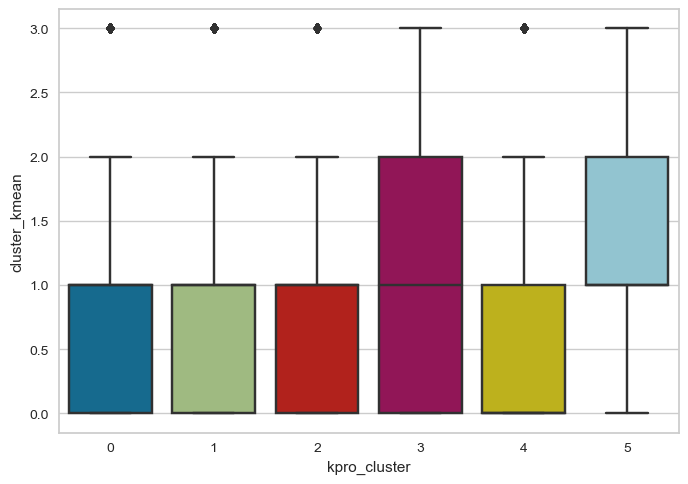

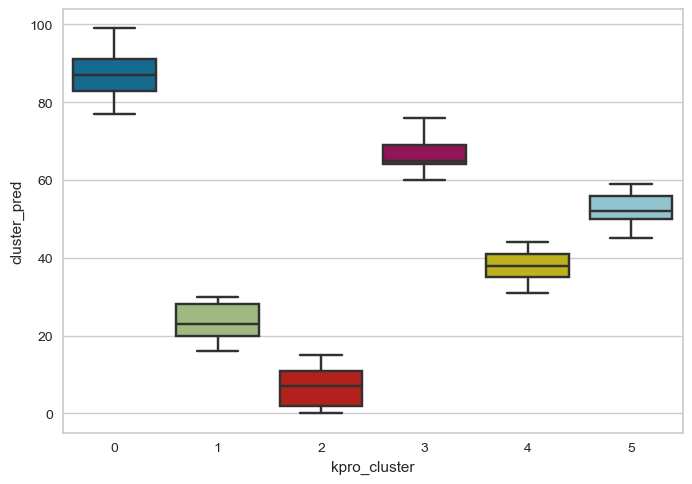

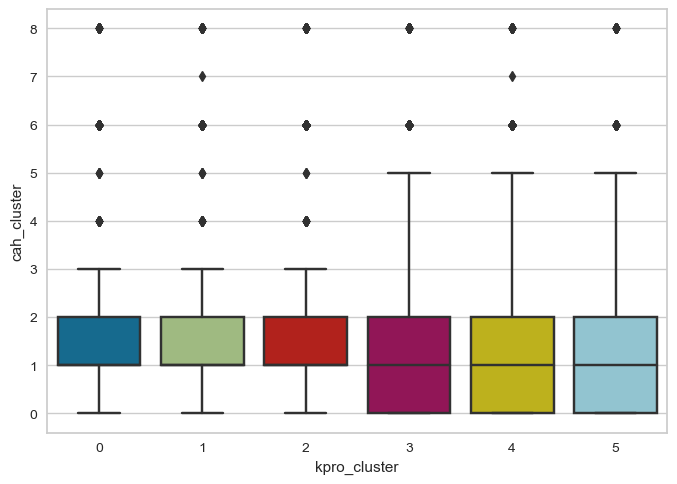

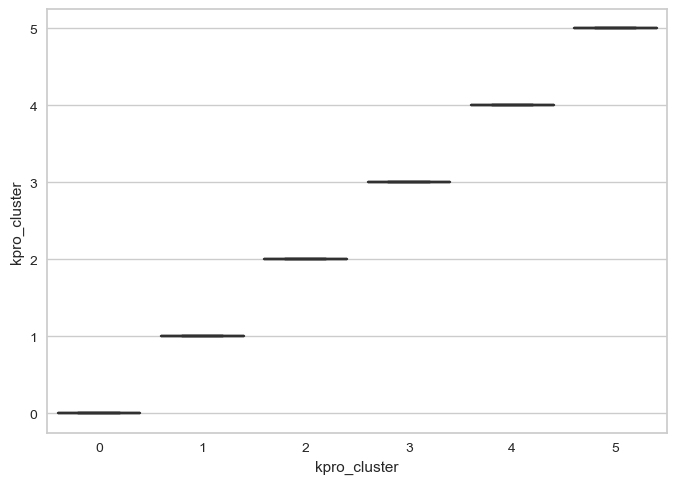

Recency  frequency  monetary  review_mean  proxi_city  seller_env  \
53115   0.083333   0.000000  0.009518          5.0           0           2   
86867   0.584770   0.081081  0.053969          5.0           0           2   
109536  0.629310   0.000000  0.003297          4.0           0           2   
21437   0.022989   0.000000  0.020458          4.0           0           2   
28487   0.150862   0.000000  0.005070          5.0           0           1   
...          ...        ...       ...          ...         ...         ...   
10986   0.061782   0.000000  0.004246          5.0           0           2   
92364   0.791667   0.000000  0.005339          3.0           0           2   
85670   0.053161   0.000000  0.007161          5.0           1           2   
15385   0.392241   0.000000  0.002125          1.0           0           2   
23899   0.271552   0.027027  0.009210          5.0           0           2   

        niveau_prix  cluster_kmean  cluster_pred  cah_cluster  kpro_cluster  
53115             3              0            28            2             1  
86867             4              0            38            6             4  
109536            2              1            47            0             5  
21437             4              0            11            2             2  
28487             2              1             8            2             2  
...             ...            ...           ...          ...           ...  
10986             2              1             2            2             2  
92364             2              2            30            0             1  
85670             3              3             4            2             2  
15385             1              2            21            1             1  
23899             2              1            22            1             1  

[25000 rows x 11 columns]

In [55]:
kprototypes(modele_7_indic_encode, categorical_col=modele_7_cat_col,
            nbr_cluster=6, name='7_indic')

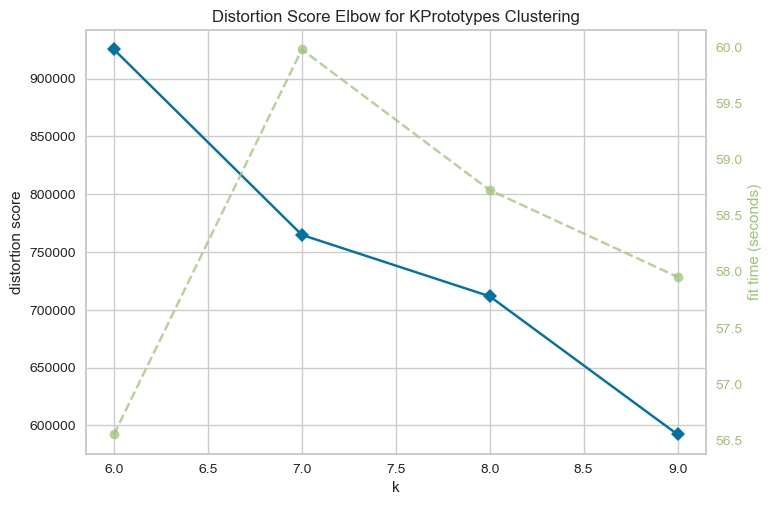

In [56]:
kprototypes_elbow(modele_13_indic_encode,
                  categorical_col=modele_13_cat_col, k=(6, 10))

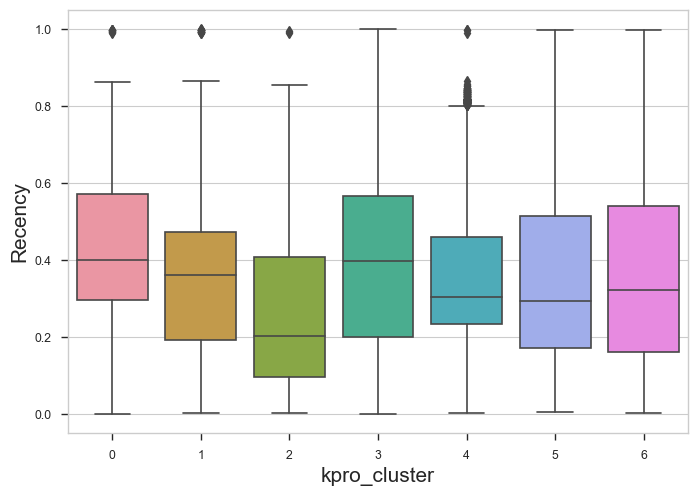

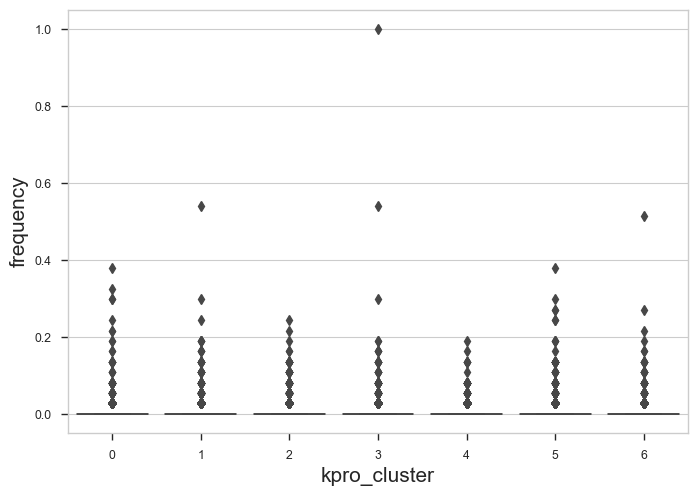

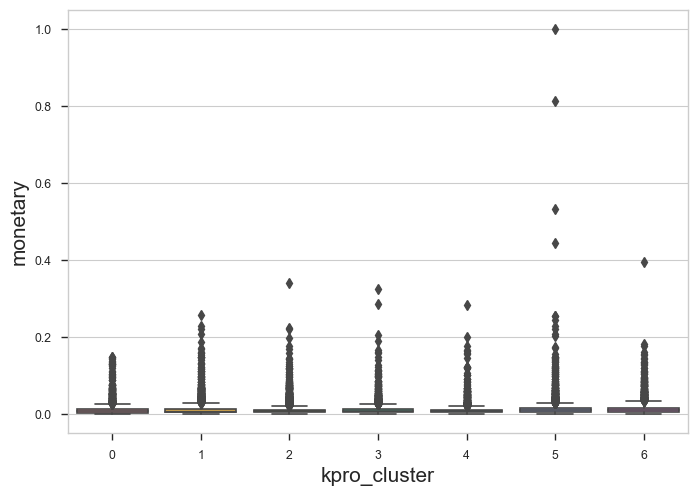

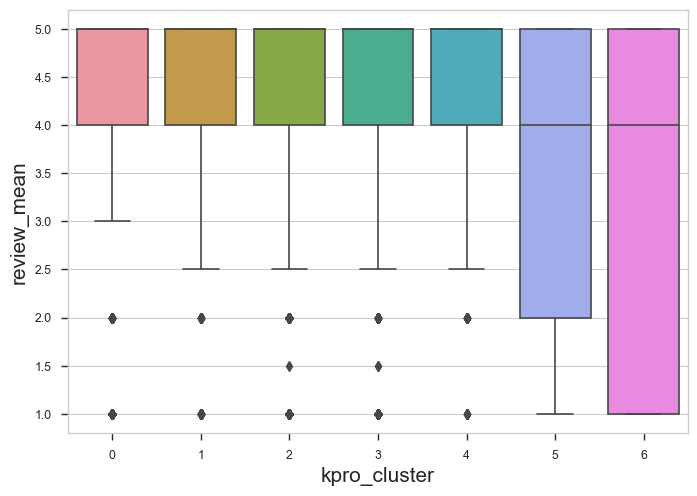

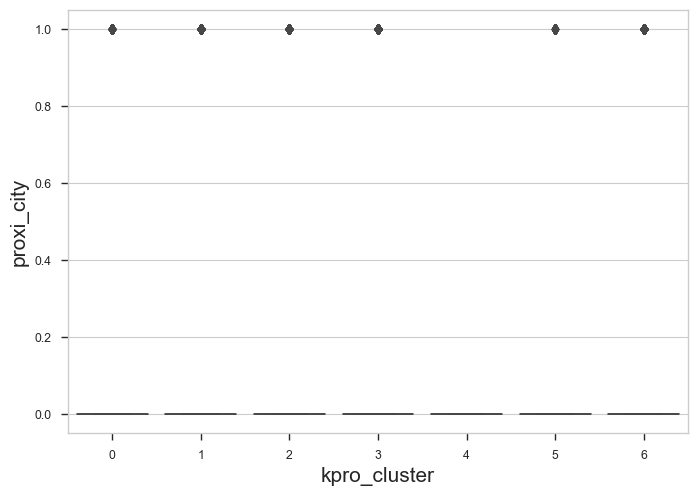

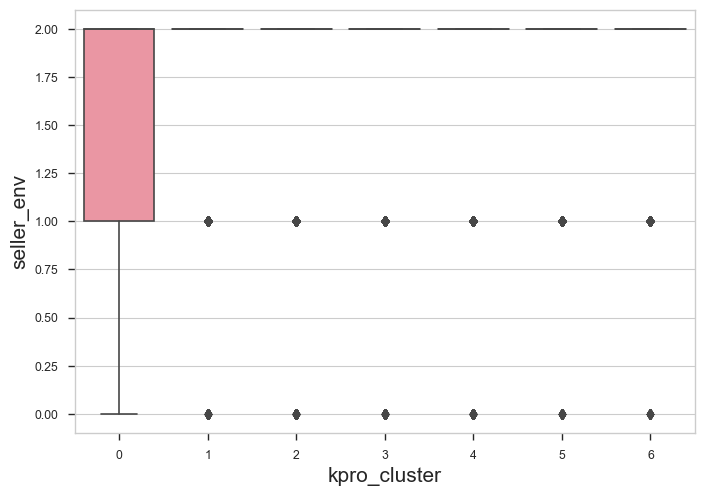

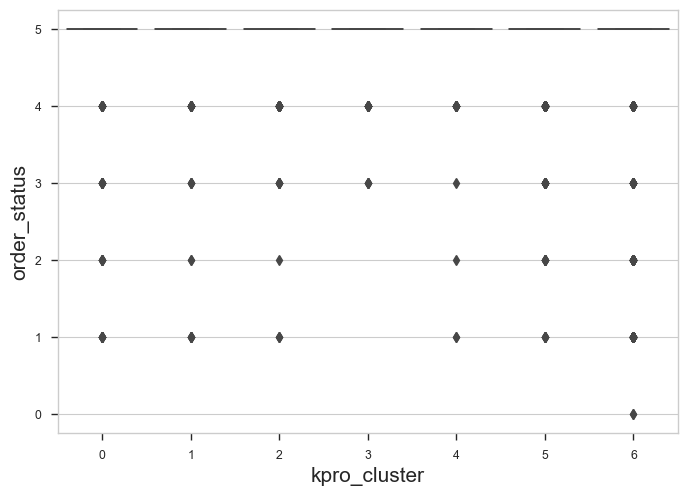

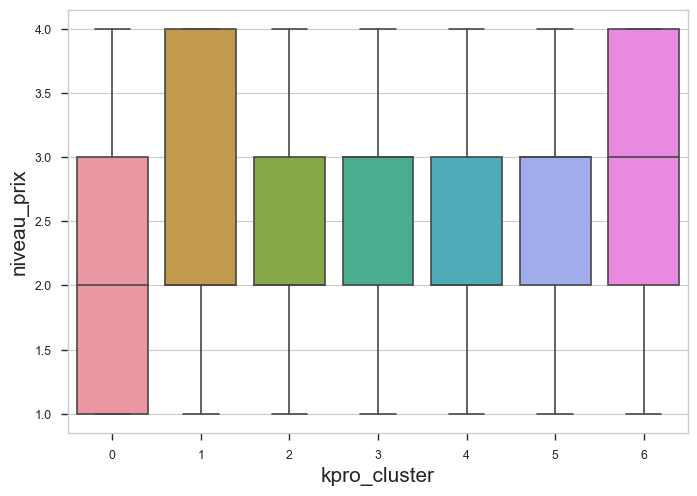

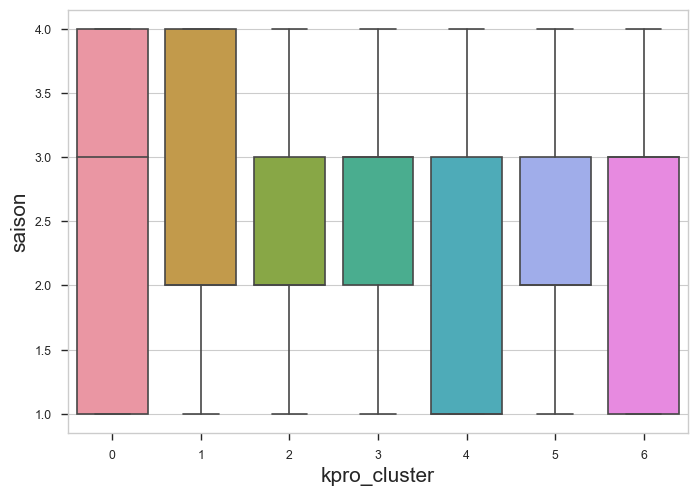

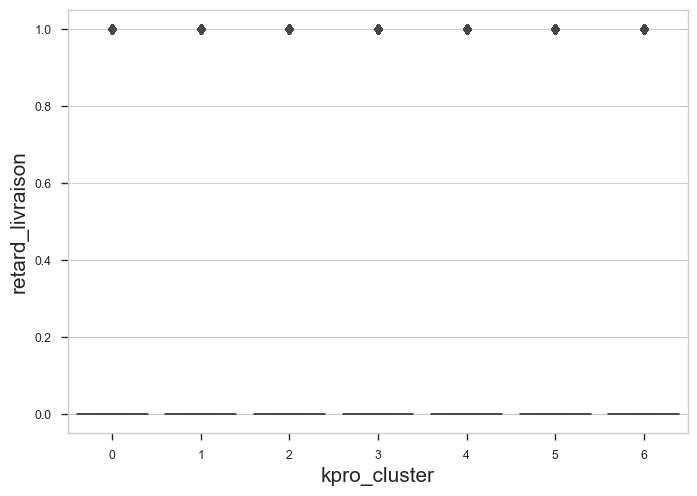

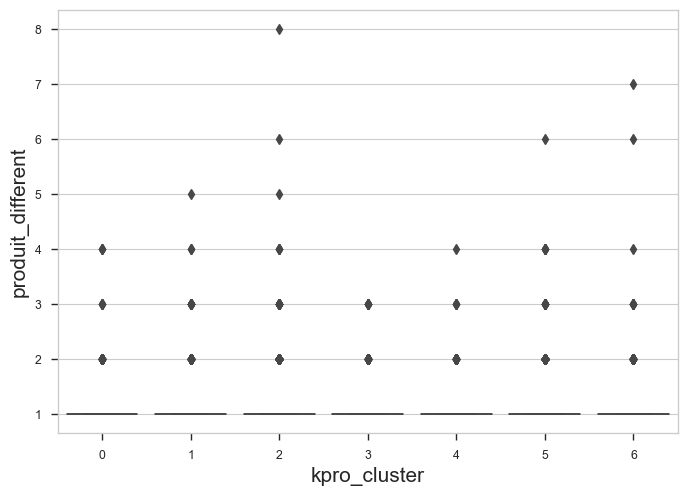

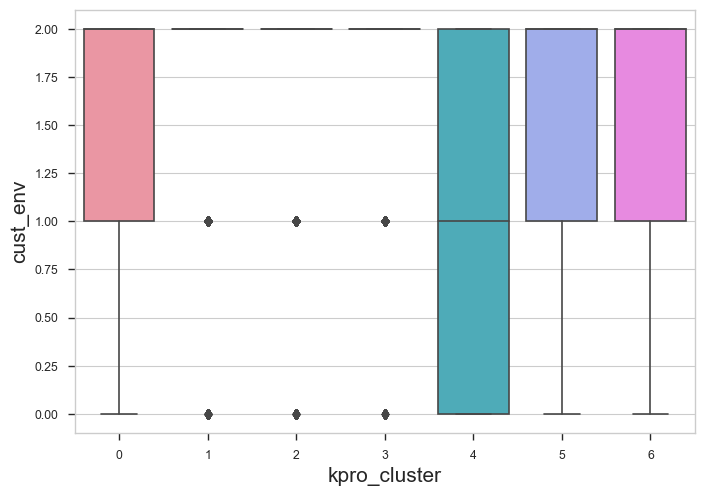

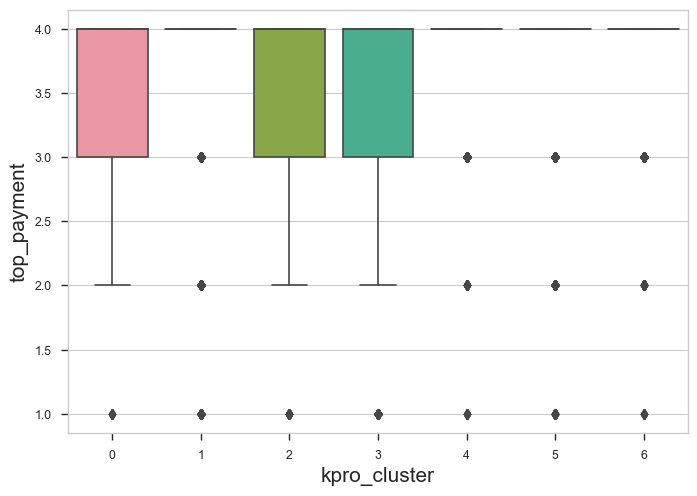

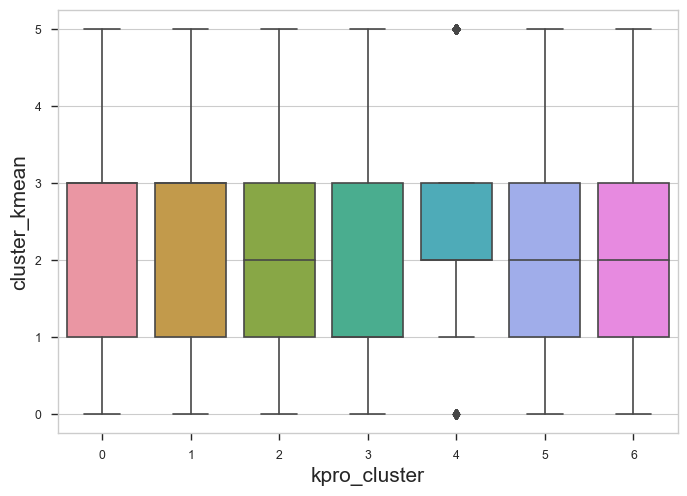

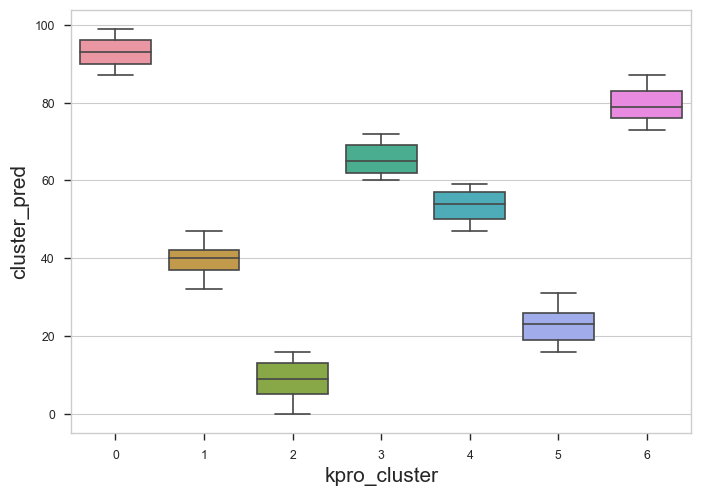

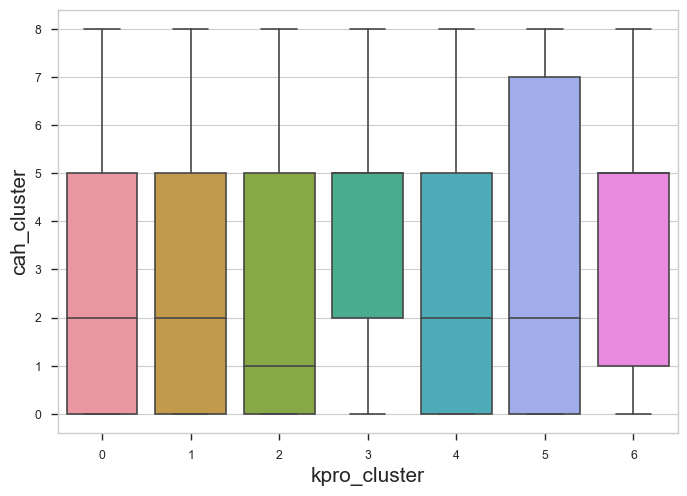

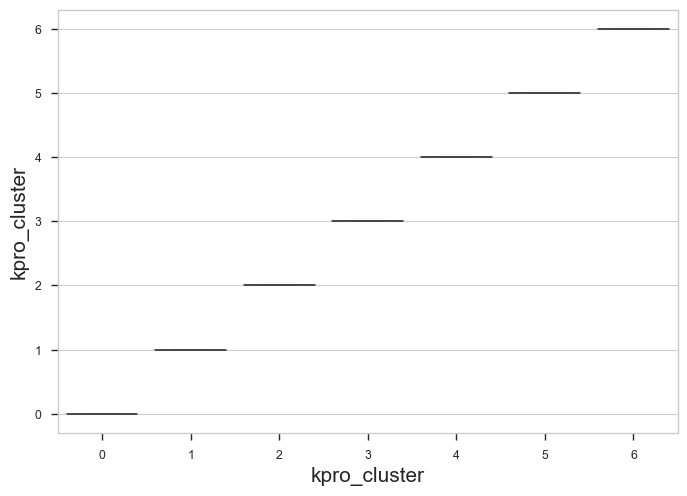

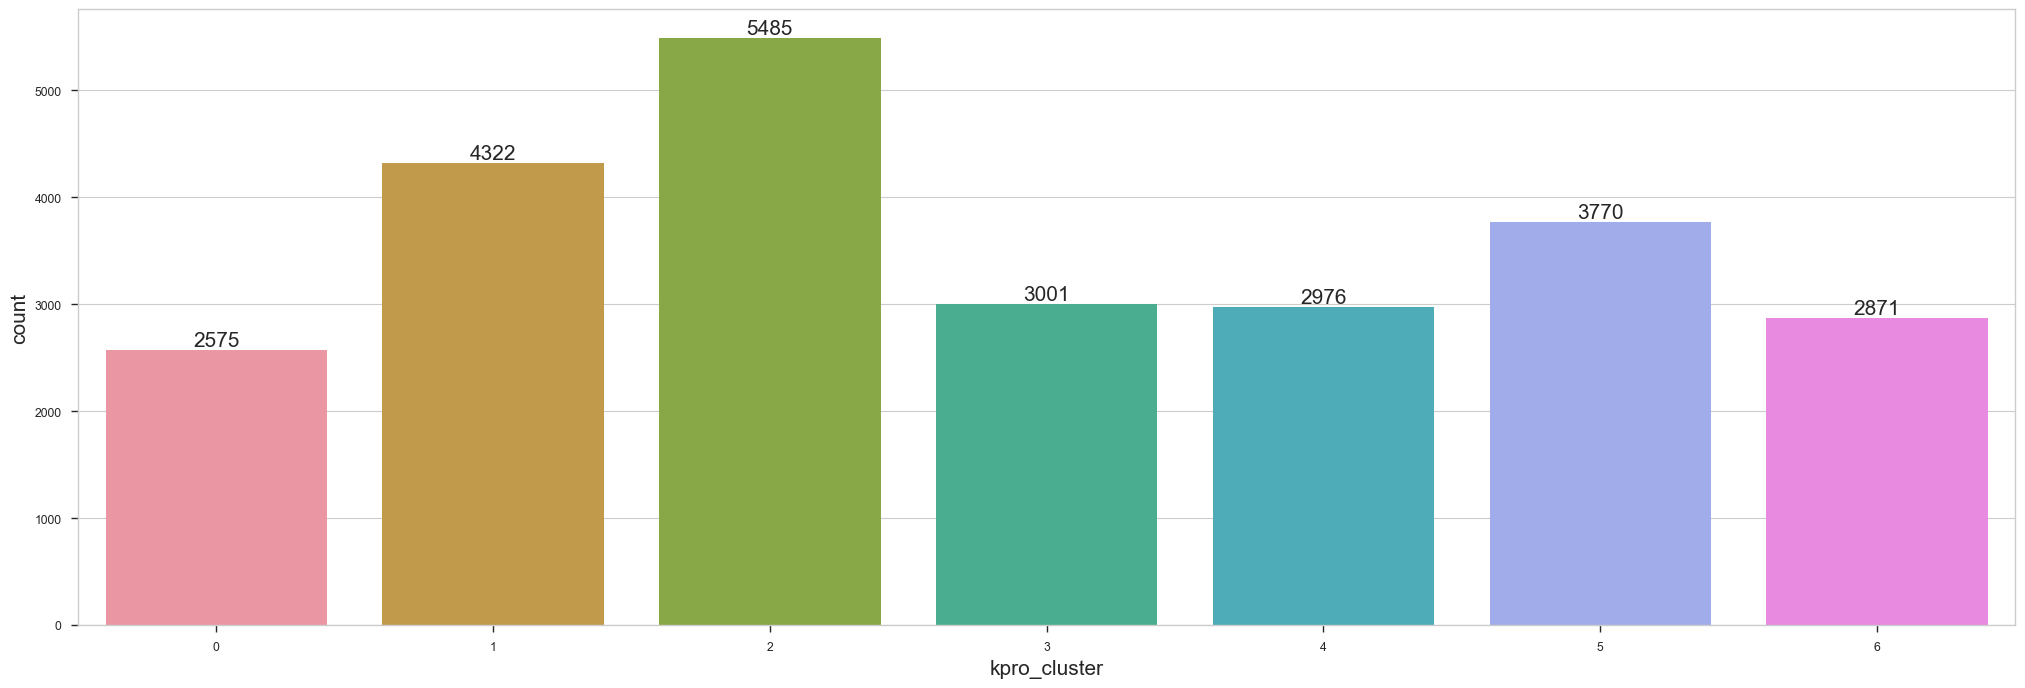

Recency  frequency  monetary  review_mean  proxi_city  seller_env  \
53115   0.083333   0.000000  0.009518          5.0           0           2   
86867   0.584770   0.081081  0.053969          5.0           0           2   
109536  0.629310   0.000000  0.003297          4.0           0           2   
21437   0.022989   0.000000  0.020458          4.0           0           2   
28487   0.150862   0.000000  0.005070          5.0           0           1   
...          ...        ...       ...          ...         ...         ...   
10986   0.061782   0.000000  0.004246          5.0           0           2   
92364   0.791667   0.000000  0.005339          3.0           0           2   
85670   0.053161   0.000000  0.007161          5.0           1           2   
15385   0.392241   0.000000  0.002125          1.0           0           2   
23899   0.271552   0.027027  0.009210          5.0           0           2   

        order_status  niveau_prix  saison  retard_livraison  \
53115              5            3       3                 0   
86867              5            4       3                 0   
109536             5            2       2                 0   
21437              5            4       3                 0   
28487              5            2       2                 0   
...              ...          ...     ...               ...   
10986              5            2       3                 0   
92364              5            2       1                 1   
85670              5            3       3                 0   
15385              5            1       4                 0   
23899              5            2       1                 0   

        produit_different  cust_env  top_payment  cluster_kmean  cluster_pred  \
53115                   1         1            4              2            80   
86867                   1         2            3              1            99   
109536                  1         2            4              3            46   
21437                   1         1            4              2            85   
28487                   1         2            4              3            14   
...                   ...       ...          ...            ...           ...   
10986                   1         2            4              1             8   
92364                   1         2            4              5            10   
85670                   1         2            4              4             6   
15385                   1         2            3              0            31   
23899                   1         1            2              2            61   

        cah_cluster  kpro_cluster  
53115             0             6  
86867             1             0  
109536            5             1  
21437             7             6  
28487             0             2  
...             ...           ...  
10986             0             2  
92364             5             2  
85670             0             2  
15385             2             5  
23899             2             3  

[25000 rows x 17 columns]

In [78]:
kprototypes(modele_13_indic_encode, categorical_col=modele_13_cat_col,
            nbr_cluster=7, name='13_indic')

# Choix du modèle

Le modèle retenu pour cette segmentation est le Kprototype avec 13 indicateurs qui a permis de créer 7 groupes de clients :

In [96]:
modele_13_indic_encode

Recency  frequency  monetary  review_mean  proxi_city  seller_env  \
53115   0.083333   0.000000  0.009518          5.0           0           2   
86867   0.584770   0.081081  0.053969          5.0           0           2   
109536  0.629310   0.000000  0.003297          4.0           0           2   
21437   0.022989   0.000000  0.020458          4.0           0           2   
28487   0.150862   0.000000  0.005070          5.0           0           1   
...          ...        ...       ...          ...         ...         ...   
10986   0.061782   0.000000  0.004246          5.0           0           2   
92364   0.791667   0.000000  0.005339          3.0           0           2   
85670   0.053161   0.000000  0.007161          5.0           1           2   
15385   0.392241   0.000000  0.002125          1.0           0           2   
23899   0.271552   0.027027  0.009210          5.0           0           2   

        order_status  niveau_prix  saison  retard_livraison  \
53115              5            3       3                 0   
86867              5            4       3                 0   
109536             5            2       2                 0   
21437              5            4       3                 0   
28487              5            2       2                 0   
...              ...          ...     ...               ...   
10986              5            2       3                 0   
92364              5            2       1                 1   
85670              5            3       3                 0   
15385              5            1       4                 0   
23899              5            2       1                 0   

        produit_different  cust_env  top_payment  cluster_kmean  cluster_pred  \
53115                   1         1            4              2            80   
86867                   1         2            3              1            99   
109536                  1         2            4              3            46   
21437                   1         1            4              2            85   
28487                   1         2            4              3            14   
...                   ...       ...          ...            ...           ...   
10986                   1         2            4              1             8   
92364                   1         2            4              5            10   
85670                   1         2            4              4             6   
15385                   1         2            3              0            31   
23899                   1         1            2              2            61   

        cah_cluster  kpro_cluster  
53115             0             6  
86867             1             0  
109536            5             1  
21437             7             6  
28487             0             2  
...             ...           ...  
10986             0             2  
92364             5             2  
85670             0             2  
15385             2             5  
23899             2             3  

[25000 rows x 17 columns]

In [97]:
modele_final_mean = modele_13_indic_encode.groupby(
    'kpro_cluster').agg(['min', 'mean', 'max'])

In [98]:
modele_final_mean

Recency                     frequency                      \
                   min      mean       max       min      mean       max   
kpro_cluster                                                               
0             0.000000  0.435660  0.997126       0.0  0.006382  0.378378   
1             0.001437  0.357600  1.000000       0.0  0.005209  0.540541   
2             0.001437  0.270657  0.994253       0.0  0.004656  0.243243   
3             0.000000  0.382246  0.998563       0.0  0.006520  1.000000   
4             0.002874  0.358766  0.995690       0.0  0.003578  0.189189   
5             0.004310  0.342438  0.997126       0.0  0.006882  0.378378   
6             0.001437  0.348281  0.995690       0.0  0.004999  0.513514   

              monetary                     review_mean                 \
                   min      mean       max         min      mean  max   
kpro_cluster                                                            
0             0.000294  0.010881  0.148086         1.0  4.237476  5.0   
1             0.000243  0.011610  0.257535         1.0  4.531467  5.0   
2             0.000309  0.010114  0.339565         1.0  4.215406  5.0   
3             0.000000  0.011576  0.324844         1.0  4.167777  5.0   
4             0.000207  0.009553  0.283809         1.0  4.444052  5.0   
5             0.000272  0.013994  1.000000         1.0  3.501061  5.0   
6             0.000337  0.013984  0.393699         1.0  3.490247  5.0   

             proxi_city               seller_env               order_status  \
                    min      mean max        min      mean max          min   
kpro_cluster                                                                  
0                     0  0.049320   1          0  1.682330   2            1   
1                     0  0.065479   1          0  1.913003   2            1   
2                     0  0.030264   1          0  1.799088   2            1   
3                     0  0.085638   1          0  1.736421   2            3   
4                     0  0.000000   0          0  1.732191   2            1   
5                     0  0.011406   1          0  1.909019   2            1   
6                     0  0.146987   1          0  1.927551   2            0   

                           niveau_prix               saison                \
                  mean max         min      mean max    min      mean max   
kpro_cluster                                                                
0             4.956505   5           1  2.324660   4      1  2.469126   4   
1             4.985423   5           1  2.462749   4      1  2.509949   4   
2             4.986144   5           1  2.460164   4      1  2.539654   4   
3             4.991003   5           1  2.568477   4      1  2.425525   4   
4             4.990255   5           1  2.364247   4      1  1.806116   4   
5             4.952520   5           1  2.707162   4      1  2.185676   4   
6             4.811912   5           1  2.776733   4      1  2.360850   4   

             retard_livraison               produit_different                \
                          min      mean max               min      mean max   
kpro_cluster                                                                  
0                           0  0.062136   1                 1  1.038058   4   
1                           0  0.045349   1                 1  1.035863   5   
2                           0  0.074385   1                 1  1.044303   8   
3                           0  0.127291   1                 1  1.032989   3   
4                           0  0.063508   1                 1  1.026546   4   
5                           0  0.097613   1                 1  1.057560   6   
6                           0  0.099617   1                 1  1.042494   7   

             cust_env               top_payment               cluster_kmean  \
                  min      mean max         min      mean max           min   
kpro_cluster

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

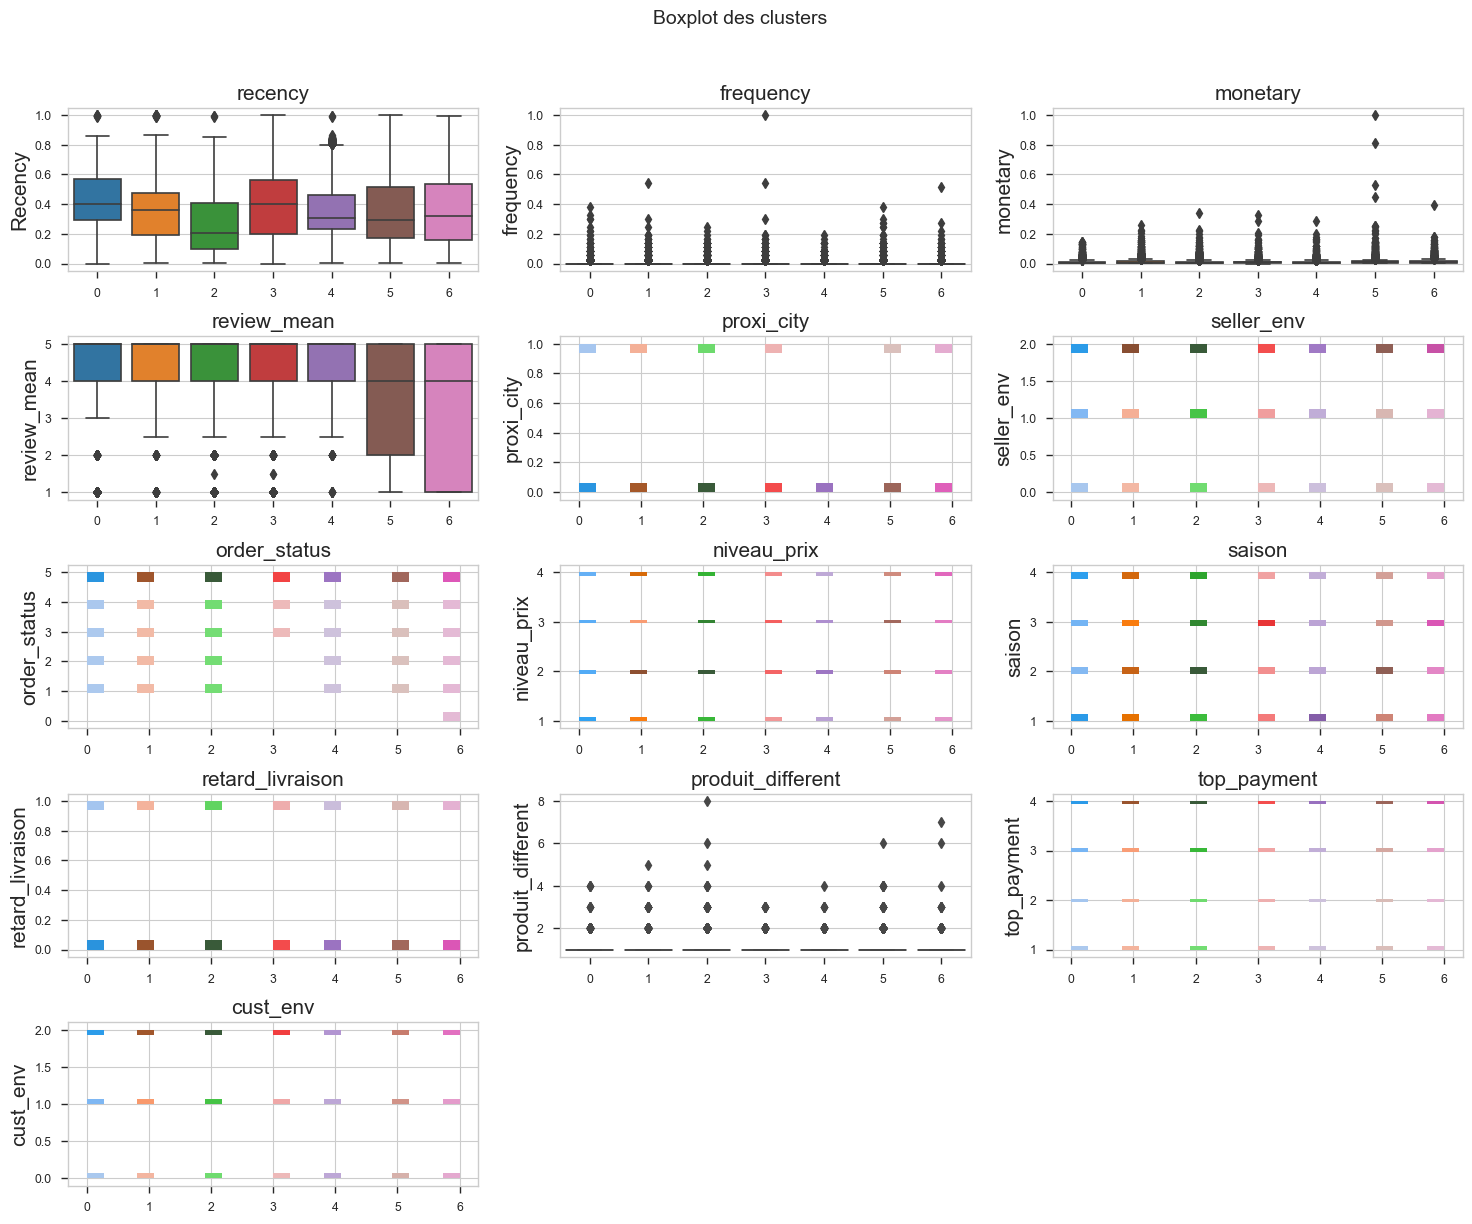

In [111]:
fig, axes = plt.subplots(5, 3, figsize=(18, 14))
fig.subplots_adjust(hspace=0.4)
sns.set_context("paper", rc={"font.size": 15,
                "axes.titlesize": 15, "axes.labelsize": 15})

fig.suptitle("Boxplot des clusters ", fontsize=14, y=0.95)

sns.boxplot(ax=axes[0, 0], data=modele_13_indic_encode,
            palette="tab10", x='kpro_cluster', y='Recency')
#axes[0, 0].set(yticklabels=[])
axes[0, 0].set(xlabel=None)
axes[0, 0].set(title='recency')

sns.boxplot(ax=axes[0, 1], data=modele_13_indic_encode,
            palette="tab10", x='kpro_cluster', y='frequency')
#axes[0, 1].set(yticklabels=[])
axes[0, 1].set(xlabel=None)
axes[0, 1].set(title='frequency')

sns.boxplot(ax=axes[0, 2], data=modele_13_indic_encode,
            palette="tab10", x='kpro_cluster', y='monetary')
#axes[0, 2].set(yticklabels=[])
axes[0, 2].set(xlabel=None)
axes[0, 2].set(title='monetary')

sns.boxplot(ax=axes[1, 0], data=modele_13_indic_encode,
            palette="tab10", x='kpro_cluster', y='review_mean')
#axes[1, 0].set(yticklabels=[])
axes[1, 0].set(xlabel=None)
axes[1, 0].set(title='review_mean')


sns.histplot(ax=axes[1, 1], data=modele_13_indic_encode, palette="tab10",
             x='kpro_cluster', y='proxi_city', hue='kpro_cluster')
axes[1, 1].legend().set_visible(False)
# axes[1,1].set(yticklabels=[])
# set_yticks(range(len(df)-5))
axes[1, 1].set(xlabel=None)
axes[1, 1].set(title='proxi_city')

sns.histplot(ax=axes[1, 2], data=modele_13_indic_encode, palette="tab10",
             x='kpro_cluster', y='seller_env', hue='kpro_cluster')
axes[1, 2].legend().set_visible(False)
# axes[1,2].set(yticklabels=[])
axes[1, 2].set(xlabel=None)
axes[1, 2].set(title='seller_env')

sns.histplot(ax=axes[2, 0], data=modele_13_indic_encode, palette="tab10",
             x='kpro_cluster', y='order_status', hue='kpro_cluster')
axes[2, 0].legend().set_visible(False)
# axes[2,0].set(yticklabels=[])
axes[2, 0].set(xlabel=None)
axes[2, 0].set(title='order_status')

sns.histplot(ax=axes[2, 1], data=modele_13_indic_encode, palette="tab10",
             x='kpro_cluster', y='niveau_prix', hue='kpro_cluster')
axes[2, 1].legend().set_visible(False)
# axes[2,1].set(yticklabels=[])
axes[2, 1].set(xlabel=None)
axes[2, 1].set(title='niveau_prix')

sns.histplot(ax=axes[2, 2], data=modele_13_indic_encode,
             palette="tab10", x='kpro_cluster', y='saison', hue='kpro_cluster')
axes[2, 2].legend().set_visible(False)
# axes[2,2].set(yticklabels=[])
axes[2, 2].set(xlabel=None)
axes[2, 2].set(title='saison')

sns.histplot(ax=axes[3, 0], data=modele_13_indic_encode, palette="tab10",
             x='kpro_cluster', y='retard_livraison', hue='kpro_cluster')
axes[3, 0].legend().set_visible(False)
# axes[3,0].set(yticklabels=[])
axes[3, 0].set(xlabel=None)
axes[3, 0].set(title='retard_livraison')

sns.boxplot(ax=axes[3, 1], data=modele_13_indic_encode,
            x='kpro_cluster', y='produit_different')
axes[3, 1].legend().set_visible(False)
# axes[3,1].set(yticklabels=[])
axes[3, 1].set(xlabel=None)
axes[3, 1].set(title='produit_different')

sns.histplot(ax=axes[3, 2], data=modele_13_indic_encode, palette="tab10",
             x='kpro_cluster', y='top_payment', hue='kpro_cluster')
axes[3, 2].legend().set_visible(False)
# axes[3,2].set(yticklabels=[])
axes[3, 2].set(xlabel=None)
axes[3, 2].set(title='top_payment')

sns.histplot(ax=axes[4, 0], data=modele_13_indic_encode,
             palette="tab10", x='kpro_cluster', y='cust_env', hue='kpro_cluster')
axes[4, 0].legend().set_visible(False)
# axes[4,0].set(yticklabels=[])
axes[4, 0].set(xlabel=None)
axes[4, 0].set(title='cust_env')
fig.delaxes(axes[4, 1])
fig.delaxes(axes[4, 2])
plt.show()